In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from spglm.iwls import _compute_betas_gwr, iwls  
from spglm.family import Gaussian
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from statsmodels.api import OLS
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.diagnostics import get_AICc
import geopandas as gpd
from shapely.geometry import Point, Polygon

import warnings
warnings.filterwarnings('ignore')
# Gaussian family initialization
family = Gaussian()
np.set_printoptions(precision=3, suppress=True)

#### DGP

- Create census tracts (polygon) and points with the same grid extents i.e 0-100

In [2]:
# Function to create tract polygons over the area
def create_tracts(xmin, xmax, ymin, ymax, x_step, y_step):
    polys = []
    ids = []
    id_counter = 0
    for x0 in np.arange(xmin, xmax, x_step):
        for y0 in np.arange(ymin, ymax, y_step):
            x1 = x0 + x_step
            y1 = y0 + y_step
            poly = Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)])
            polys.append(poly)
            ids.append(id_counter)
            id_counter += 1
    gdf = gpd.GeoDataFrame({'tract_id': ids, 'geometry': polys})
    return gdf

# Define grid parameters and create tracts
xmin, xmax = 0, 300
ymin, ymax = 0, 300

- Adjust the step size of the grid to increase or decrease the size of the tracts, so it has more or less points in it.

- The Census tracts are S1 (target supports). I also simulate S2 points and corresponding locations, with a mean of 50 and standard deviation of 30. 

In [3]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 15, 15  # Creates a 15x15 grid, resulting in 400 tracts cell divisions
tracts_gdf = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

# Simulate S2

def simulate_clustered_S2(num_points, num_clusters, cluster_std=5, x_range=(0, 300), y_range=(0, 300), random_state=None):
    """
    Simulates clustered points and returns corresponding S2 values and locations.

    Parameters:
    - num_points: total number of points to generate
    - num_clusters: number of spatial clusters to create
    - cluster_std: standard deviation of clusters (controls spread of points)
    - x_range, y_range: bounds for the spatial area (min, max values for x and y)

    Returns:
    - S2: array of S2 values (normally distributed)
    - locations: array of [x, y] coordinates for each point
    """
    if random_state is not None:
        np.random.seed(random_state)
    # Generate clustered points using sklearn's make_blobs function
    centers = np.random.uniform(low=x_range[0], high=x_range[1], size=(num_clusters, 2))
    locations, _ = make_blobs(n_samples=num_points, centers=centers, cluster_std=cluster_std)
    
    # Clip points to fit within the study area bounds (if needed)
    locations[:, 0] = np.clip(locations[:, 0], x_range[0], x_range[1])
    locations[:, 1] = np.clip(locations[:, 1], y_range[0], y_range[1])
    
    # Generate S2 values
    S2 = np.random.normal(50, 30, num_points)
    
    return S2, locations

S2, loc2 = simulate_clustered_S2(int(len(tracts_gdf)*1.5), num_clusters=95, cluster_std=4, random_state=12)
# S2, loc2 = simulate_clustered_S2(350, num_clusters=65, cluster_std=4, random_state=12)

#### Plot tracts and points

### The tract size above is set to 15 x 15. starting small, and then its increased subsequently to demonstrate aggregation

In [4]:
len(tracts_gdf), len(S2)

(400, 600)

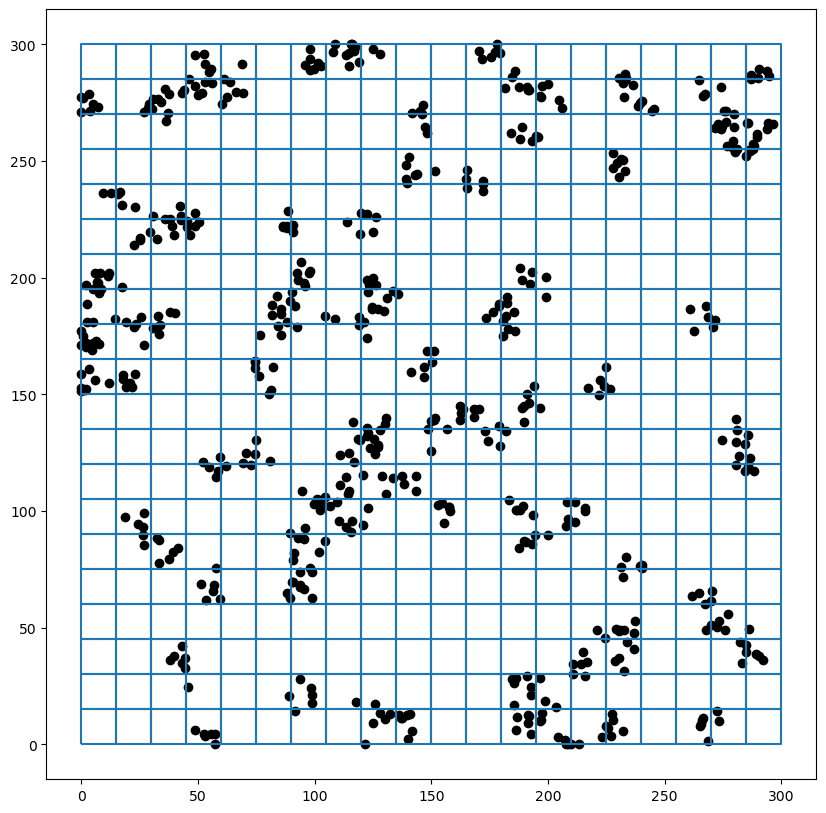

In [5]:
# plt.figure(figsize=(9,5))
tracts_gdf.boundary.plot(figsize=(10,10))
# tracts_gdf.geometry.centroid.plot()
plt.scatter(loc2[:,0], loc2[:,1], color='k')

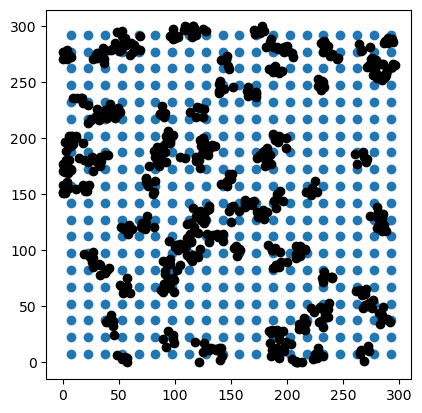

In [6]:
# tracts_gdf.boundary.plot()
tracts_gdf.geometry.centroid.plot()
plt.scatter(loc2[:,0], loc2[:,1], color='k')

Rather than aggregating the points in each tract, the broad idea is to smooth the points around the centroid of each tracts and calibrate local regression with the smoothed values.

In [7]:
len(tracts_gdf), len(S2)

(400, 600)

#### Create different beta surfaces and base DGP

 --> S1 denotes census tracts <br />
 --> S2 denotes points<br />
 --> loc1 denotes centroids of the census tracts<br />
 --> loc2 denotes the locations of the S2 points<br />

In [8]:
S1 = tracts_gdf
S2 = S2
loc1 = np.array([[point.x, point.y] for point in S1.geometry.centroid])
loc2 = loc2

In [9]:
def create_beta_surface(locations, heterogeneity='low'):
    """
    Create beta surface with low or high spatial heterogeneity. defaults to low if none is specified.  
    """
    x, y = locations[:, 0], locations[:, 1]
    if heterogeneity == 'low':
        B = x / 10 + y / 10
    elif heterogeneity == 'high':
        B = np.sin(x/10) * np.cos(y/10) + (x-50)**2/100 + (y-50)**2/100
    return B
    
def uniform(locations):
    """
    Create constant surface with uniform/constant heterogeneity. 
    """
    surface = np.full(len(locations), 5)
    
    return surface


B = create_beta_surface(loc1, heterogeneity='low')

# B = uniform(loc1)


# Generate y values
nbrs_S2 = NearestNeighbors(n_neighbors=len(S1)).fit(loc2)
# nbrs_S2 = NearestNeighbors(n_neighbors=10).fit(loc2)
smoothed_S2_to_S1 = np.zeros(len(S1))
for i in range(len(S1)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
    smoothed_S2_to_S1[i] = np.mean(S2[indices_S1_to_S2[0]])


y = B * smoothed_S2_to_S1 

#### Helper function

In [10]:
def calculate_aicc_rss(n, RSS, tr_S):
    """GWR-style AICc calculation using RSS and trace of the hat matrix (tr_S)."""
    sigma2 = RSS / (n - tr_S)  # Correct variance calculation
    term1 = n * np.log(sigma2)
    term2 = n * np.log(2 * np.pi)
    term3 = n * ((n + tr_S) / (n - 2 - tr_S))
    
    aicc = term1 + term2 + term3
    return aicc

    
def calculate_aicc(n, log_likelihood, tr_S):
    """GWR-style AICc calculation using log-likelihood and trace of the hat matrix (tr_S)."""
    aic = -2 * log_likelihood + 2 * (tr_S + 1)
    aicc = aic + (2 * tr_S * (tr_S + 1)) / (n - tr_S - 1)
    return aicc


def log_likelihood_gaussian(residuals, n, tr_S):
    """Calculate log-likelihood for Gaussian model with trace of hat matrix."""
    sigma2 = np.sum(residuals**2) / (n - tr_S)  
    log_likelihood = -0.5 * n * (np.log(2 * np.pi * sigma2) + 1)
    return log_likelihood
    

def plot_true_and_recovered(true, recovered, coord, name):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(coord[:,0], coord[:, 1], c=true, cmap='Reds', alpha=0.6)
    plt.xlabel('Index')
    plt.ylabel('True B Values ')
    plt.colorbar(label='Beta Value')
    plt.title(f'True B Values for {name}')
    
    plt.subplot(1, 2, 2)
    plt.scatter(coord[:,0], coord[:, 1], c=recovered, cmap='Reds', alpha=0.6)
    plt.xlabel('Index')
    plt.ylabel('recovered B Values')
    plt.colorbar(label='Beta Value')
    plt.title(f'recovered B Values for {name}')
    
    plt.tight_layout()
    plt.show()
    

#### perform cos local regression

In [11]:
def perform_local_regression(n_neighbor_est, loc1, loc2, S2, y):
    """
    Function that implements change of support into a GWR-like local model
    """
    N = len(loc1)
    recovered_betas = np.zeros(N)
    residuals = np.zeros(N)
    S = np.zeros((N, N))
    family = Gaussian() 

    # Code refactoring -> Initialize NearestNeighbors outside the loop (no need to run it everytime inside loop)
    nbrs_S2 = NearestNeighbors(n_neighbors=n_neighbor_est).fit(loc2)
    nbrs_S1 = NearestNeighbors(n_neighbors=n_neighbor_est).fit(loc1)

    # Pre-compute smoothed S2 onto all S1 locations
    smoothed_S2 = np.zeros(N)
    for i in range(N):
        # Find neighbors in S2 for current S1_i for smoothing
        distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
        bw_S2 = distances_S1_to_S2[0][-1]  # Bandwidth for S2

        distances_X = distances_S1_to_S2[0]
        weights_X = np.exp(-0.5 * (distances_X / bw_S2)**2)
        local_X = S2[indices_S1_to_S2[0]]
        smoothed_S2[i] = np.sum(local_X * weights_X) / np.sum(weights_X)

    for i in range(N):
        # Local regression using smoothed S2 data at neighboring S1 locations
        # Find neighbors in S1 for current S1_i
        distances_S1_to_S1, indices_S1_to_S1 = nbrs_S1.kneighbors([loc1[i]])
        bw_S1 = distances_S1_to_S1[0][-1]  # Bandwidth for S1

        y_neighbors = y[indices_S1_to_S1[0]].reshape(-1, 1)
        X_neighbors = smoothed_S2[indices_S1_to_S1[0]].reshape(-1, 1)

        distances_y = distances_S1_to_S1[0]
        weights_y = np.exp(-0.5 * (distances_y / bw_S1)**2).reshape(-1, 1)

        # Perform WLS regression
        rslt = iwls(y_neighbors, X_neighbors, family, None, None, None, 1.0e-5, 40, wi=weights_y)
        betas = rslt[0]  # Extract betas

        recovered_betas[i] = betas[0] 

        # Compute residuals
        y_pred_i = X_neighbors[0, 0] * betas[0]
        residuals[i] = y[i] - y_pred_i

        # Compute leverage h_ii for hat matrix diagonal
        W = np.diag(weights_y.flatten())
        XTWX = X_neighbors.T @ W @ X_neighbors

        # Regularize XTWX if necessary to prevent singularity
        XTWX += np.eye(XTWX.shape[0]) * 1e-8
        XTWX_inv = np.linalg.inv(XTWX)
        
        # Compute h_ii
        x_i = X_neighbors[0, :].reshape(-1,1)
        w_i = weights_y[0,0]
        
        h_ii = (x_i.T @ XTWX_inv @ x_i) * w_i
        S[i, i] = h_ii

    RSS = np.sum(residuals**2)

    # Calculate trace of S
    tr_S = np.trace(S)
    
    # print(smoothed_S2)

    # Calculate AICc
    log_likelihood = log_likelihood_gaussian(residuals, len(S1), tr_S) # not used
    aicc_ll = calculate_aicc(len(S1), log_likelihood, tr_S) # not used
   
    aicc = calculate_aicc_rss(N, RSS, tr_S)

    return recovered_betas, aicc_ll, tr_S

### I am starting by setting size of the tracts to 400 (20by20 squares). Making each tract a small area initially. Then I subsequently expand this size

In [12]:
# Define range for number of neighbors
neighbors_values = list(range(2, len(S1), 2))
best_aicc = float('inf')
best_neighbors = None
recovered_betas_best = None

aicc_values = []
enp_values = []

# Iterate over neighbor values
for n_neighbors in neighbors_values:
    recovered_betas, aicc, enp = perform_local_regression(n_neighbors, loc1, loc2, S2, y)
    aicc_values.append(aicc)
    enp_values.append(enp)
    if aicc < best_aicc:
        best_aicc = aicc
        best_neighbors = n_neighbors
        recovered_betas_best = recovered_betas

print(f"Optimal number of neighbors: {best_neighbors}")
print(f"Best AICc: {best_aicc:.2f}")

Optimal number of neighbors: 44
Best AICc: 4922.12


In [13]:
dict_aicc = dict(zip(neighbors_values, aicc_values))
min(dict_aicc, key=dict_aicc.get)

44

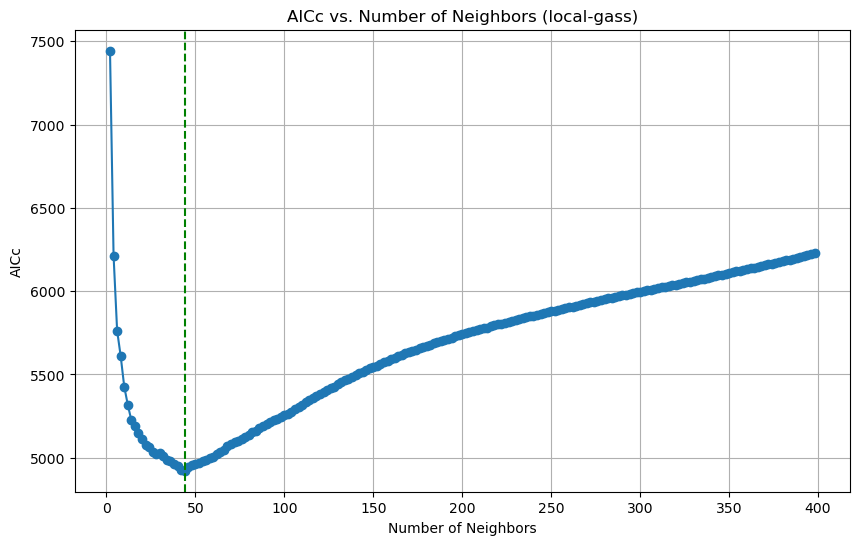

In [14]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, aicc_values, marker='o')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title('AICc vs. Number of Neighbors (local-gass)')
plt.grid(True)
plt.show()

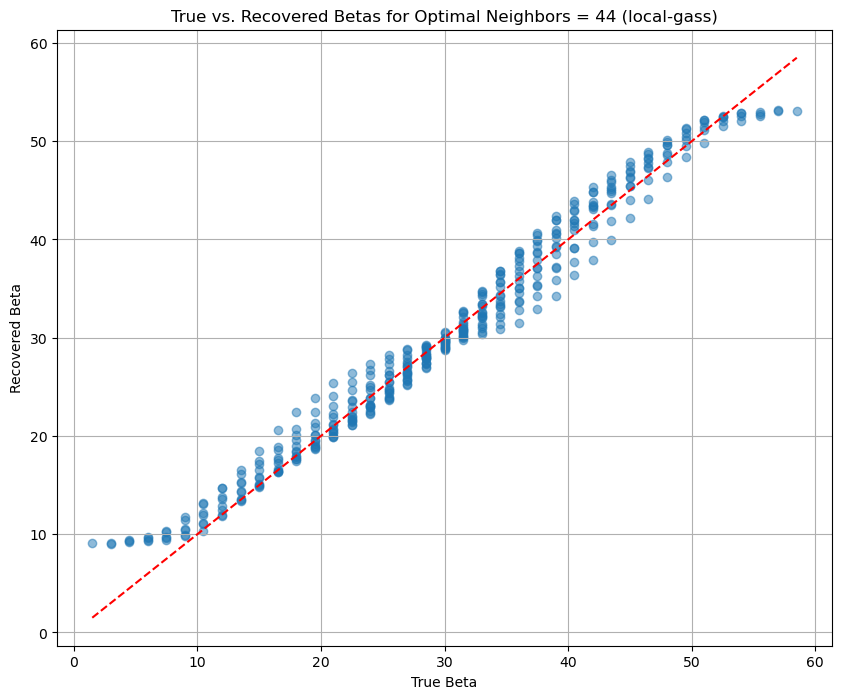

In [15]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors
# val = 40
# single, aicc, enp = perform_local_regression(val, loc1, loc2, S2, y)

plt.figure(figsize=(10, 8))
plt.scatter(B, recovered_betas_best, alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors} (local-gass)')
plt.grid(True) 
plt.show()

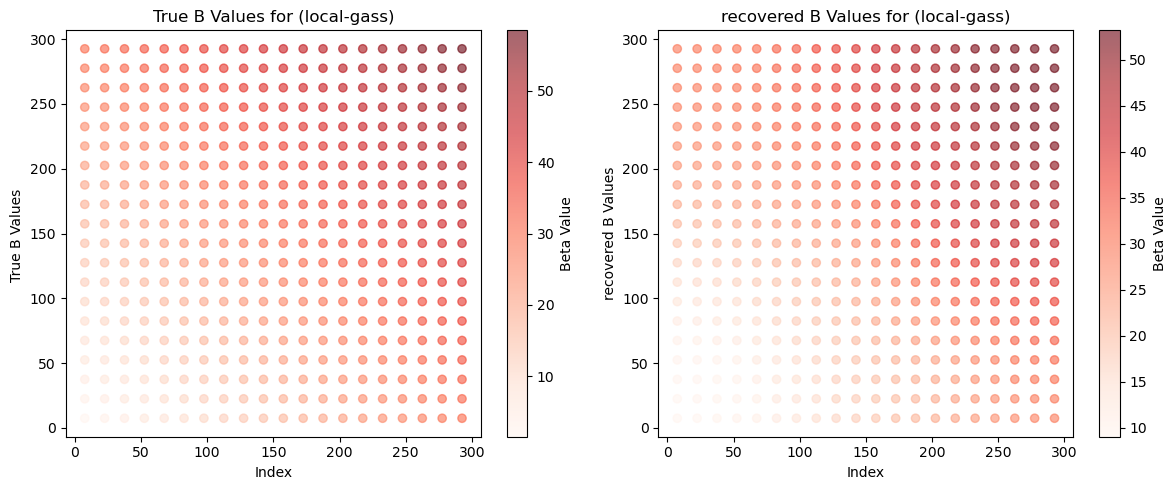

In [16]:
plot_true_and_recovered(B, recovered_betas_best.round(1), loc1, name='(local-gass)')

In [17]:
B

array([ 1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. , 16.5,
       18. , 19.5, 21. , 22.5, 24. , 25.5, 27. , 28.5, 30. ,  3. ,  4.5,
        6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. , 16.5, 18. , 19.5, 21. ,
       22.5, 24. , 25.5, 27. , 28.5, 30. , 31.5,  4.5,  6. ,  7.5,  9. ,
       10.5, 12. , 13.5, 15. , 16.5, 18. , 19.5, 21. , 22.5, 24. , 25.5,
       27. , 28.5, 30. , 31.5, 33. ,  6. ,  7.5,  9. , 10.5, 12. , 13.5,
       15. , 16.5, 18. , 19.5, 21. , 22.5, 24. , 25.5, 27. , 28.5, 30. ,
       31.5, 33. , 34.5,  7.5,  9. , 10.5, 12. , 13.5, 15. , 16.5, 18. ,
       19.5, 21. , 22.5, 24. , 25.5, 27. , 28.5, 30. , 31.5, 33. , 34.5,
       36. ,  9. , 10.5, 12. , 13.5, 15. , 16.5, 18. , 19.5, 21. , 22.5,
       24. , 25.5, 27. , 28.5, 30. , 31.5, 33. , 34.5, 36. , 37.5, 10.5,
       12. , 13.5, 15. , 16.5, 18. , 19.5, 21. , 22.5, 24. , 25.5, 27. ,
       28.5, 30. , 31.5, 33. , 34.5, 36. , 37.5, 39. , 12. , 13.5, 15. ,
       16.5, 18. , 19.5, 21. , 22.5, 24. , 25.5, 27

In [18]:
recovered_betas_best.round(1)

array([ 9.1,  9. ,  9.3,  9.6, 10.2, 11.5, 13. , 14.7, 16.5, 18.5, 20.6,
       22.4, 23.9, 25.4, 26.4, 27.3, 28.2, 28.9, 29.3, 29.5,  9.1,  9.2,
        9.3,  9.6, 10.4, 11.9, 13.6, 15.3, 17.2, 18.9, 20.7, 22.4, 24.1,
       25.5, 26.7, 27.8, 28.7, 29.2, 29.6, 30. ,  9.4,  9.4,  9.4,  9.8,
       11.1, 12.5, 14.3, 15.8, 17.6, 19.6, 21.3, 23.1, 24.7, 26.2, 27.3,
       28.3, 29. , 29.5, 30.1, 30.3,  9.7,  9.7,  9.9, 10.3, 11.9, 13.4,
       15. , 16.7, 18.4, 20.1, 21.9, 23.6, 25.2, 26.6, 27.9, 29. , 29.8,
       30.1, 30.6, 30.9, 10.3, 10.5, 11.1, 12. , 13.4, 14.8, 16.4, 17.9,
       19.5, 21.1, 23. , 24.6, 26.2, 27.6, 28.9, 30. , 30.8, 31.1, 31.4,
       31.5, 11.8, 12.2, 12.9, 13.6, 14.9, 16.3, 17.6, 19. , 20.6, 22.1,
       23.8, 25.5, 27.1, 28.5, 29.9, 31. , 32. , 32.4, 32.8, 32.9, 13.2,
       13.7, 14.4, 15.1, 16.3, 17.5, 18.7, 20. , 21.5, 23. , 24.7, 26.4,
       28.1, 29.6, 30.9, 32.2, 33.3, 33.8, 34.3, 34.2, 14.7, 15.2, 15.7,
       16.5, 17.7, 18.8, 19.9, 21.1, 22.4, 23.9, 25

In [19]:
B.min(), B.max()

(1.5, 58.5)

In [20]:
recovered_betas_best.min(), recovered_betas_best.max()

(9.043613283873293, 53.19728756278101)

<br />
<br />
<br />

#### Aggregating points into census tracts for GWR

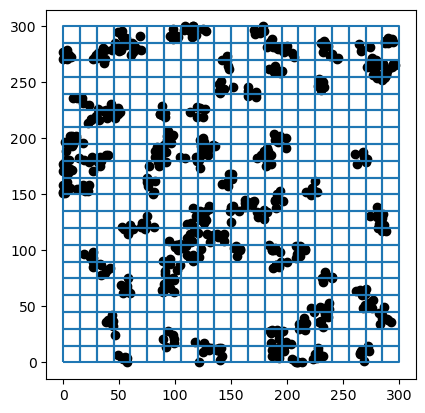

In [21]:
tracts_gdf.boundary.plot()
# tracts_gdf.geometry.centroid.plot()
plt.scatter(loc2[:,0], loc2[:,1], color='k')

In [22]:
df_S2 = gpd.GeoDataFrame({'S2': S2}, geometry=gpd.points_from_xy(loc2[:, 0], loc2[:, 1]))

In [23]:
df_S2.head()

S2                 geometry
0  41.889285   POINT (269.651 61.307)
1  30.007298  POINT (100.780 105.244)
2  33.917596   POINT (194.291 89.748)
3  58.515647   POINT (19.020 181.152)
4  87.220357   POINT (74.514 163.678)

<Axes: >

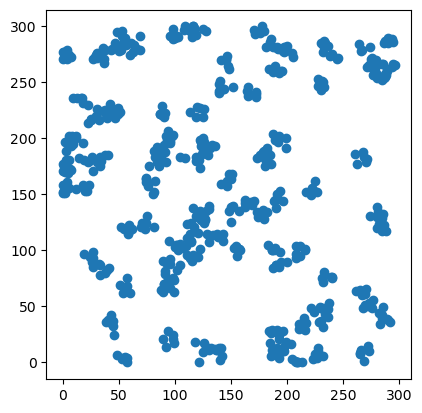

In [24]:
df_S2.plot()

#### Spatial Join and mean-aggregation

In [25]:
joined = gpd.sjoin(df_S2, S1, how='inner', predicate='within')

In [26]:
joined.head()

S2                 geometry  index_right  tract_id
0    41.889285   POINT (269.651 61.307)          344       344
365  71.388463   POINT (264.907 64.831)          344       344
413  72.325086   POINT (261.920 63.609)          344       344
1    30.007298  POINT (100.780 105.244)          127       127
30   84.020875   POINT (94.617 108.672)          127       127

<Axes: >

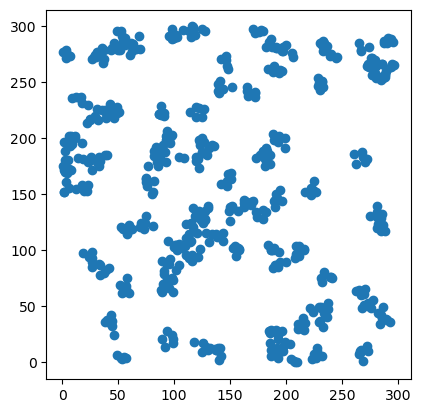

In [27]:
joined.plot()

In [28]:
sX = joined.groupby('tract_id').agg({'S2': ['mean']})#.reset_index()

In [29]:
sX.columns = ['_'.join(col).strip() for col in sX.columns.values]
sX = sX.reset_index()

In [30]:
# merge back with tracts (S1)
sX1 = S1.merge(sX, on='tract_id', how='left')

In [31]:
sX1.head()

tract_id                                           geometry  S2_mean
0         0  POLYGON ((0.00000 0.00000, 15.00000 0.00000, 1...      NaN
1         1  POLYGON ((0.00000 15.00000, 15.00000 15.00000,...      NaN
2         2  POLYGON ((0.00000 30.00000, 15.00000 30.00000,...      NaN
3         3  POLYGON ((0.00000 45.00000, 15.00000 45.00000,...      NaN
4         4  POLYGON ((0.00000 60.00000, 15.00000 60.00000,...      NaN

##### 95 missing values after spatial join. This speaks to one of the drawbacks of using this method

In [32]:
sX1['S2_mean']

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
         ...    
395          NaN
396    53.139621
397    27.576103
398          NaN
399    46.813399
Name: S2_mean, Length: 400, dtype: float64

In [33]:
sX1.isna().sum()

tract_id      0
geometry      0
S2_mean     233
dtype: int64

In [34]:
sX1.fillna({'S2_mean': 0.001}, inplace=True)

In [35]:
sX1.isna().sum()

tract_id    0
geometry    0
S2_mean     0
dtype: int64

In [36]:
gwr_X  = sX1['S2_mean'].values.reshape(-1,1)
gwr_y = y.reshape(-1, 1)
coords = np.array([[point.x, point.y] for point in sX1['geometry'].centroid])

In [37]:
gwr_X.shape, gwr_y.shape

((400, 1), (400, 1))

##### Calibrate GWR

In [38]:
aicc_gwr = []
params = []
ENP = []
bwvalue = list(range(10, len(loc1), 2))
for i in bwvalue:
    model = GWR(coords, gwr_y, gwr_X, i, constant=False).fit()
    params.append(model.params)
    aicc_gwr.append(model.aicc)
    ENP.append(model.ENP)

In [39]:
dict_aicc = dict(zip(bwvalue, aicc_gwr))

In [40]:
min(dict_aicc, key=dict_aicc.get)

224

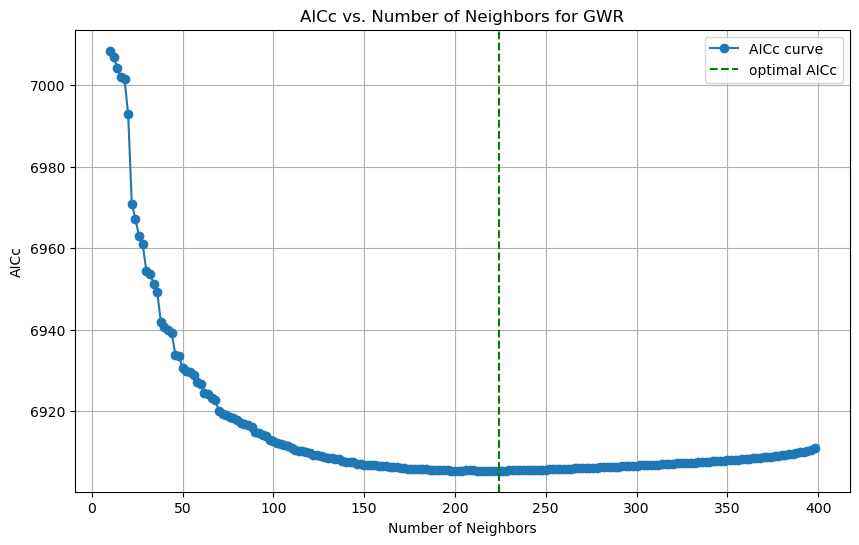

In [41]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(bwvalue, aicc_gwr, marker='o', label='AICc curve')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.legend()
plt.title('AICc vs. Number of Neighbors for GWR')
plt.grid(True)
plt.show()

In [42]:
params[0].shape

(400, 1)

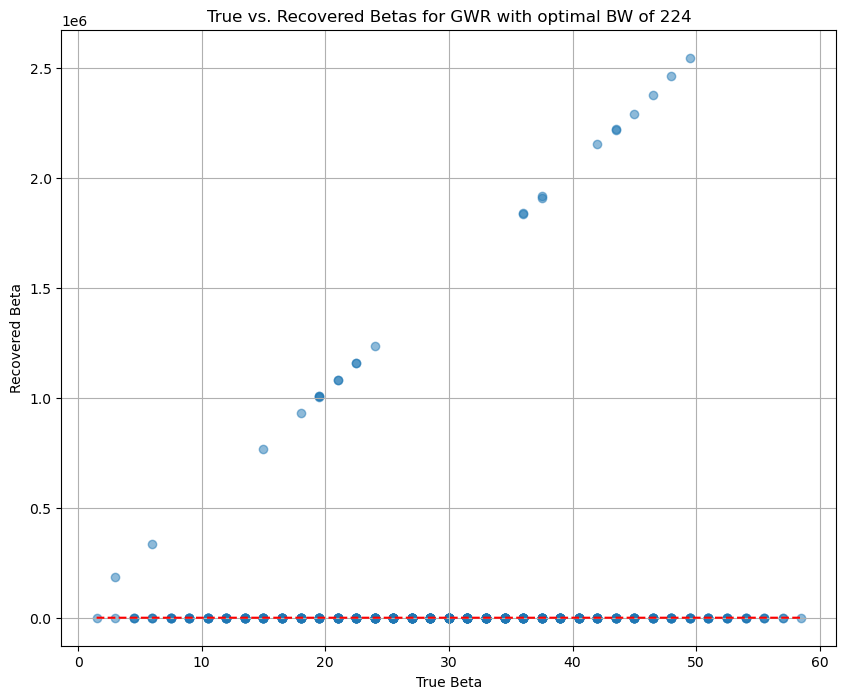

In [43]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, params[0].ravel(), alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f"True vs. Recovered Betas for GWR with optimal BW of {min(dict_aicc, key=dict_aicc.get)}")
plt.grid(True)
plt.show()

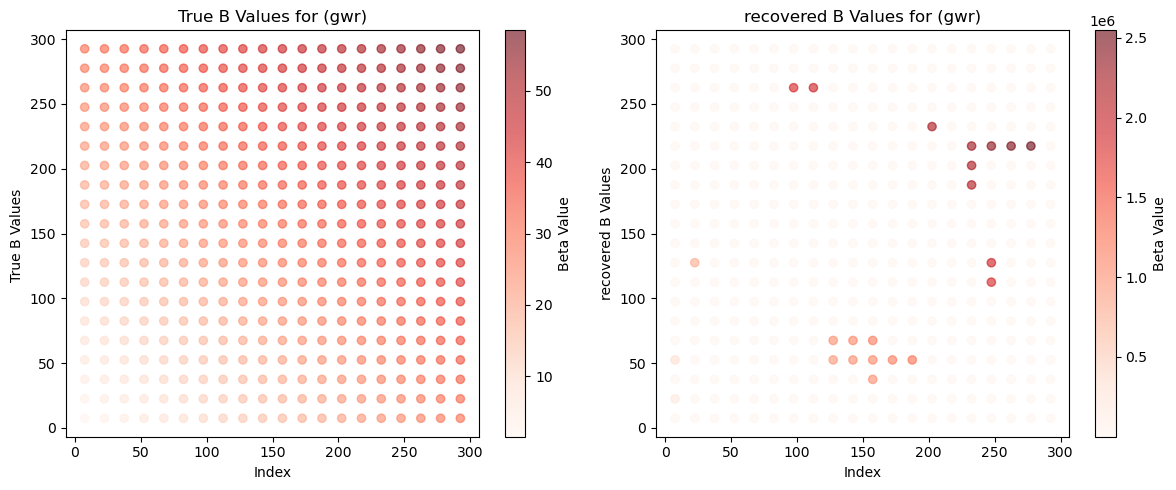

In [44]:
plot_true_and_recovered(B, params[0], loc1, name='(gwr)')

In [45]:
B

array([ 1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. , 16.5,
       18. , 19.5, 21. , 22.5, 24. , 25.5, 27. , 28.5, 30. ,  3. ,  4.5,
        6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. , 16.5, 18. , 19.5, 21. ,
       22.5, 24. , 25.5, 27. , 28.5, 30. , 31.5,  4.5,  6. ,  7.5,  9. ,
       10.5, 12. , 13.5, 15. , 16.5, 18. , 19.5, 21. , 22.5, 24. , 25.5,
       27. , 28.5, 30. , 31.5, 33. ,  6. ,  7.5,  9. , 10.5, 12. , 13.5,
       15. , 16.5, 18. , 19.5, 21. , 22.5, 24. , 25.5, 27. , 28.5, 30. ,
       31.5, 33. , 34.5,  7.5,  9. , 10.5, 12. , 13.5, 15. , 16.5, 18. ,
       19.5, 21. , 22.5, 24. , 25.5, 27. , 28.5, 30. , 31.5, 33. , 34.5,
       36. ,  9. , 10.5, 12. , 13.5, 15. , 16.5, 18. , 19.5, 21. , 22.5,
       24. , 25.5, 27. , 28.5, 30. , 31.5, 33. , 34.5, 36. , 37.5, 10.5,
       12. , 13.5, 15. , 16.5, 18. , 19.5, 21. , 22.5, 24. , 25.5, 27. ,
       28.5, 30. , 31.5, 33. , 34.5, 36. , 37.5, 39. , 12. , 13.5, 15. ,
       16.5, 18. , 19.5, 21. , 22.5, 24. , 25.5, 27

In [46]:
params[0].round(1).flatten()

array([      6. ,  184136.3,       6. ,  336125.9,       6.9,       7.7,
             8.2,       9.2,      15.1,      16.1,      17. ,      18.6,
            21.6,      25.4,      24.8,      22.9,      22.2,      24.3,
            24.1,      24.2,       7.9,       6. ,       6. ,       6. ,
             7.8,       8.3,       8.6,       9.2,  765257.9,      17.3,
            18.8,      19.6,      20. ,      24.1,      28.4,      26.5,
            27.7,      24.3,      23.6,      23.3,       8.9,       7.3,
             6.3,       7.4,       9.9,       9.1,       9.7,      17. ,
            42.8,      22.4,      21.7,      18.8,      17.1,      21.2,
            32.3,      32.5,      31. ,      27.1,      26.2,      26.9,
             9.5,       9. ,       7.2,       9.6,      10. ,       9.4,
            11.2,      28.8,      23.7,      22.5,      22.9,      18.7,
            15.1,      23.2,      38.6,      37.4,      34.6,      28.7,
            29.6,      31.2,       9.5,      10.1, 

In [47]:
B.min(), B.max()

(1.5, 58.5)

In [48]:
params[0].min(), params[0].max()

(6.016857907246937, 2546623.498535165)

##### They both recover the true scale but GWR has more errors in recovering the true betas..

<br />

### Next experiment will be increasing aggregation by reducing the number of tracts to 225 (15by15 squares). It was previously 400 

##### Here, i have increased the dimension to 20 x 20. It was previously 15 x 15. 

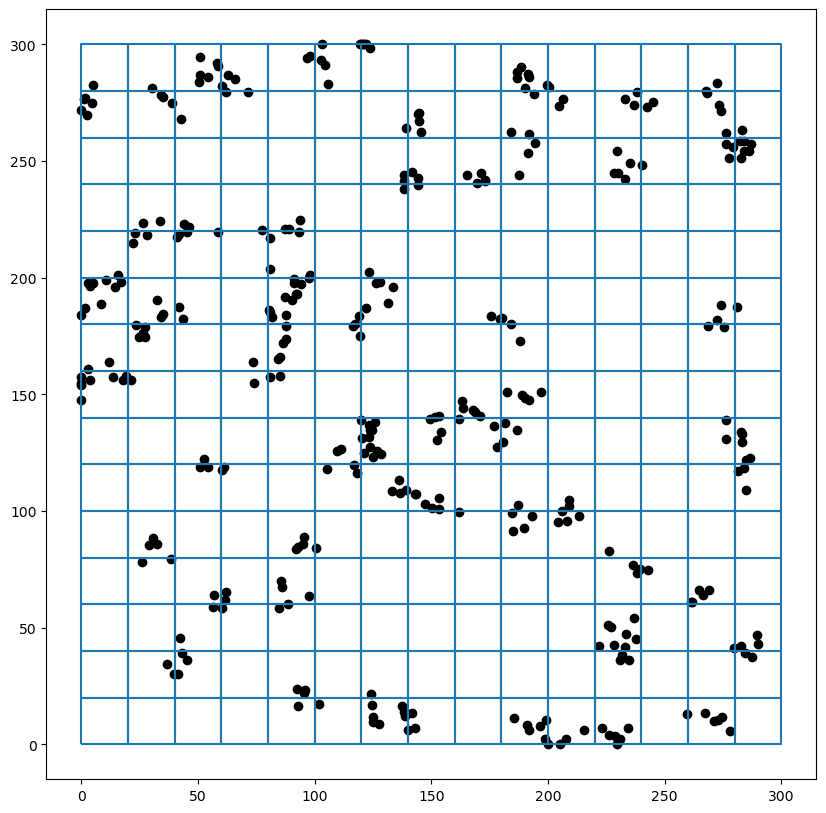

In [49]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 20, 20  # Creates a 20x20 grid, resulting in 225 tracts cell divisions
tracts_gdf = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

# Simulate S2

def simulate_clustered_S2(num_points, num_clusters, cluster_std=5, x_range=(0, 300), y_range=(0, 300), random_state=None):
    """
    Simulates clustered points and returns corresponding S2 values and locations.

    Parameters:
    - num_points: total number of points to generate
    - num_clusters: number of spatial clusters to create
    - cluster_std: standard deviation of clusters (controls spread of points)
    - x_range, y_range: bounds for the spatial area (min, max values for x and y)

    Returns:
    - S2: array of S2 values (normally distributed)
    - locations: array of [x, y] coordinates for each point
    """
    
    if random_state is not None:
        np.random.seed(random_state)
    # Generate clustered points using sklearn's make_blobs function
    centers = np.random.uniform(low=x_range[0], high=x_range[1], size=(num_clusters, 2))
    locations, _ = make_blobs(n_samples=num_points, centers=centers, cluster_std=cluster_std)
    
    # Clip points to fit within the study area bounds (if needed)
    locations[:, 0] = np.clip(locations[:, 0], x_range[0], x_range[1])
    locations[:, 1] = np.clip(locations[:, 1], y_range[0], y_range[1])
    
    # Generate S2 values
    S2 = np.random.normal(50, 30, num_points)
    
    return S2, locations

S2, loc2 = simulate_clustered_S2(350, num_clusters=65, cluster_std=4, random_state=12)

tracts_gdf.boundary.plot(figsize=(10, 10))
# tracts_gdf.geometry.centroid.plot()
plt.scatter(loc2[:,0], loc2[:,1], color='k')

S1 = tracts_gdf
S2 = S2
loc1 = np.array([[point.x, point.y] for point in S1.geometry.centroid])
loc2 = loc2


B = create_beta_surface(loc1, heterogeneity='low')

# B = uniform(loc1)

# Generate y values
nbrs_S2 = NearestNeighbors(n_neighbors=len(S1)).fit(loc2)
smoothed_S2_to_S1 = np.zeros(len(S1))
for i in range(len(S1)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
    smoothed_S2_to_S1[i] = np.mean(S2[indices_S1_to_S2[0]])

y = B * smoothed_S2_to_S1

In [50]:
len(tracts_gdf), len(S2)

(225, 350)

In [51]:
# Define range for number of neighbors
neighbors_values = list(range(2, len(S1), 2))
best_aicc = float('inf')
best_neighbors = None
recovered_betas_best = None

aicc_values = []
enp_values = []

# Iterate over neighbor values
for n_neighbors in neighbors_values:
    recovered_betas, aicc, enp = perform_local_regression(n_neighbors, loc1, loc2, S2, y)
    aicc_values.append(aicc)
    enp_values.append(enp)
    if aicc < best_aicc:
        best_aicc = aicc
        best_neighbors = n_neighbors
        recovered_betas_best = recovered_betas

print(f"Optimal number of neighbors: {best_neighbors}")
print(f"Best AICc: {best_aicc:.2f}")

Optimal number of neighbors: 30
Best AICc: 2867.52


In [52]:
dict_aicc = dict(zip(neighbors_values, aicc_values))
min(dict_aicc, key=dict_aicc.get)

30

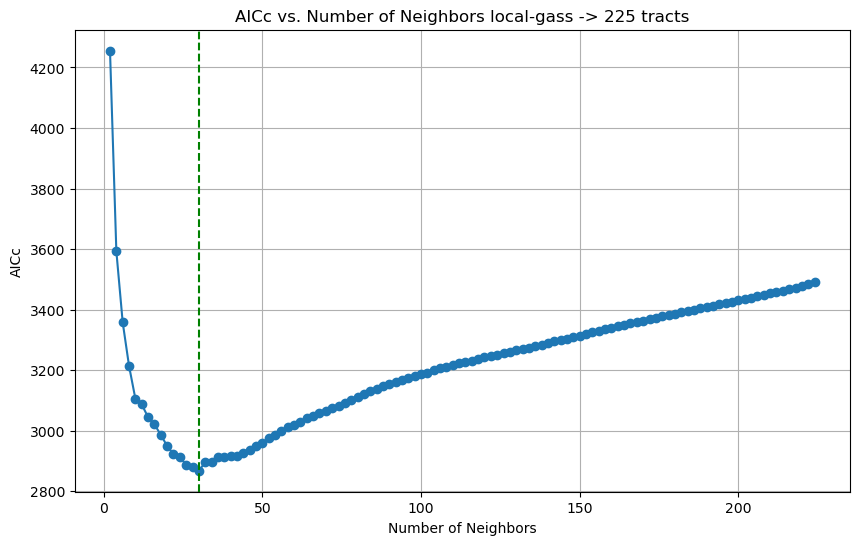

In [53]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, aicc_values, marker='o')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title('AICc vs. Number of Neighbors local-gass -> 225 tracts')
plt.grid(True)
plt.show()

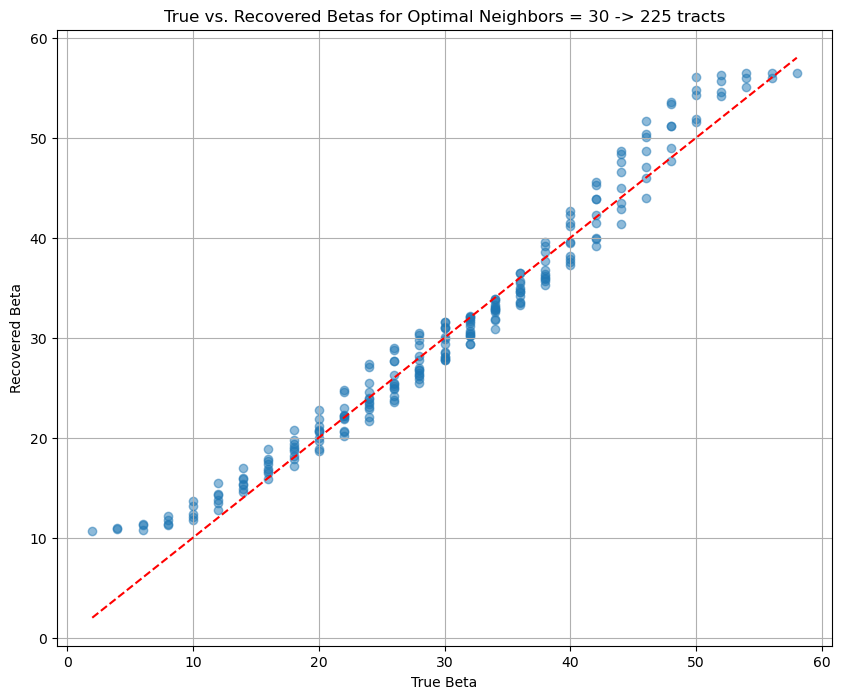

In [54]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, recovered_betas_best, alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors} -> 225 tracts')
plt.grid(True)
plt.show()

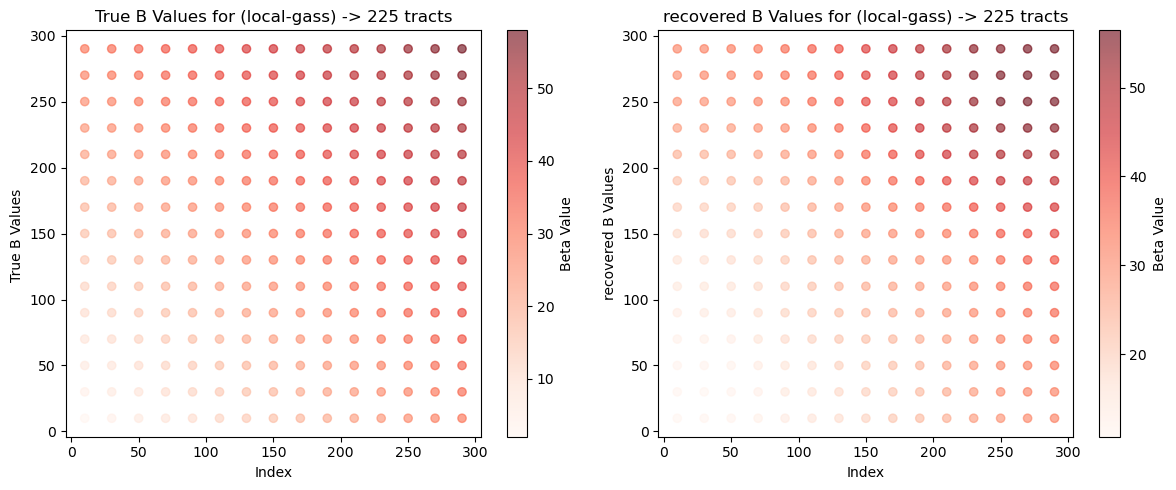

In [55]:
plot_true_and_recovered(B, recovered_betas_best, loc1, name='(local-gass) -> 225 tracts')

In [56]:
B.min(), B.max()

(2.0, 58.0)

In [57]:
recovered_betas_best.min(), recovered_betas_best.max()

(10.686363821893215, 56.46337382234144)

<br />

#### Aggregating points into census tracts for GWR

For GWR, one has to aggregate points into tracts every time it is increased

In [58]:
df_S2 = gpd.GeoDataFrame({'S2': S2}, geometry=gpd.points_from_xy(loc2[:, 0], loc2[:, 1]))
joined = gpd.sjoin(df_S2, S1, how='inner', predicate='within')
sX = joined.groupby('tract_id').agg({'S2': ['mean']})
sX.columns = ['_'.join(col).strip() for col in sX.columns.values]
sX = sX.reset_index()

# merge back with tracts (S1)
sX1 = S1.merge(sX, on='tract_id', how='left')
sX1.fillna({'S2_mean': 0.00001}, inplace=True)

In [59]:
sX1.head()

tract_id                                           geometry  S2_mean
0         0  POLYGON ((0.000 0.000, 20.000 0.000, 20.000 20...  0.00001
1         1  POLYGON ((0.000 20.000, 20.000 20.000, 20.000 ...  0.00001
2         2  POLYGON ((0.000 40.000, 20.000 40.000, 20.000 ...  0.00001
3         3  POLYGON ((0.000 60.000, 20.000 60.000, 20.000 ...  0.00001
4         4  POLYGON ((0.000 80.000, 20.000 80.000, 20.000 ...  0.00001

##### Specify GWR parameters

In [60]:
gwr_X  = sX1['S2_mean'].values.reshape(-1,1)
gwr_y = y.reshape(-1, 1)
coords = np.array([[point.x, point.y] for point in sX1['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((225, 1), (225, 1))

In [61]:
aicc_gwr = []
params = []
ENP = []
bwvalue = list(range(10, len(loc1), 2))
for i in bwvalue:
    model = GWR(coords, gwr_y, gwr_X, i, constant=False).fit()
    params.append(model.params)
    aicc_gwr.append(model.aicc)
    ENP.append(model.ENP)

In [62]:
dict_aicc = dict(zip(bwvalue, aicc_gwr))

In [63]:
min(dict_aicc, key=dict_aicc.get)

144

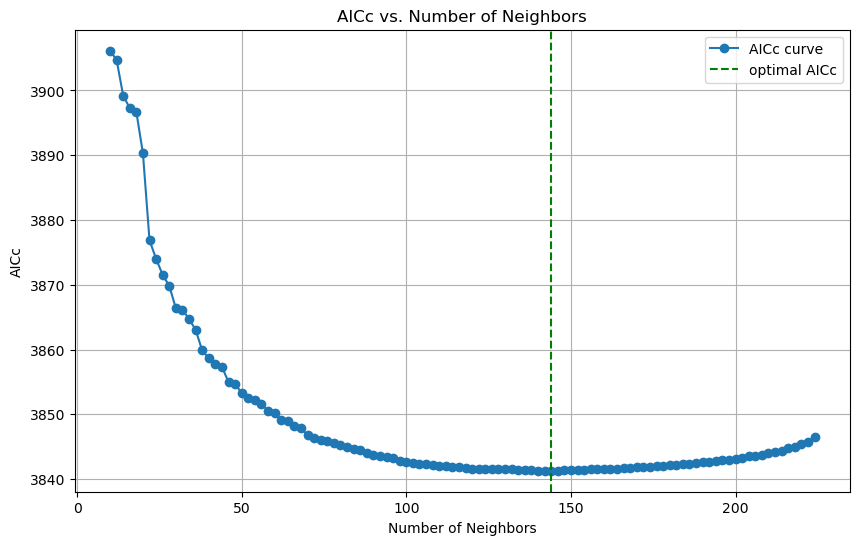

In [64]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(bwvalue, aicc_gwr, marker='o', label='AICc curve')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.legend()
plt.title('AICc vs. Number of Neighbors')
plt.grid(True)
plt.show()

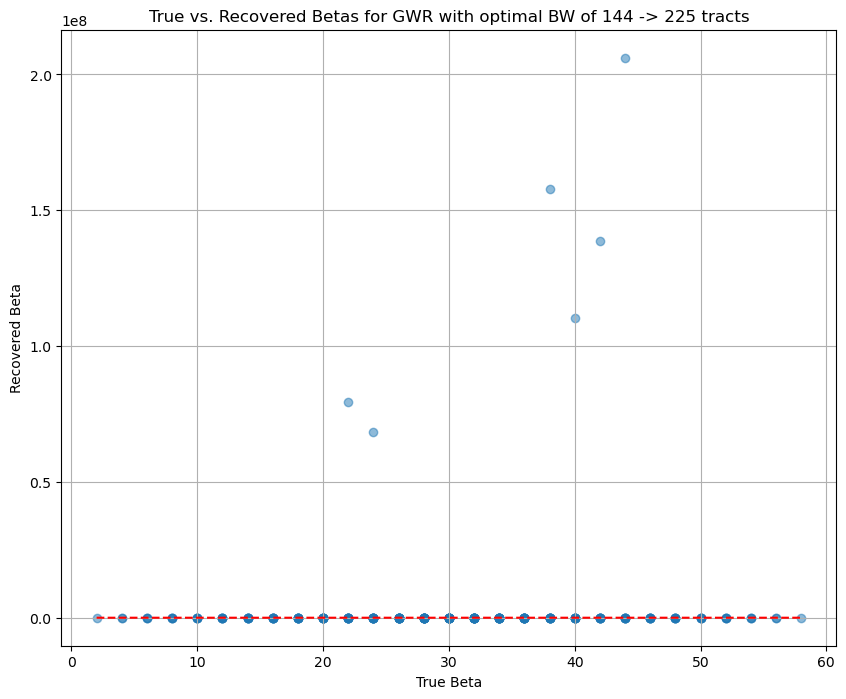

In [65]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, params[0].ravel(), alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f"True vs. Recovered Betas for GWR with optimal BW of {min(dict_aicc, key=dict_aicc.get)} -> 225 tracts")
plt.grid(True)
plt.show()

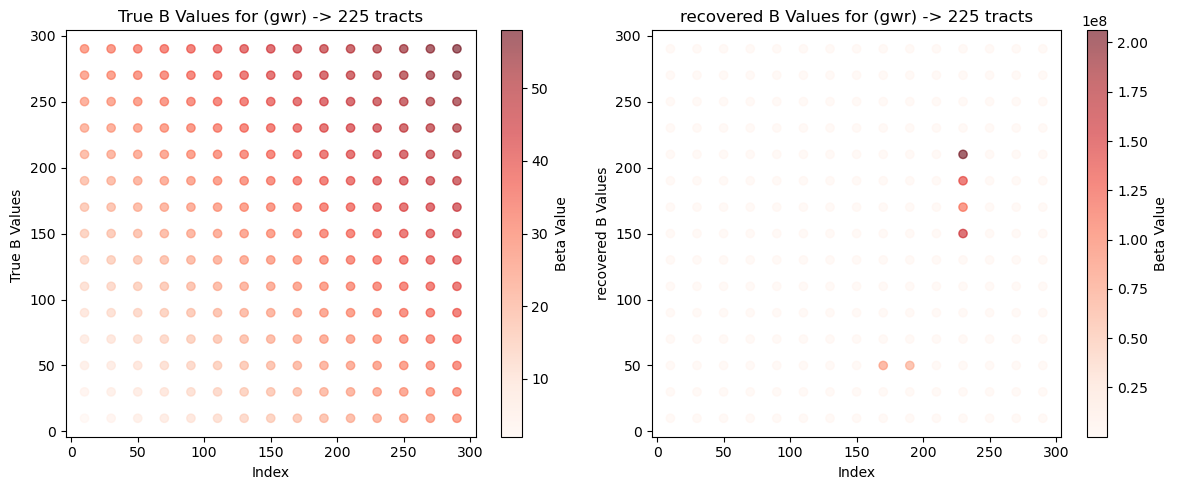

In [66]:
plot_true_and_recovered(B, params[0], loc1, name='(gwr) -> 225 tracts')

In [67]:
B.min(), B.max()

(2.0, 58.0)

In [68]:
params[0].min(), params[0].max()

(6.681834075373568, 206149020.73937497)

<b />

### Further increasing aggregation by reducing the number of tracts to 144 (12by12 squares). It was previously 225 

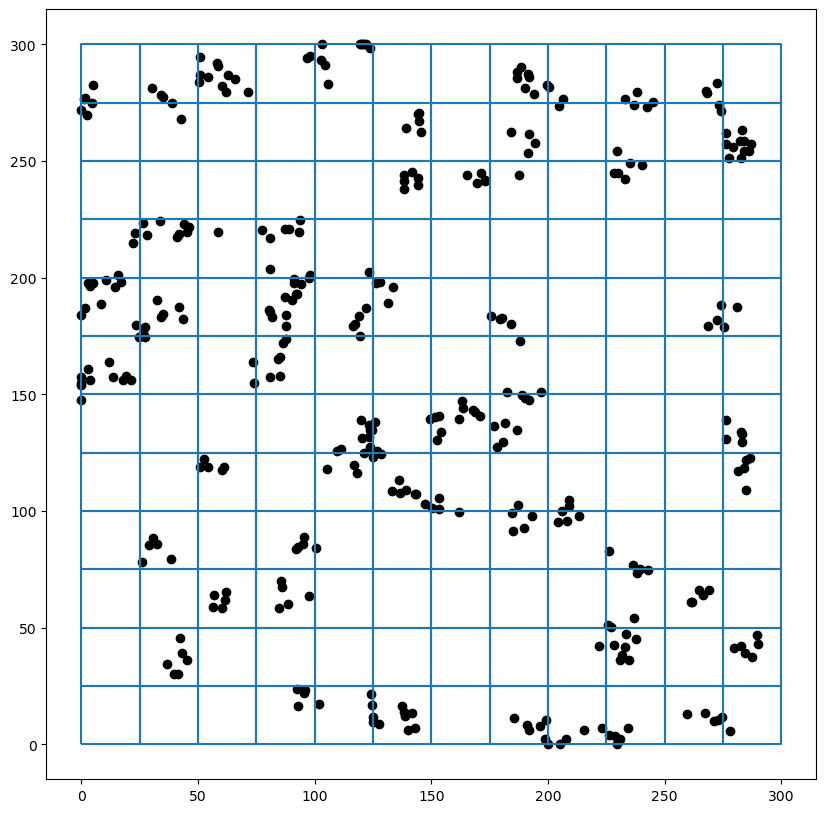

In [69]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 25, 25  # Creates a 25x25 grid, resulting in 144 tracts cell divisions
tracts_gdf = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

# Simulate S2

def simulate_clustered_S2(num_points, num_clusters, cluster_std=5, x_range=(0, 300), y_range=(0, 300), random_state=None):
    """
    Simulates clustered points and returns corresponding S2 values and locations.

    Parameters:
    - num_points: total number of points to generate
    - num_clusters: number of spatial clusters to create
    - cluster_std: standard deviation of clusters (controls spread of points)
    - x_range, y_range: bounds for the spatial area (min, max values for x and y)

    Returns:
    - S2: array of S2 values (normally distributed)
    - locations: array of [x, y] coordinates for each point
    """
    
    if random_state is not None:
        np.random.seed(random_state)
    # Generate clustered points using sklearn's make_blobs function
    centers = np.random.uniform(low=x_range[0], high=x_range[1], size=(num_clusters, 2))
    locations, _ = make_blobs(n_samples=num_points, centers=centers, cluster_std=cluster_std)
    
    # Clip points to fit within the study area bounds (if needed)
    locations[:, 0] = np.clip(locations[:, 0], x_range[0], x_range[1])
    locations[:, 1] = np.clip(locations[:, 1], y_range[0], y_range[1])
    
    # Generate S2 values
    S2 = np.random.normal(50, 30, num_points)
    
    return S2, locations

S2, loc2 = simulate_clustered_S2(350, num_clusters=65, cluster_std=4, random_state=12)

tracts_gdf.boundary.plot(figsize=(10, 10))
# tracts_gdf.geometry.centroid.plot()
plt.scatter(loc2[:,0], loc2[:,1], color='k')

S1 = tracts_gdf
S2 = S2
loc1 = np.array([[point.x, point.y] for point in S1.geometry.centroid])
loc2 = loc2


B = create_beta_surface(loc1, heterogeneity='low')

# B = uniform(loc1)

# Generate y values
nbrs_S2 = NearestNeighbors(n_neighbors=len(S1)).fit(loc2)
smoothed_S2_to_S1 = np.zeros(len(S1))
for i in range(len(S1)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
    smoothed_S2_to_S1[i] = np.mean(S2[indices_S1_to_S2[0]])

y = B * smoothed_S2_to_S1

In [70]:
len(S1), len(y), len(S2)

(144, 144, 350)

In [71]:
# Define range for number of neighbors
neighbors_values = list(range(2, len(S1), 2))
best_aicc = float('inf')
best_neighbors = None
recovered_betas_best = None

aicc_values = []
enp_values = []

# Iterate over neighbor values
for n_neighbors in neighbors_values:
    recovered_betas, aicc, enp = perform_local_regression(n_neighbors, loc1, loc2, S2, y)
    aicc_values.append(aicc)
    enp_values.append(enp)
    if aicc < best_aicc:
        best_aicc = aicc
        best_neighbors = n_neighbors
        recovered_betas_best = recovered_betas

print(f"Optimal number of neighbors: {best_neighbors}")
print(f"Best AICc: {best_aicc:.2f}")

Optimal number of neighbors: 22
Best AICc: 1939.75


In [72]:
dict_aicc = dict(zip(neighbors_values, aicc_values))
min(dict_aicc, key=dict_aicc.get)

22

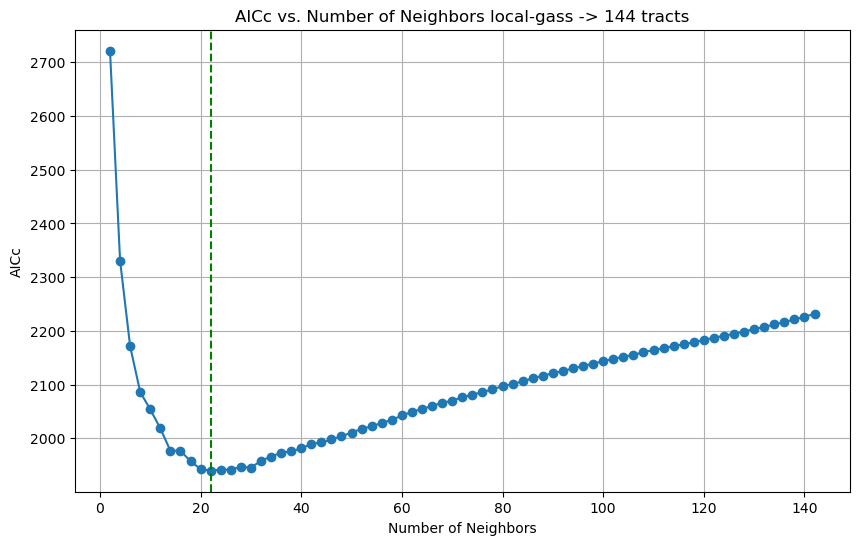

In [73]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, aicc_values, marker='o')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title('AICc vs. Number of Neighbors local-gass -> 144 tracts')
plt.grid(True)
plt.show()

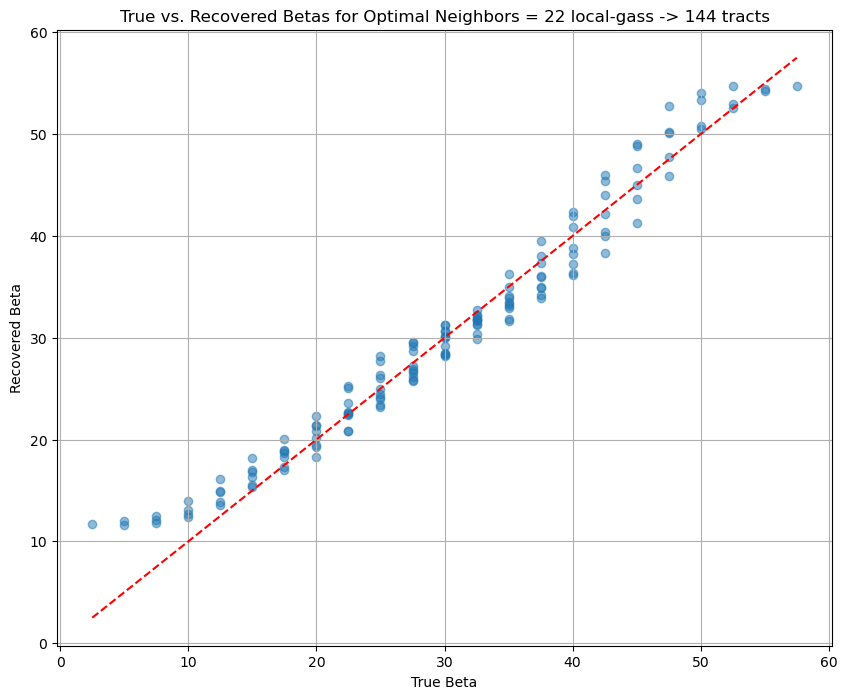

In [74]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, recovered_betas_best, alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors} local-gass -> 144 tracts')
plt.grid(True)
plt.show()

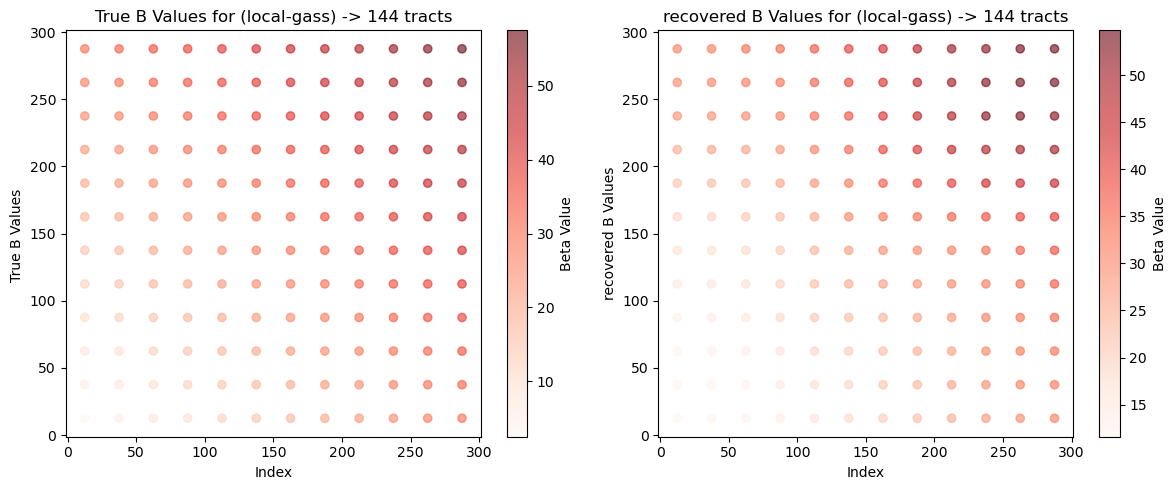

In [75]:
plot_true_and_recovered(B, recovered_betas_best, loc1, name='(local-gass) -> 144 tracts')

In [76]:
B.min(), B.max()

(2.5, 57.5)

In [77]:
recovered_betas_best.min(), recovered_betas_best.max()

(11.58920602738873, 54.764835021513925)

<br />

#### Aggregating points into census tracts for GWR

For GWR, one has to aggregate points into tracts every time it is increased

In [78]:
df_S2 = gpd.GeoDataFrame({'S2': S2}, geometry=gpd.points_from_xy(loc2[:, 0], loc2[:, 1]))
joined = gpd.sjoin(df_S2, S1, how='inner', predicate='within')
sX = joined.groupby('tract_id').agg({'S2': ['mean']})
sX.columns = ['_'.join(col).strip() for col in sX.columns.values]
sX = sX.reset_index()

# merge back with tracts (S1)
sX1 = S1.merge(sX, on='tract_id', how='left')
sX1.fillna({'S2_mean': 0.00001}, inplace=True)

In [79]:
sX1.head()

tract_id                                           geometry  S2_mean
0         0  POLYGON ((0.000 0.000, 25.000 0.000, 25.000 25...  0.00001
1         1  POLYGON ((0.000 25.000, 25.000 25.000, 25.000 ...  0.00001
2         2  POLYGON ((0.000 50.000, 25.000 50.000, 25.000 ...  0.00001
3         3  POLYGON ((0.000 75.000, 25.000 75.000, 25.000 ...  0.00001
4         4  POLYGON ((0.000 100.000, 25.000 100.000, 25.00...  0.00001

##### Specify GWR parameters

In [80]:
gwr_X  = sX1['S2_mean'].values.reshape(-1,1)
gwr_y = y.reshape(-1, 1)
coords = np.array([[point.x, point.y] for point in sX1['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((144, 1), (144, 1))

In [81]:
aicc_gwr = []
params = []
ENP = []
bwvalue = list(range(10, len(loc1), 2))
for i in bwvalue:
    model = GWR(coords, gwr_y, gwr_X, i, constant=False).fit()
    params.append(model.params)
    aicc_gwr.append(model.aicc)
    ENP.append(model.ENP)

In [82]:
dict_aicc = dict(zip(bwvalue, aicc_gwr))

In [83]:
min(dict_aicc, key=dict_aicc.get)

124

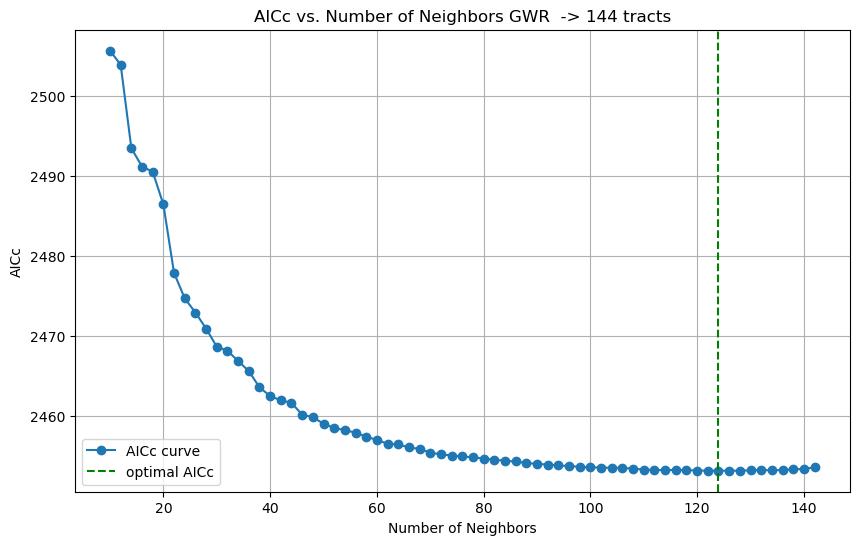

In [84]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(bwvalue, aicc_gwr, marker='o', label='AICc curve')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.legend()
plt.title('AICc vs. Number of Neighbors GWR  -> 144 tracts')
plt.grid(True)
plt.show()

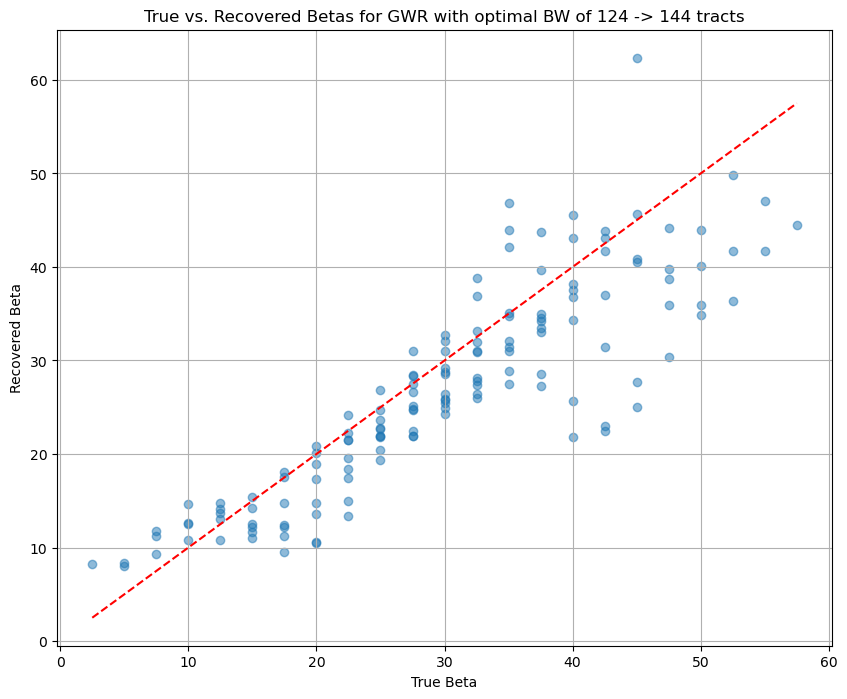

In [85]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, params[0].ravel(), alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f"True vs. Recovered Betas for GWR with optimal BW of {min(dict_aicc, key=dict_aicc.get)} -> 144 tracts")
plt.grid(True)
plt.show()

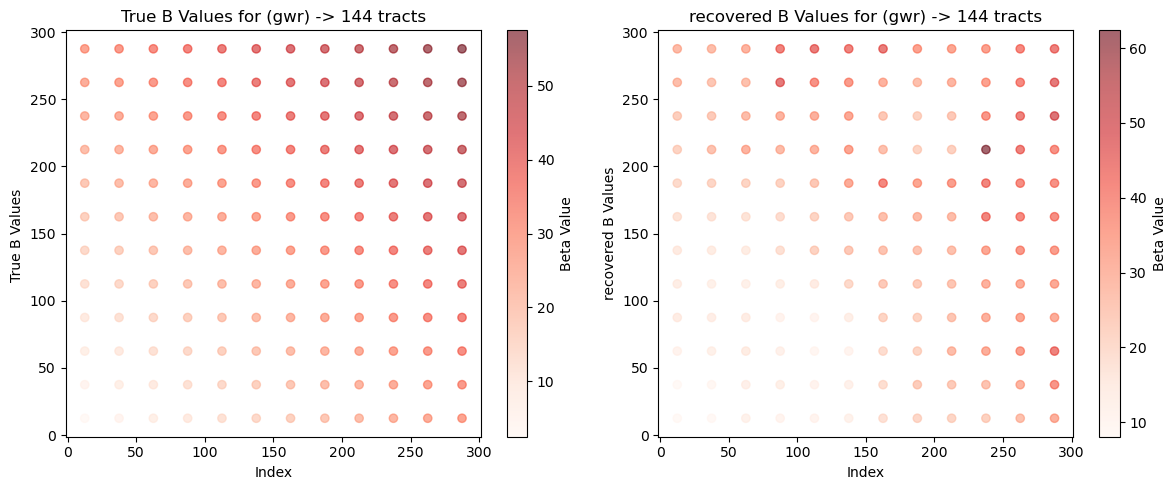

In [86]:
plot_true_and_recovered(B, params[0], loc1, name='(gwr) -> 144 tracts')

In [87]:
B.min(), B.max()

(2.5, 57.5)

In [88]:
params[0].min(), params[0].max()

(8.07374444042943, 62.36855168994557)

### Further increasing aggregation by reducing the number of tracts to 100 (10by10 squares). It was previously 144 

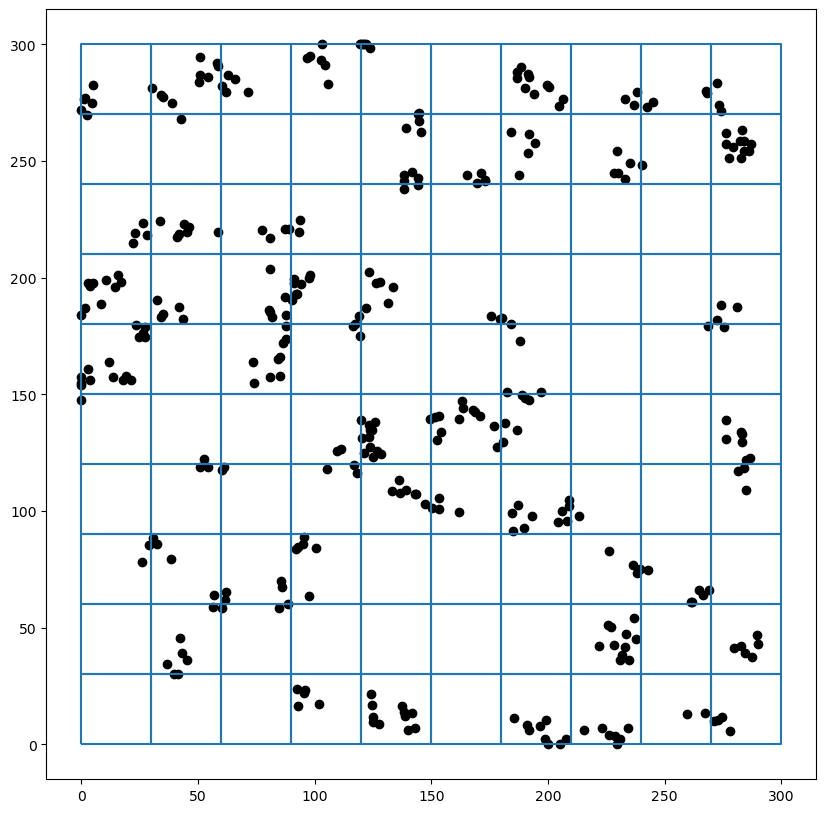

In [89]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 30, 30  # Creates a 30x30 grid, resulting in 100 tracts cell divisions
tracts_gdf = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

# Simulate S2

def simulate_clustered_S2(num_points, num_clusters, cluster_std=5, x_range=(0, 300), y_range=(0, 300), random_state=None):
    """
    Simulates clustered points and returns corresponding S2 values and locations.

    Parameters:
    - num_points: total number of points to generate
    - num_clusters: number of spatial clusters to create
    - cluster_std: standard deviation of clusters (controls spread of points)
    - x_range, y_range: bounds for the spatial area (min, max values for x and y)

    Returns:
    - S2: array of S2 values (normally distributed)
    - locations: array of [x, y] coordinates for each point
    """
    
    if random_state is not None:
        np.random.seed(random_state)
    # Generate clustered points using sklearn's make_blobs function
    centers = np.random.uniform(low=x_range[0], high=x_range[1], size=(num_clusters, 2))
    locations, _ = make_blobs(n_samples=num_points, centers=centers, cluster_std=cluster_std)
    
    # Clip points to fit within the study area bounds (if needed)
    locations[:, 0] = np.clip(locations[:, 0], x_range[0], x_range[1])
    locations[:, 1] = np.clip(locations[:, 1], y_range[0], y_range[1])
    
    # Generate S2 values
    S2 = np.random.normal(50, 30, num_points)
    
    return S2, locations

S2, loc2 = simulate_clustered_S2(350, num_clusters=65, cluster_std=4, random_state=12)

tracts_gdf.boundary.plot(figsize=(10, 10))
# tracts_gdf.geometry.centroid.plot()
plt.scatter(loc2[:,0], loc2[:,1], color='k')

S1 = tracts_gdf
S2 = S2
loc1 = np.array([[point.x, point.y] for point in S1.geometry.centroid])
loc2 = loc2


B = create_beta_surface(loc1, heterogeneity='low')

# B  = uniform(loc1)


# Generate y values
nbrs_S2 = NearestNeighbors(n_neighbors=len(S1)).fit(loc2)
smoothed_S2_to_S1 = np.zeros(len(S1))
for i in range(len(S1)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
    smoothed_S2_to_S1[i] = np.mean(S2[indices_S1_to_S2[0]])

y = B * smoothed_S2_to_S1

In [90]:
len(S1), len(y), len(S2)

(100, 100, 350)

In [91]:
# Define range for number of neighbors
neighbors_values = list(range(2, len(S1), 2))
best_aicc = float('inf')
best_neighbors = None
recovered_betas_best = None

aicc_values = []
enp_values = []

# Iterate over neighbor values
for n_neighbors in neighbors_values:
    recovered_betas, aicc, enp = perform_local_regression(n_neighbors, loc1, loc2, S2, y)
    aicc_values.append(aicc)
    enp_values.append(enp)
    if aicc < best_aicc:
        best_aicc = aicc
        best_neighbors = n_neighbors
        recovered_betas_best = recovered_betas

print(f"Optimal number of neighbors: {best_neighbors}")
print(f"Best AICc: {best_aicc:.2f}")

Optimal number of neighbors: 22
Best AICc: 1384.72


In [92]:
dict_aicc = dict(zip(neighbors_values, aicc_values))
min(dict_aicc, key=dict_aicc.get)

22

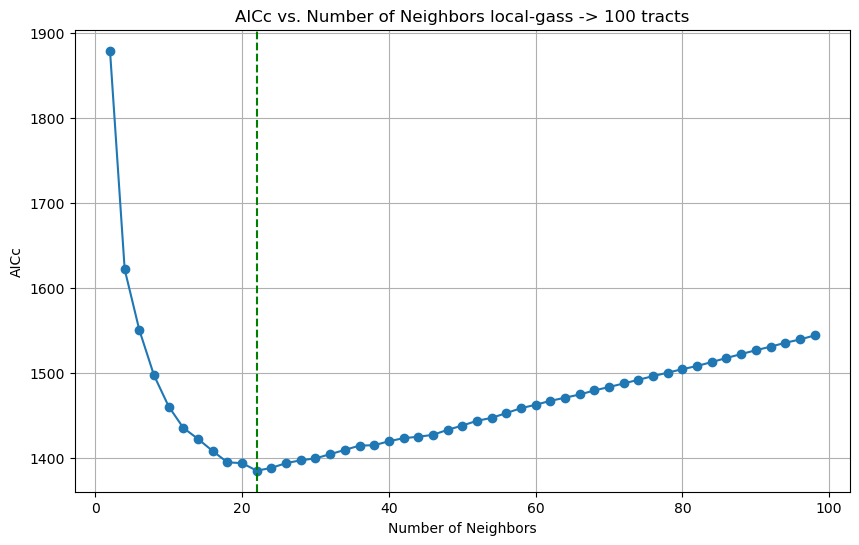

In [93]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, aicc_values, marker='o')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title('AICc vs. Number of Neighbors local-gass -> 100 tracts')
plt.grid(True)
plt.show()

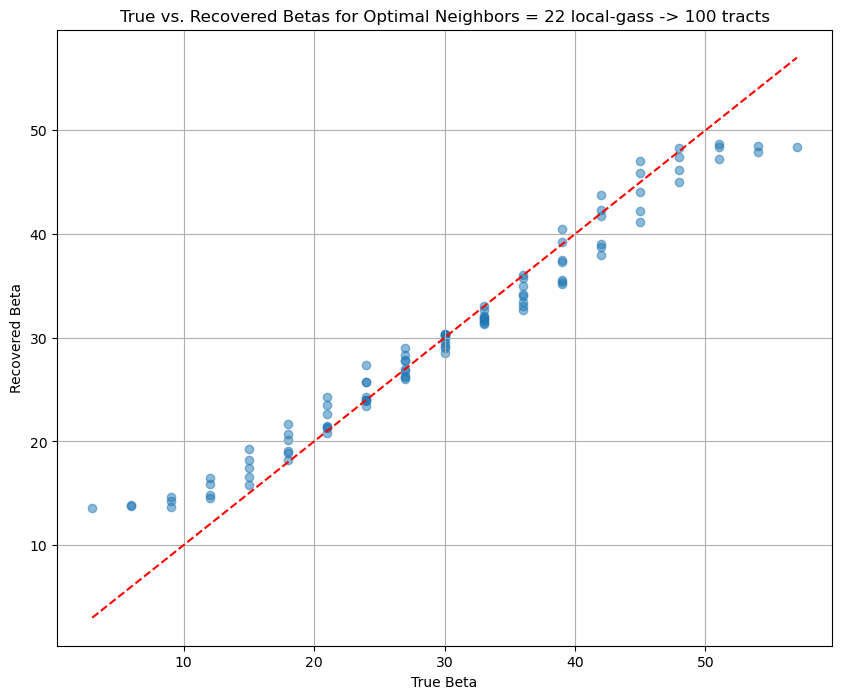

In [94]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, recovered_betas_best, alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors} local-gass -> 100 tracts')
plt.grid(True)
plt.show()

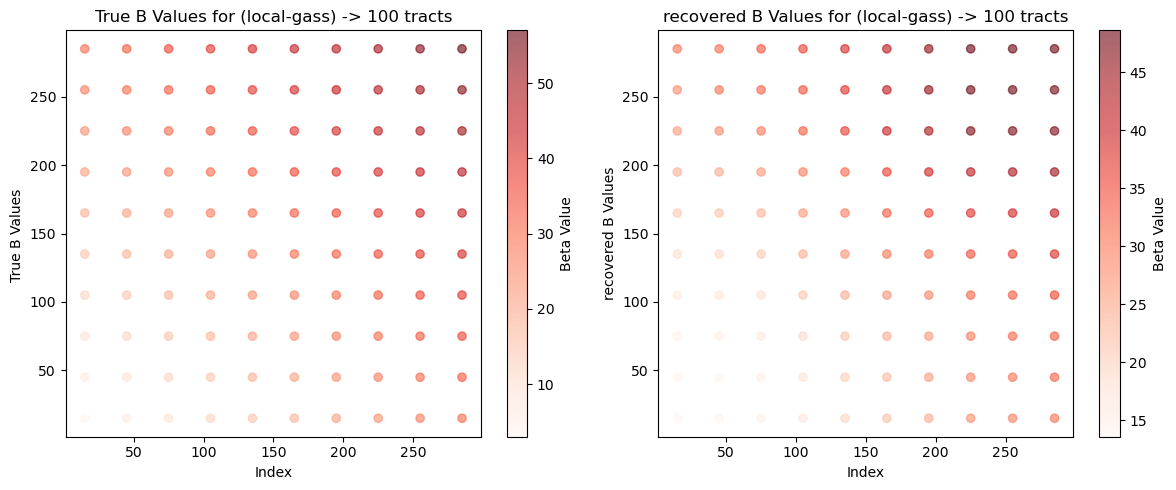

In [95]:
plot_true_and_recovered(B, recovered_betas_best, loc1, name='(local-gass) -> 100 tracts')

In [96]:
B

array([ 3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.,  6.,  9., 12.,
       15., 18., 21., 24., 27., 30., 33.,  9., 12., 15., 18., 21., 24.,
       27., 30., 33., 36., 12., 15., 18., 21., 24., 27., 30., 33., 36.,
       39., 15., 18., 21., 24., 27., 30., 33., 36., 39., 42., 18., 21.,
       24., 27., 30., 33., 36., 39., 42., 45., 21., 24., 27., 30., 33.,
       36., 39., 42., 45., 48., 24., 27., 30., 33., 36., 39., 42., 45.,
       48., 51., 27., 30., 33., 36., 39., 42., 45., 48., 51., 54., 30.,
       33., 36., 39., 42., 45., 48., 51., 54., 57.])

In [97]:
recovered_betas_best.round(1)

array([13.6, 13.8, 14.2, 15.8, 18.2, 20.7, 23.5, 25.7, 27.7, 30.2, 13.9,
       13.7, 14.6, 16.5, 19.1, 21.5, 24.3, 27.8, 30.2, 31.4, 14.6, 14.9,
       15.8, 18.2, 20.8, 23.4, 26.2, 29.8, 32. , 33.4, 16.5, 17.4, 18.9,
       21.3, 23.9, 26.3, 29.2, 32.7, 34.2, 35.4, 19.3, 20.2, 21.4, 24. ,
       26.7, 29. , 31.4, 36. , 37.3, 38.7, 21.7, 22.7, 24. , 27. , 30.1,
       33.1, 35.8, 40.4, 41.8, 42.2, 24.3, 25.7, 26.1, 28.5, 31.6, 35. ,
       39.2, 43.7, 45.9, 46.2, 27.3, 28.3, 29.5, 31.8, 34.1, 37.5, 42.3,
       47.1, 48.3, 48.6, 29. , 30.3, 31.8, 33.1, 35.6, 39. , 44.1, 47.4,
       48.4, 48.5, 30.3, 32.1, 32.7, 35.2, 38. , 41.2, 45. , 47.3, 47.9,
       48.4])

In [98]:
B.min(), B.max()

(3.0, 57.0)

In [99]:
recovered_betas_best.min(), recovered_betas_best.max()

(13.56838844366118, 48.63306481795952)

<br />

#### Aggregating points into census tracts for GWR

For GWR, one has to aggregate points into tracts every time it is increased

In [100]:
df_S2 = gpd.GeoDataFrame({'S2': S2}, geometry=gpd.points_from_xy(loc2[:, 0], loc2[:, 1]))
joined = gpd.sjoin(df_S2, S1, how='inner', predicate='within')
sX = joined.groupby('tract_id').agg({'S2': ['mean']})
sX.columns = ['_'.join(col).strip() for col in sX.columns.values]
sX = sX.reset_index()

# merge back with tracts (S1)
sX1 = S1.merge(sX, on='tract_id', how='left')
sX1.fillna({'S2_mean': 0.00001}, inplace=True)

In [101]:
sX1.head()

tract_id                                           geometry    S2_mean
0         0  POLYGON ((0.000 0.000, 30.000 0.000, 30.000 30...   0.000010
1         1  POLYGON ((0.000 30.000, 30.000 30.000, 30.000 ...   0.000010
2         2  POLYGON ((0.000 60.000, 30.000 60.000, 30.000 ...  77.715254
3         3  POLYGON ((0.000 90.000, 30.000 90.000, 30.000 ...   0.000010
4         4  POLYGON ((0.000 120.000, 30.000 120.000, 30.00...   0.000010

##### Specify GWR parameters

In [102]:
gwr_X  = sX1['S2_mean'].values.reshape(-1,1)
gwr_y = y.reshape(-1, 1)
coords = np.array([[point.x, point.y] for point in sX1['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((100, 1), (100, 1))

In [103]:
aicc_gwr = []
params = []
ENP = []
bwvalue = list(range(10, len(loc1), 2))
for i in bwvalue:
    model = GWR(coords, gwr_y, gwr_X, i, constant=False).fit()
    params.append(model.params)
    aicc_gwr.append(model.aicc)
    ENP.append(model.ENP)

In [104]:
dict_aicc = dict(zip(bwvalue, aicc_gwr))

In [105]:
min(dict_aicc, key=dict_aicc.get)

76

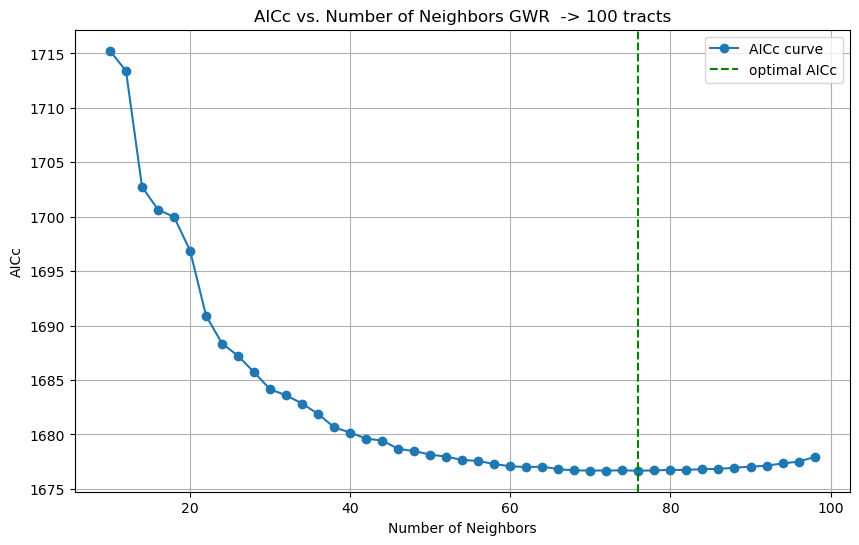

In [106]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(bwvalue, aicc_gwr, marker='o', label='AICc curve')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.legend()
plt.title('AICc vs. Number of Neighbors GWR  -> 100 tracts')
plt.grid(True)
plt.show()

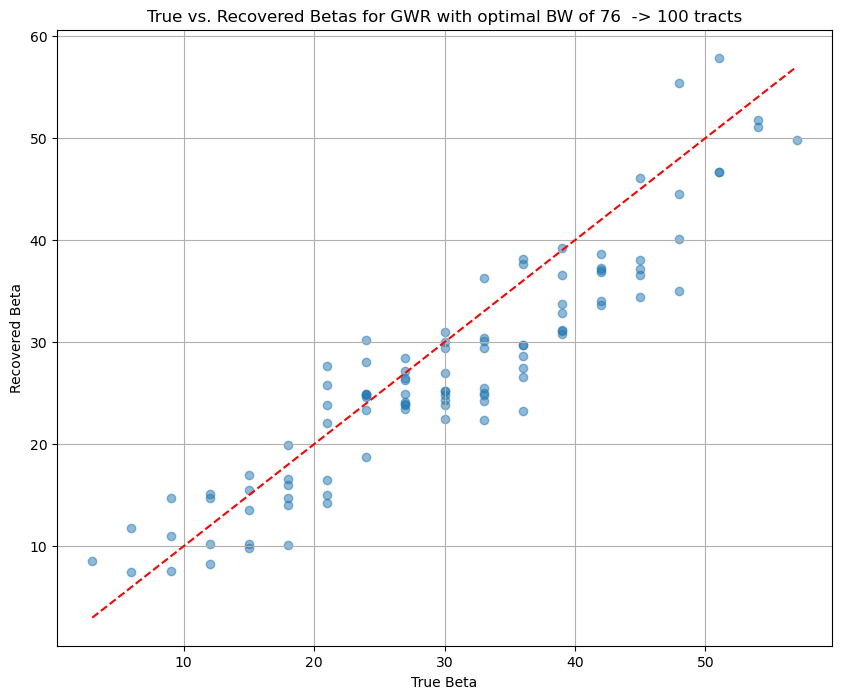

In [107]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, params[0].ravel(), alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f"True vs. Recovered Betas for GWR with optimal BW of {min(dict_aicc, key=dict_aicc.get)}  -> 100 tracts")
plt.grid(True)
plt.show()

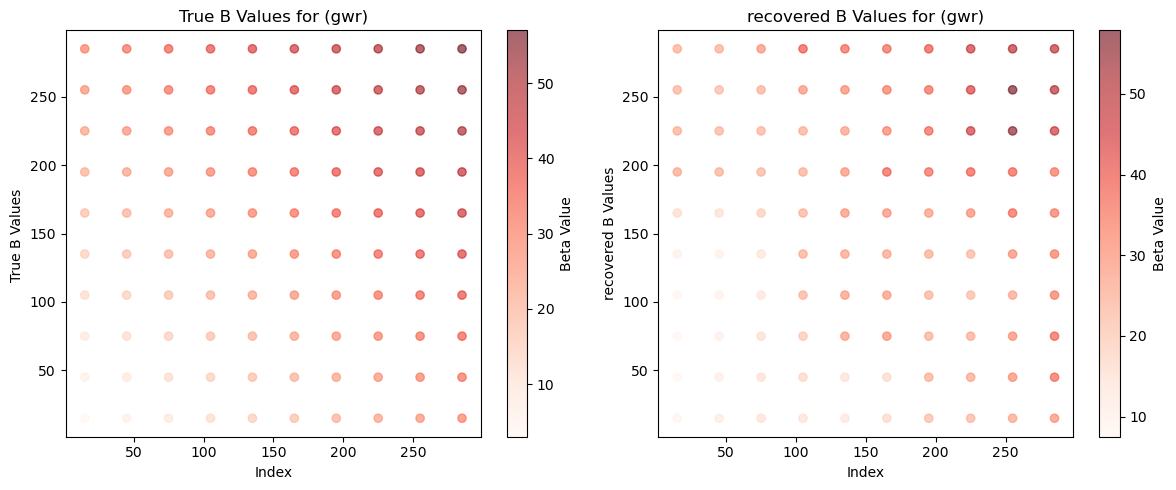

In [108]:
plot_true_and_recovered(B, params[0], loc1, name='(gwr)')

In [109]:
B.min(), B.max()

(3.0, 57.0)

In [110]:
params[0].min(), params[0].max()

(7.50836928763901, 57.870917612990134)

### Further increasing aggregation by reducing the number of tracts to 81. It was previously 100 

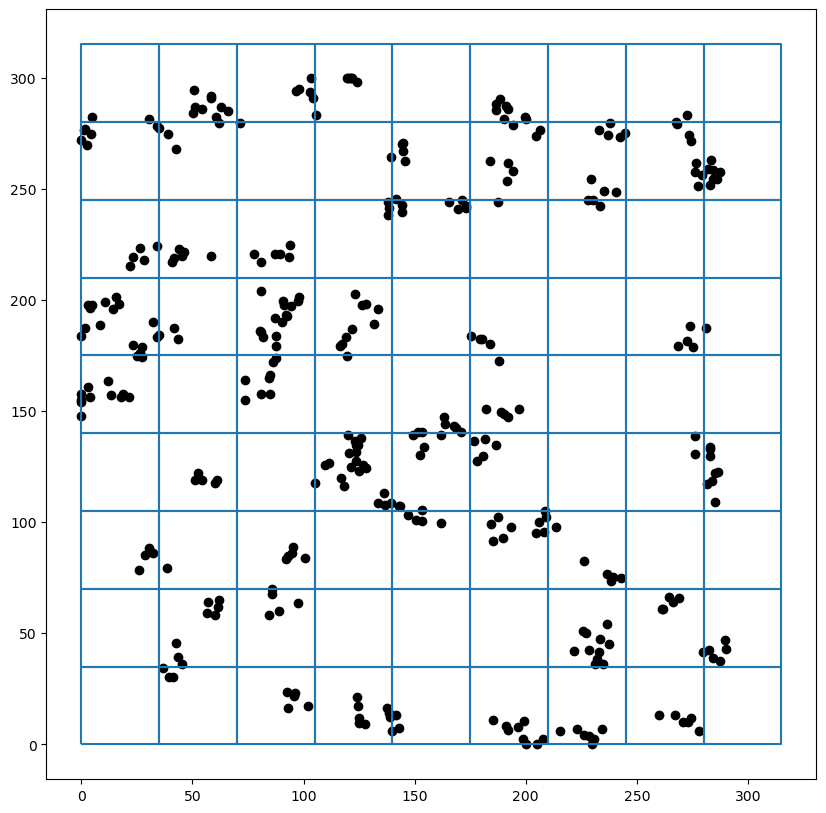

In [111]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 35, 35  # Creates a 25x25 grid, resulting in 144 tracts cell divisions
tracts_gdf = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

# Simulate S2

def simulate_clustered_S2(num_points, num_clusters, cluster_std=5, x_range=(0, 300), y_range=(0, 300), random_state=None):
    """
    Simulates clustered points and returns corresponding S2 values and locations.

    Parameters:
    - num_points: total number of points to generate
    - num_clusters: number of spatial clusters to create
    - cluster_std: standard deviation of clusters (controls spread of points)
    - x_range, y_range: bounds for the spatial area (min, max values for x and y)

    Returns:
    - S2: array of S2 values (normally distributed)
    - locations: array of [x, y] coordinates for each point
    """
    
    if random_state is not None:
        np.random.seed(random_state)
    # Generate clustered points using sklearn's make_blobs function
    centers = np.random.uniform(low=x_range[0], high=x_range[1], size=(num_clusters, 2))
    locations, _ = make_blobs(n_samples=num_points, centers=centers, cluster_std=cluster_std)
    
    # Clip points to fit within the study area bounds (if needed)
    locations[:, 0] = np.clip(locations[:, 0], x_range[0], x_range[1])
    locations[:, 1] = np.clip(locations[:, 1], y_range[0], y_range[1])
    
    # Generate S2 values
    S2 = np.random.normal(50, 30, num_points)
    
    return S2, locations

S2, loc2 = simulate_clustered_S2(350, num_clusters=65, cluster_std=4, random_state=12)

tracts_gdf.boundary.plot(figsize=(10, 10))
# tracts_gdf.geometry.centroid.plot()
plt.scatter(loc2[:,0], loc2[:,1], color='k')

S1 = tracts_gdf
S2 = S2
loc1 = np.array([[point.x, point.y] for point in S1.geometry.centroid])
loc2 = loc2


B = create_beta_surface(loc1, heterogeneity='low')

# B = uniform(loc1)

# Generate y values
nbrs_S2 = NearestNeighbors(n_neighbors=len(S1)).fit(loc2)
smoothed_S2_to_S1 = np.zeros(len(S1))
for i in range(len(S1)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
    smoothed_S2_to_S1[i] = np.mean(S2[indices_S1_to_S2[0]])

y = B * smoothed_S2_to_S1

In [112]:
len(S1), len(y), len(S2)

(81, 81, 350)

In [113]:
# Define range for number of neighbors
neighbors_values = list(range(2, len(S1), 2))
best_aicc = float('inf')
best_neighbors = None
recovered_betas_best = None

aicc_values = []
enp_values = []

# Iterate over neighbor values
for n_neighbors in neighbors_values:
    recovered_betas, aicc, enp = perform_local_regression(n_neighbors, loc1, loc2, S2, y)
    aicc_values.append(aicc)
    enp_values.append(enp)
    if aicc < best_aicc:
        best_aicc = aicc
        best_neighbors = n_neighbors
        recovered_betas_best = recovered_betas

print(f"Optimal number of neighbors: {best_neighbors}")
print(f"Best AICc: {best_aicc:.2f}")

Optimal number of neighbors: 22
Best AICc: 1139.50


In [114]:
dict_aicc = dict(zip(neighbors_values, aicc_values))
min(dict_aicc, key=dict_aicc.get)

22

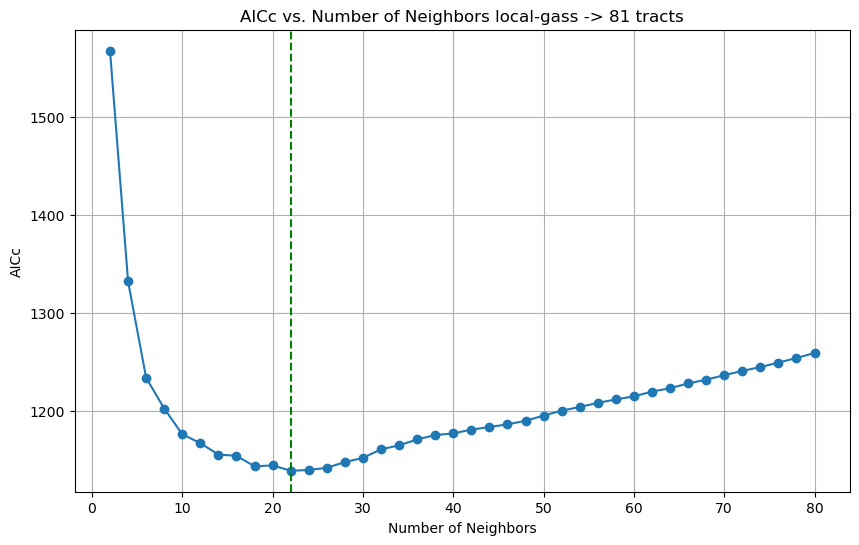

In [115]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, aicc_values, marker='o')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title('AICc vs. Number of Neighbors local-gass -> 81 tracts')
plt.grid(True)
plt.show()

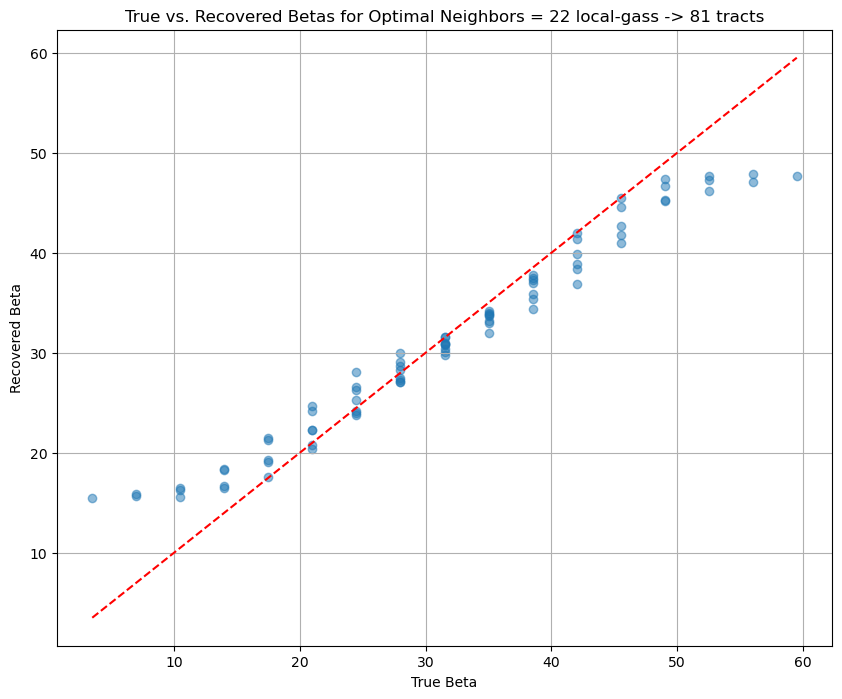

In [116]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, recovered_betas_best, alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors} local-gass -> 81 tracts')
plt.grid(True)
plt.show()

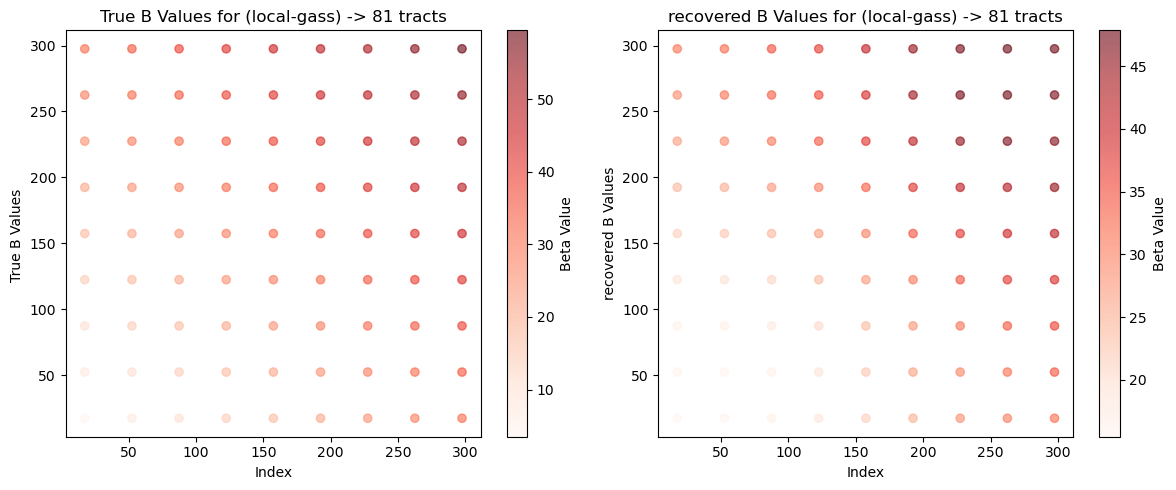

In [117]:
plot_true_and_recovered(B, recovered_betas_best, loc1, name='(local-gass) -> 81 tracts')

In [118]:
B

array([ 3.5,  7. , 10.5, 14. , 17.5, 21. , 24.5, 28. , 31.5,  7. , 10.5,
       14. , 17.5, 21. , 24.5, 28. , 31.5, 35. , 10.5, 14. , 17.5, 21. ,
       24.5, 28. , 31.5, 35. , 38.5, 14. , 17.5, 21. , 24.5, 28. , 31.5,
       35. , 38.5, 42. , 17.5, 21. , 24.5, 28. , 31.5, 35. , 38.5, 42. ,
       45.5, 21. , 24.5, 28. , 31.5, 35. , 38.5, 42. , 45.5, 49. , 24.5,
       28. , 31.5, 35. , 38.5, 42. , 45.5, 49. , 52.5, 28. , 31.5, 35. ,
       38.5, 42. , 45.5, 49. , 52.5, 56. , 31.5, 35. , 38.5, 42. , 45.5,
       49. , 52.5, 56. , 59.5])

In [119]:
recovered_betas_best

array([15.462, 15.899, 16.427, 18.412, 21.301, 24.138, 26.546, 28.262,
       30.856, 15.631, 15.575, 16.627, 19.303, 22.321, 25.274, 28.634,
       30.832, 31.958, 16.243, 16.473, 17.59 , 20.805, 24.161, 27.233,
       30.75 , 33.017, 34.371, 18.319, 19.055, 20.396, 23.927, 27.033,
       30.117, 33.783, 35.416, 36.825, 21.474, 22.27 , 23.734, 27.032,
       29.758, 33.125, 37.449, 38.852, 40.924, 24.685, 26.284, 27.442,
       30.355, 34.   , 37.776, 41.926, 44.551, 45.264, 28.03 , 29.083,
       31.006, 34.194, 37.24 , 41.371, 45.447, 47.416, 47.23 , 29.966,
       31.533, 33.707, 37.017, 39.886, 42.721, 46.687, 47.682, 47.861,
       31.543, 33.865, 35.89 , 38.406, 41.804, 45.141, 46.204, 47.042,
       47.688])

In [120]:
B.min(), B.max()

(3.5, 59.5)

In [121]:
recovered_betas_best.min(), recovered_betas_best.max()

(15.462229195104253, 47.861434718139016)

<br />

#### Aggregating points into census tracts for GWR

For GWR, one has to aggregate points into tracts every time it is increased

In [122]:
df_S2 = gpd.GeoDataFrame({'S2': S2}, geometry=gpd.points_from_xy(loc2[:, 0], loc2[:, 1]))
joined = gpd.sjoin(df_S2, S1, how='inner', predicate='within')
sX = joined.groupby('tract_id').agg({'S2': ['mean']})
sX.columns = ['_'.join(col).strip() for col in sX.columns.values]
sX = sX.reset_index()

# merge back with tracts (S1)
sX1 = S1.merge(sX, on='tract_id', how='left')
sX1.fillna({'S2_mean': 0.00001}, inplace=True)

In [123]:
sX1.head()

tract_id                                           geometry    S2_mean
0         0  POLYGON ((0.000 0.000, 35.000 0.000, 35.000 35...   0.000010
1         1  POLYGON ((0.000 35.000, 35.000 35.000, 35.000 ...   0.000010
2         2  POLYGON ((0.000 70.000, 35.000 70.000, 35.000 ...  46.188607
3         3  POLYGON ((0.000 105.000, 35.000 105.000, 35.00...   0.000010
4         4  POLYGON ((0.000 140.000, 35.000 140.000, 35.00...  55.918892

##### Specify GWR parameters

In [124]:
gwr_X  = sX1['S2_mean'].values.reshape(-1,1)
gwr_y = y.reshape(-1, 1)
coords = np.array([[point.x, point.y] for point in sX1['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((81, 1), (81, 1))

In [125]:
aicc_gwr = []
params = []
ENP = []
bwvalue = list(range(10, len(loc1), 2))
for i in bwvalue:
    model = GWR(coords, gwr_y, gwr_X, i, constant=False).fit()
    params.append(model.params)
    aicc_gwr.append(model.aicc)
    ENP.append(model.ENP)

In [126]:
dict_aicc = dict(zip(bwvalue, aicc_gwr))

In [127]:
min(dict_aicc, key=dict_aicc.get)

74

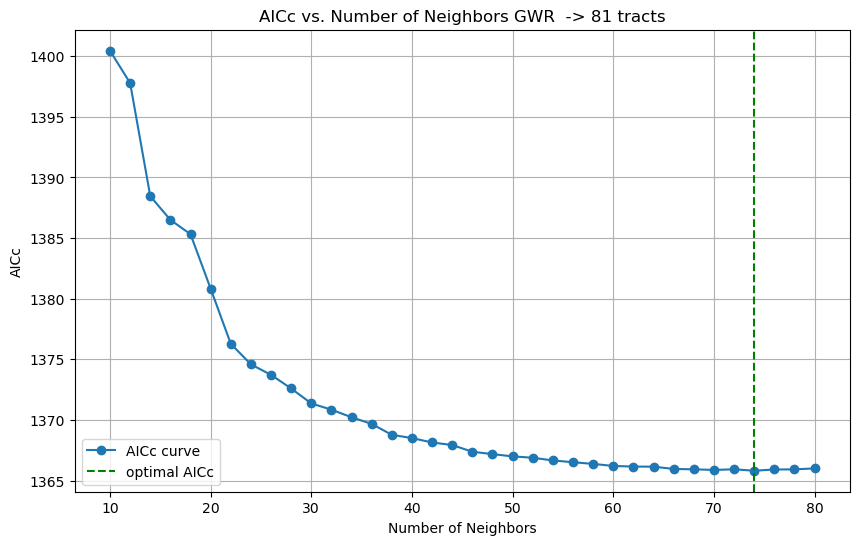

In [128]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(bwvalue, aicc_gwr, marker='o', label='AICc curve')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.legend()
plt.title('AICc vs. Number of Neighbors GWR  -> 81 tracts')
plt.grid(True)
plt.show()

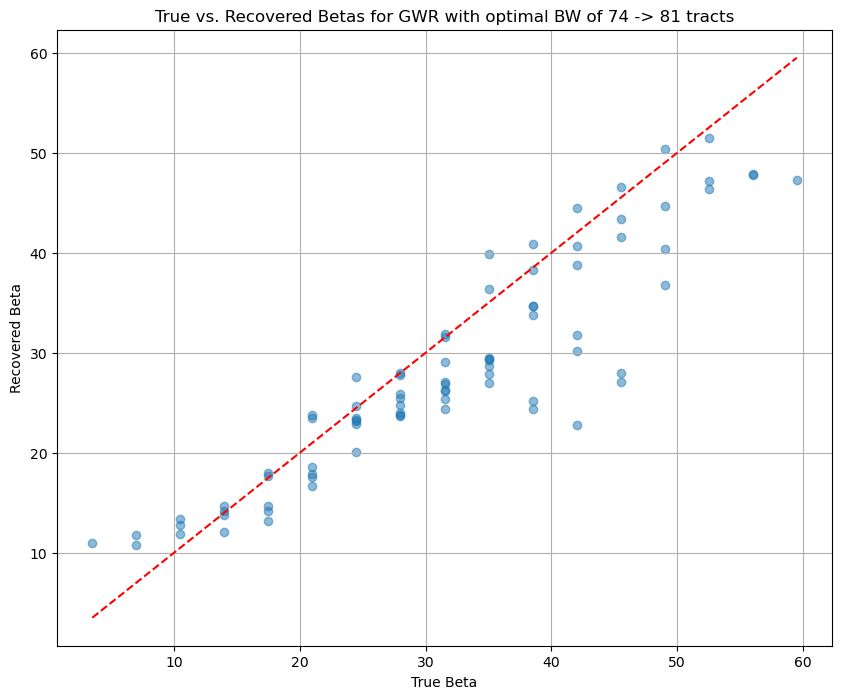

In [129]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, params[0].ravel(), alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f"True vs. Recovered Betas for GWR with optimal BW of {min(dict_aicc, key=dict_aicc.get)} -> 81 tracts")
plt.grid(True)
plt.show()

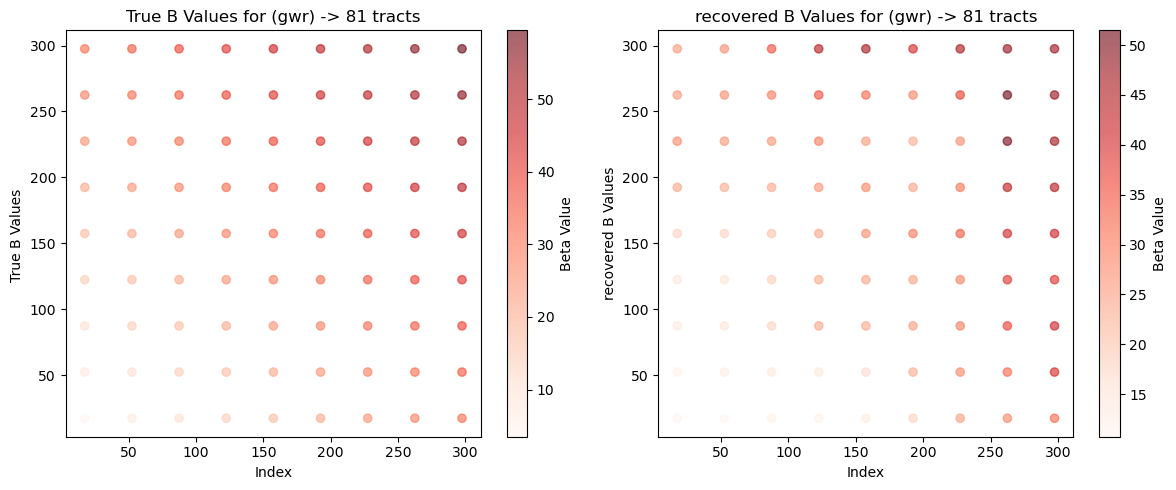

In [130]:
plot_true_and_recovered(B, params[0], loc1, name='(gwr) -> 81 tracts')

In [131]:
B

array([ 3.5,  7. , 10.5, 14. , 17.5, 21. , 24.5, 28. , 31.5,  7. , 10.5,
       14. , 17.5, 21. , 24.5, 28. , 31.5, 35. , 10.5, 14. , 17.5, 21. ,
       24.5, 28. , 31.5, 35. , 38.5, 14. , 17.5, 21. , 24.5, 28. , 31.5,
       35. , 38.5, 42. , 17.5, 21. , 24.5, 28. , 31.5, 35. , 38.5, 42. ,
       45.5, 21. , 24.5, 28. , 31.5, 35. , 38.5, 42. , 45.5, 49. , 24.5,
       28. , 31.5, 35. , 38.5, 42. , 45.5, 49. , 52.5, 28. , 31.5, 35. ,
       38.5, 42. , 45.5, 49. , 52.5, 56. , 31.5, 35. , 38.5, 42. , 45.5,
       49. , 52.5, 56. , 59.5])

In [132]:
params[0].flatten()

array([11.008, 11.764, 13.346, 14.171, 18.006, 23.777, 27.562, 25.504,
       25.37 , 10.736, 12.756, 14.7  , 14.718, 17.596, 23.262, 25.874,
       26.887, 26.981, 11.881, 13.722, 17.681, 18.531, 20.093, 23.63 ,
       26.15 , 29.257, 34.67 , 12.047, 14.194, 23.501, 23.198, 23.782,
       26.3  , 29.35 , 34.677, 44.441, 13.167, 16.663, 23.498, 24.   ,
       27.027, 27.903, 25.171, 31.782, 46.55 , 17.893, 22.898, 24.783,
       24.408, 29.504, 24.381, 22.735, 27.943, 40.398, 24.711, 27.815,
       29.068, 28.634, 33.796, 30.22 , 27.071, 36.73 , 46.348, 28.021,
       31.91 , 36.388, 38.238, 40.658, 43.365, 50.398, 51.479, 47.887,
       31.6  , 39.913, 40.844, 38.731, 41.556, 44.689, 47.127, 47.78 ,
       47.317])

In [133]:
B.min(), B.max()

(3.5, 59.5)

In [134]:
params[0].min(), params[0].max()

(10.736118108245098, 51.47859147038953)

### Further increasing aggregation by reducing the number of tracts to 64. It was previously 81 

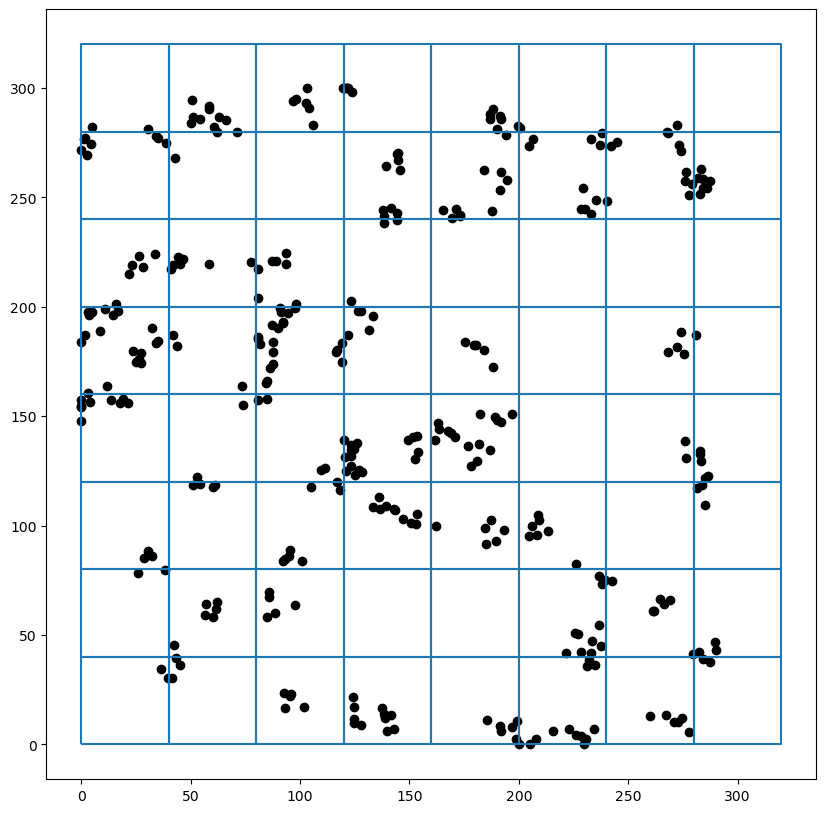

In [135]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 40, 40  # Creates a 25x25 grid, resulting in 144 tracts cell divisions
tracts_gdf = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

# Simulate S2

def simulate_clustered_S2(num_points, num_clusters, cluster_std=5, x_range=(0, 300), y_range=(0, 300), random_state=None):
    """
    Simulates clustered points and returns corresponding S2 values and locations.

    Parameters:
    - num_points: total number of points to generate
    - num_clusters: number of spatial clusters to create
    - cluster_std: standard deviation of clusters (controls spread of points)
    - x_range, y_range: bounds for the spatial area (min, max values for x and y)

    Returns:
    - S2: array of S2 values (normally distributed)
    - locations: array of [x, y] coordinates for each point
    """
    
    if random_state is not None:
        np.random.seed(random_state)
    # Generate clustered points using sklearn's make_blobs function
    centers = np.random.uniform(low=x_range[0], high=x_range[1], size=(num_clusters, 2))
    locations, _ = make_blobs(n_samples=num_points, centers=centers, cluster_std=cluster_std)
    
    # Clip points to fit within the study area bounds (if needed)
    locations[:, 0] = np.clip(locations[:, 0], x_range[0], x_range[1])
    locations[:, 1] = np.clip(locations[:, 1], y_range[0], y_range[1])
    
    # Generate S2 values
    S2 = np.random.normal(50, 30, num_points)
    
    return S2, locations

S2, loc2 = simulate_clustered_S2(350, num_clusters=65, cluster_std=4, random_state=12)

tracts_gdf.boundary.plot(figsize=(10, 10))
# tracts_gdf.geometry.centroid.plot()
plt.scatter(loc2[:,0], loc2[:,1], color='k')

S1 = tracts_gdf
S2 = S2
loc1 = np.array([[point.x, point.y] for point in S1.geometry.centroid])
loc2 = loc2


B = create_beta_surface(loc1, heterogeneity='low')

# B = uniform(loc1)

# Generate y values
nbrs_S2 = NearestNeighbors(n_neighbors=len(S1)).fit(loc2)
smoothed_S2_to_S1 = np.zeros(len(S1))
for i in range(len(S1)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
    smoothed_S2_to_S1[i] = np.mean(S2[indices_S1_to_S2[0]])

y = B * smoothed_S2_to_S1

In [136]:
len(S1), len(y), len(S2)

(64, 64, 350)

In [137]:
# Define range for number of neighbors
neighbors_values = list(range(2, len(S1), 2))
best_aicc = float('inf')
best_neighbors = None
recovered_betas_best = None

aicc_values = []
enp_values = []

# Iterate over neighbor values
for n_neighbors in neighbors_values:
    recovered_betas, aicc, enp = perform_local_regression(n_neighbors, loc1, loc2, S2, y)
    aicc_values.append(aicc)
    enp_values.append(enp)
    if aicc < best_aicc:
        best_aicc = aicc
        best_neighbors = n_neighbors
        recovered_betas_best = recovered_betas

print(f"Optimal number of neighbors: {best_neighbors}")
print(f"Best AICc: {best_aicc:.2f}")

Optimal number of neighbors: 14
Best AICc: 909.10


In [138]:
dict_aicc = dict(zip(neighbors_values, aicc_values))
min(dict_aicc, key=dict_aicc.get)

14

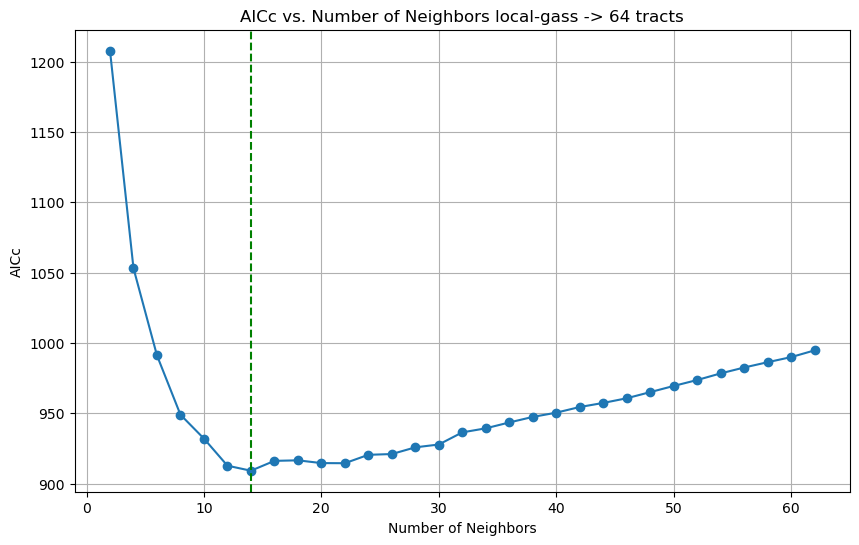

In [139]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, aicc_values, marker='o')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title('AICc vs. Number of Neighbors local-gass -> 64 tracts')
plt.grid(True)
plt.show()

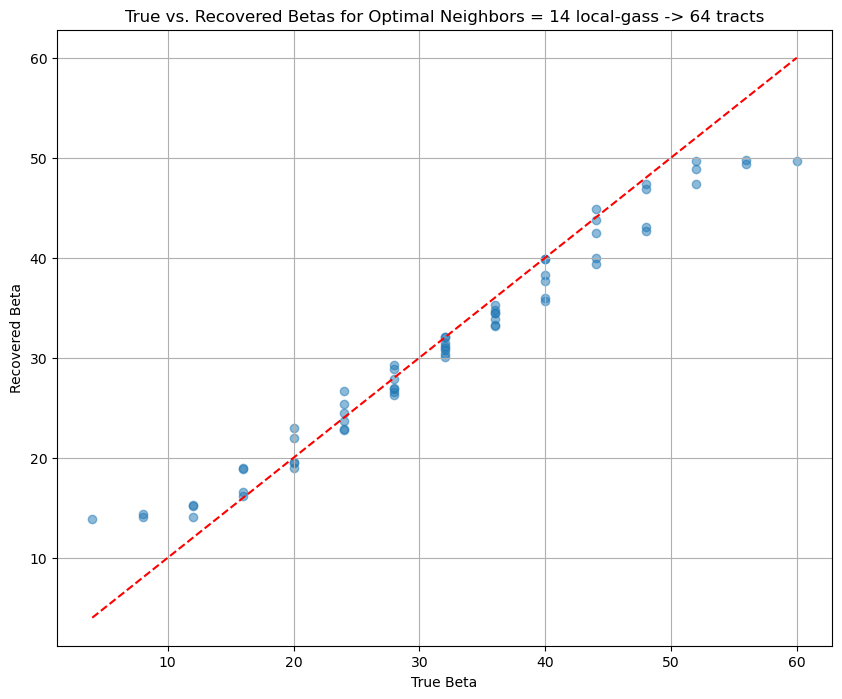

In [140]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, recovered_betas_best, alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors} local-gass -> 64 tracts')
plt.grid(True)
plt.show()

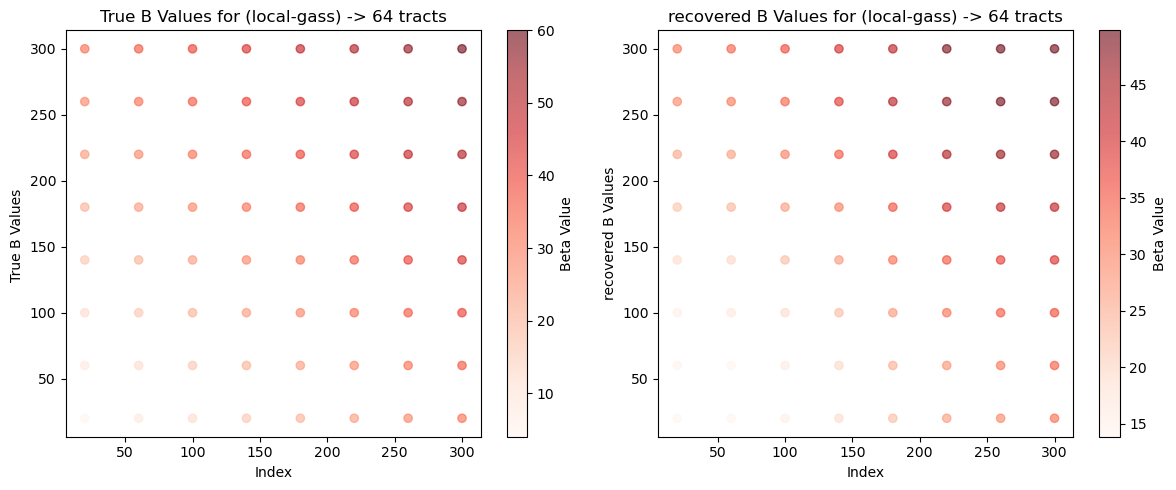

In [141]:
plot_true_and_recovered(B, recovered_betas_best, loc1, name='(local-gass) -> 64 tracts')

In [142]:
B

array([ 4.,  8., 12., 16., 20., 24., 28., 32.,  8., 12., 16., 20., 24.,
       28., 32., 36., 12., 16., 20., 24., 28., 32., 36., 40., 16., 20.,
       24., 28., 32., 36., 40., 44., 20., 24., 28., 32., 36., 40., 44.,
       48., 24., 28., 32., 36., 40., 44., 48., 52., 28., 32., 36., 40.,
       44., 48., 52., 56., 32., 36., 40., 44., 48., 52., 56., 60.])

In [143]:
recovered_betas_best

array([13.839, 14.347, 15.207, 18.835, 21.969, 25.335, 28.889, 31.19 ,
       14.118, 14.097, 16.583, 19.51 , 23.705, 26.254, 30.759, 33.321,
       15.291, 16.177, 18.955, 22.725, 26.589, 30.06 , 33.205, 36.002,
       18.944, 19.529, 22.882, 26.922, 30.386, 34.504, 38.32 , 39.96 ,
       22.923, 24.52 , 26.925, 32.083, 35.281, 39.889, 43.769, 43.084,
       26.72 , 27.84 , 31.511, 34.746, 39.877, 44.86 , 47.348, 48.888,
       29.228, 31.022, 34.443, 37.699, 42.438, 46.836, 49.656, 49.806,
       32.094, 33.827, 35.669, 39.4  , 42.713, 47.393, 49.361, 49.655])

In [144]:
B.min(), B.max()

(4.0, 60.0)

In [145]:
recovered_betas_best.min(), recovered_betas_best.max()

(13.838617087286165, 49.80596506078633)

#### Aggregating points into census tracts for GWR

For GWR, one has to aggregate points into tracts every time it is increased

In [146]:
df_S2 = gpd.GeoDataFrame({'S2': S2}, geometry=gpd.points_from_xy(loc2[:, 0], loc2[:, 1]))
joined = gpd.sjoin(df_S2, S1, how='inner', predicate='within')
sX = joined.groupby('tract_id').agg({'S2': ['mean']})
sX.columns = ['_'.join(col).strip() for col in sX.columns.values]
sX = sX.reset_index()

# merge back with tracts (S1)
sX1 = S1.merge(sX, on='tract_id', how='left')
sX1.fillna({'S2_mean': 0.000001}, inplace=True)

In [147]:
sX1.head()

tract_id                                           geometry    S2_mean
0         0  POLYGON ((0.000 0.000, 40.000 0.000, 40.000 40...  45.774427
1         1  POLYGON ((0.000 40.000, 40.000 40.000, 40.000 ...  61.045934
2         2  POLYGON ((0.000 80.000, 40.000 80.000, 40.000 ...  30.045136
3         3  POLYGON ((0.000 120.000, 40.000 120.000, 40.00...  54.246402
4         4  POLYGON ((0.000 160.000, 40.000 160.000, 40.00...  41.736295

##### Specify GWR parameters

In [148]:
gwr_X  = sX1['S2_mean'].values.reshape(-1,1)
gwr_y = y.reshape(-1, 1)
coords = np.array([[point.x, point.y] for point in sX1['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((64, 1), (64, 1))

In [149]:
aicc_gwr = []
params = []
ENP = []
bwvalue = list(range(10, len(loc1), 2))
for i in bwvalue:
    model = GWR(coords, gwr_y, gwr_X, i, constant=False).fit()
    params.append(model.params)
    aicc_gwr.append(model.aicc)
    ENP.append(model.ENP)

In [150]:
dict_aicc = dict(zip(bwvalue, aicc_gwr))

In [151]:
min(dict_aicc, key=dict_aicc.get)

50

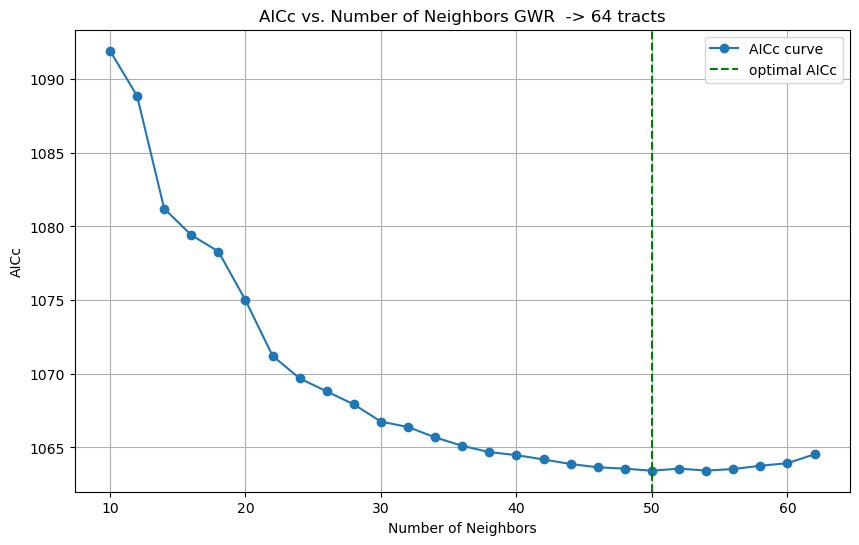

In [152]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(bwvalue, aicc_gwr, marker='o', label='AICc curve')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.legend()
plt.title('AICc vs. Number of Neighbors GWR  -> 64 tracts')
plt.grid(True)
plt.show()

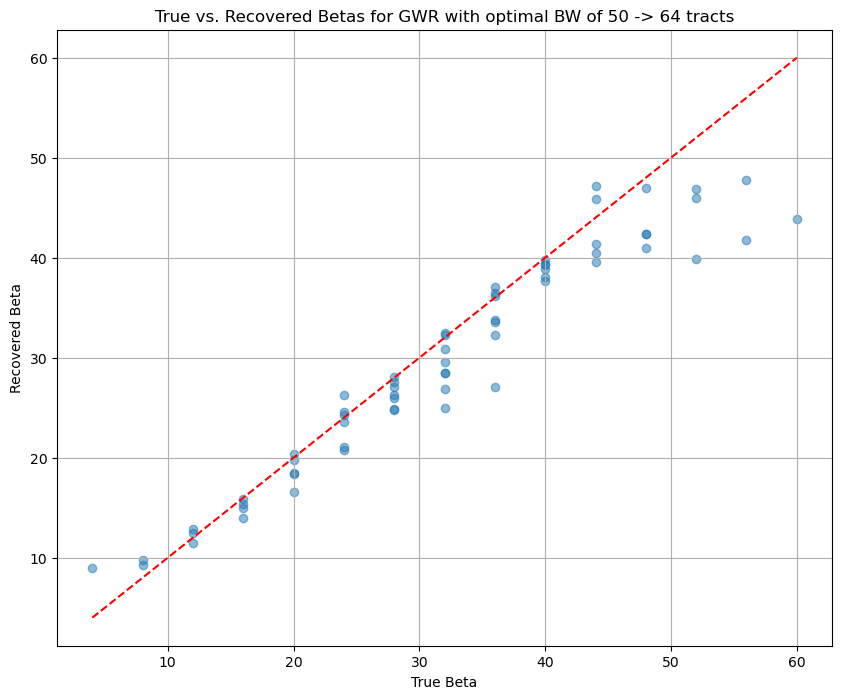

In [153]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, params[0].ravel(), alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f"True vs. Recovered Betas for GWR with optimal BW of {min(dict_aicc, key=dict_aicc.get)} -> 64 tracts")
plt.grid(True)
plt.show()

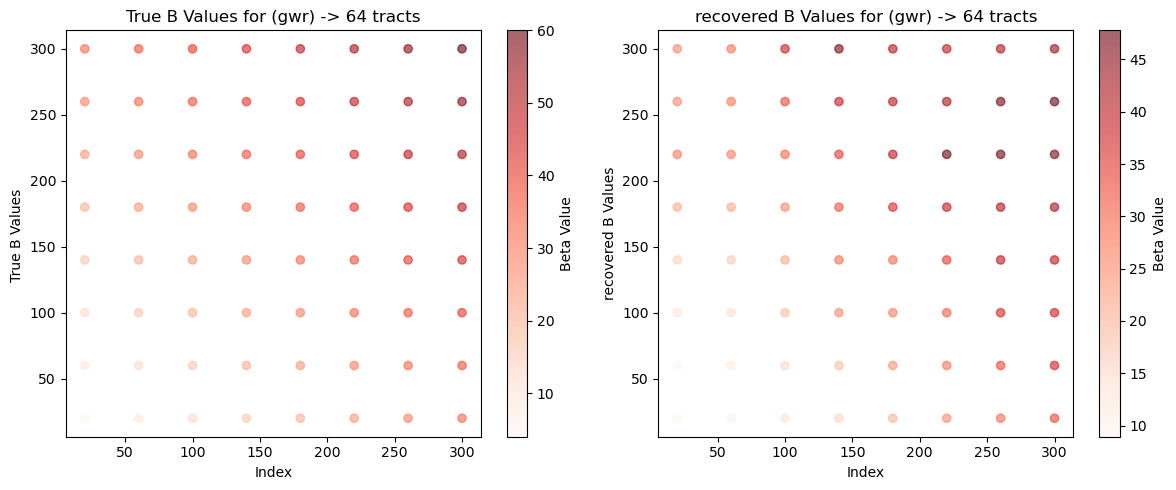

In [154]:
plot_true_and_recovered(B, params[0], loc1, name='(gwr) -> 64 tracts')

In [155]:
B

array([ 4.,  8., 12., 16., 20., 24., 28., 32.,  8., 12., 16., 20., 24.,
       28., 32., 36., 12., 16., 20., 24., 28., 32., 36., 40., 16., 20.,
       24., 28., 32., 36., 40., 44., 20., 24., 28., 32., 36., 40., 44.,
       48., 24., 28., 32., 36., 40., 44., 48., 52., 28., 32., 36., 40.,
       44., 48., 52., 56., 32., 36., 40., 44., 48., 52., 56., 60.])

In [156]:
params[0].flatten()

array([ 8.937,  9.313, 12.447, 15.873, 20.399, 26.315, 24.854, 25.018,
        9.819, 11.502, 14.017, 16.543, 21.03 , 25.993, 26.852, 27.052,
       12.876, 14.928, 18.464, 20.784, 24.811, 28.483, 32.294, 38.064,
       15.324, 18.379, 24.523, 27.597, 30.871, 33.743, 38.89 , 45.893,
       19.788, 23.618, 26.288, 28.497, 36.14 , 39.324, 40.454, 40.993,
       24.287, 27.113, 29.599, 33.607, 39.302, 47.203, 42.399, 39.826,
       28.063, 32.261, 36.472, 39.813, 41.409, 46.923, 46.825, 41.812,
       32.466, 37.078, 37.66 , 39.543, 42.354, 45.974, 47.781, 43.892])

In [157]:
B.min(), B.max()

(4.0, 60.0)

In [158]:
params[0].min(), params[0].max()

(8.937405197270726, 47.7813358458024)

### Further increasing aggregation by reducing the number of tracts to 49. It was previously 64 

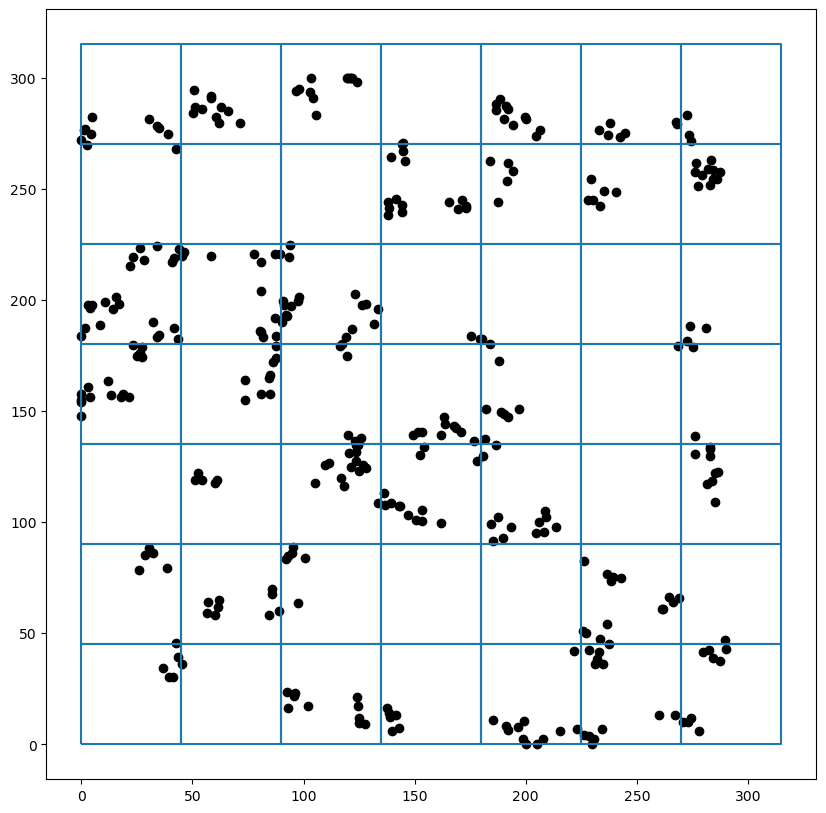

In [159]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 45, 45  # Creates a 45x45 grid, resulting in 49 tracts cell divisions
tracts_gdf = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

# Simulate S2

def simulate_clustered_S2(num_points, num_clusters, cluster_std=5, x_range=(0, 300), y_range=(0, 300), random_state=None):
    """
    Simulates clustered points and returns corresponding S2 values and locations.

    Parameters:
    - num_points: total number of points to generate
    - num_clusters: number of spatial clusters to create
    - cluster_std: standard deviation of clusters (controls spread of points)
    - x_range, y_range: bounds for the spatial area (min, max values for x and y)

    Returns:
    - S2: array of S2 values (normally distributed)
    - locations: array of [x, y] coordinates for each point
    """
    
    if random_state is not None:
        np.random.seed(random_state)
    # Generate clustered points using sklearn's make_blobs function
    centers = np.random.uniform(low=x_range[0], high=x_range[1], size=(num_clusters, 2))
    locations, _ = make_blobs(n_samples=num_points, centers=centers, cluster_std=cluster_std)
    
    # Clip points to fit within the study area bounds (if needed)
    locations[:, 0] = np.clip(locations[:, 0], x_range[0], x_range[1])
    locations[:, 1] = np.clip(locations[:, 1], y_range[0], y_range[1])
    
    # Generate S2 values
    S2 = np.random.normal(50, 30, num_points)
    
    return S2, locations

S2, loc2 = simulate_clustered_S2(350, num_clusters=65, cluster_std=4, random_state=12)

tracts_gdf.boundary.plot(figsize=(10, 10))
# tracts_gdf.geometry.centroid.plot()
plt.scatter(loc2[:,0], loc2[:,1], color='k')

S1 = tracts_gdf
S2 = S2
loc1 = np.array([[point.x, point.y] for point in S1.geometry.centroid])
loc2 = loc2


B = create_beta_surface(loc1, heterogeneity='low')

# B = uniform(loc1)

# Generate y values
nbrs_S2 = NearestNeighbors(n_neighbors=len(S1)).fit(loc2)
smoothed_S2_to_S1 = np.zeros(len(S1))
for i in range(len(S1)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
    smoothed_S2_to_S1[i] = np.mean(S2[indices_S1_to_S2[0]])

y = B * smoothed_S2_to_S1

In [160]:
len(S1), len(y), len(S2)

(49, 49, 350)

In [161]:
# Define range for number of neighbors
neighbors_values = list(range(2, len(S1), 2))
best_aicc = float('inf')
best_neighbors = None
recovered_betas_best = None

aicc_values = []
enp_values = []

# Iterate over neighbor values
for n_neighbors in neighbors_values:
    recovered_betas, aicc, enp = perform_local_regression(n_neighbors, loc1, loc2, S2, y)
    aicc_values.append(aicc)
    enp_values.append(enp)
    if aicc < best_aicc:
        best_aicc = aicc
        best_neighbors = n_neighbors
        recovered_betas_best = recovered_betas

print(f"Optimal number of neighbors: {best_neighbors}")
print(f"Best AICc: {best_aicc:.2f}")

Optimal number of neighbors: 16
Best AICc: 716.71


In [162]:
dict_aicc = dict(zip(neighbors_values, aicc_values))
min(dict_aicc, key=dict_aicc.get)

16

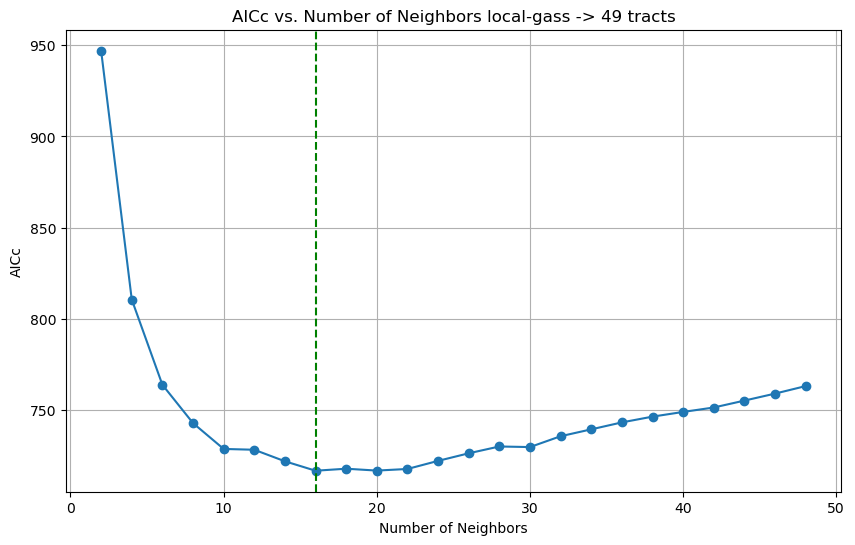

In [163]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, aicc_values, marker='o')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title('AICc vs. Number of Neighbors local-gass -> 49 tracts')
plt.grid(True)
plt.show()

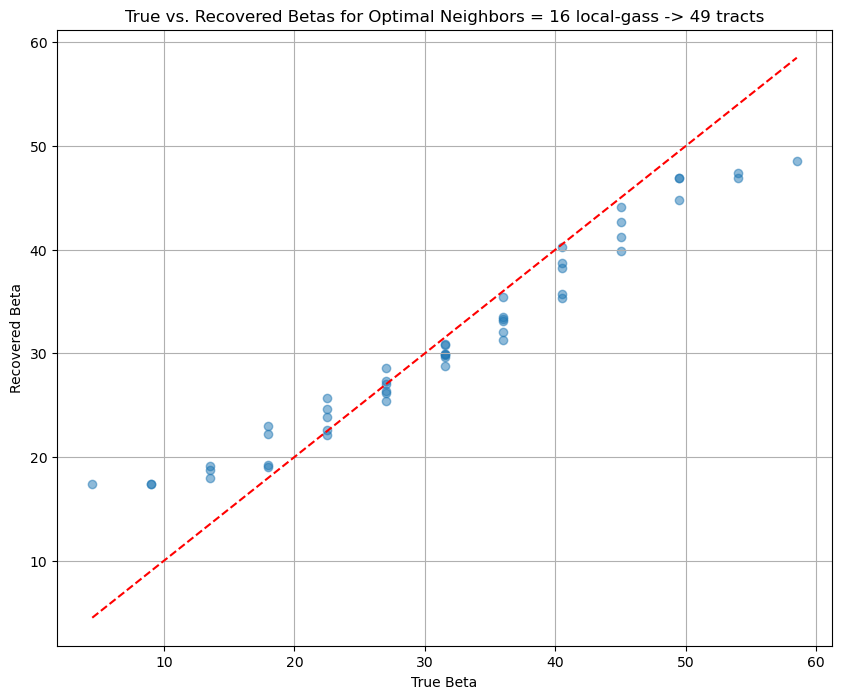

In [164]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, recovered_betas_best, alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors} local-gass -> 49 tracts')
plt.grid(True)
plt.show()

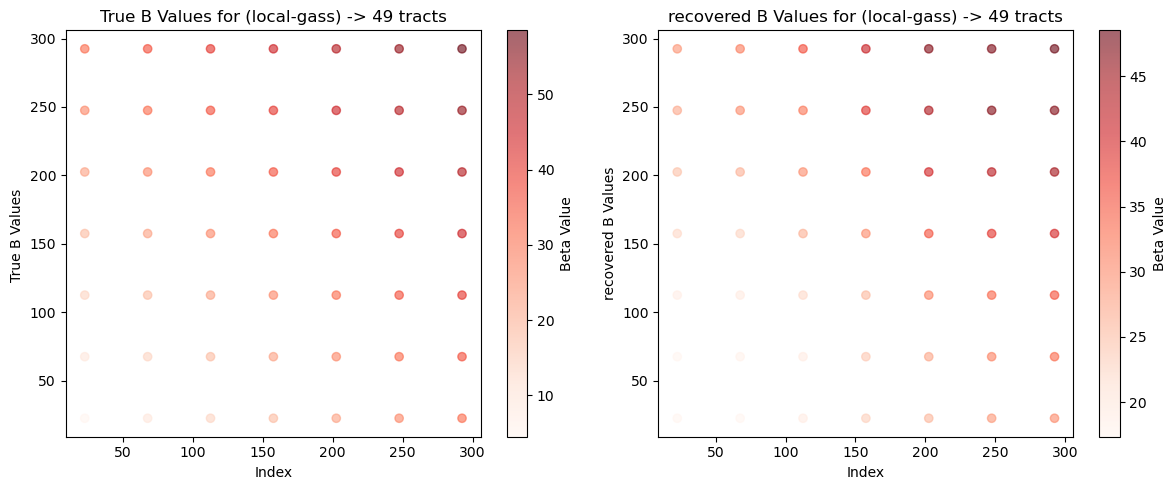

In [165]:
plot_true_and_recovered(B, recovered_betas_best, loc1, name='(local-gass) -> 49 tracts')

In [166]:
B

array([ 4.5,  9. , 13.5, 18. , 22.5, 27. , 31.5,  9. , 13.5, 18. , 22.5,
       27. , 31.5, 36. , 13.5, 18. , 22.5, 27. , 31.5, 36. , 40.5, 18. ,
       22.5, 27. , 31.5, 36. , 40.5, 45. , 22.5, 27. , 31.5, 36. , 40.5,
       45. , 49.5, 27. , 31.5, 36. , 40.5, 45. , 49.5, 54. , 31.5, 36. ,
       40.5, 45. , 49.5, 54. , 58.5])

In [167]:
recovered_betas_best

array([17.35 , 17.404, 18.727, 22.172, 24.598, 27.08 , 28.794, 17.348,
       17.989, 19.197, 22.578, 26.124, 29.844, 31.282, 19.094, 19.077,
       22.073, 26.32 , 29.683, 32.068, 35.729, 22.996, 23.829, 25.409,
       29.957, 33.313, 38.659, 41.231, 25.72 , 27.283, 30.862, 35.463,
       40.242, 44.11 , 46.874, 28.549, 30.753, 33.458, 38.2  , 42.693,
       46.915, 47.401, 29.974, 33.12 , 35.346, 39.898, 44.81 , 46.899,
       48.508])

In [168]:
B.min(), B.max()

(4.5, 58.5)

In [169]:
recovered_betas_best.min(), recovered_betas_best.max()

(17.34849966900558, 48.50756512786603)

#### Aggregating points into census tracts for GWR

For GWR, one has to aggregate points into tracts every time it is increased

In [170]:
df_S2 = gpd.GeoDataFrame({'S2': S2}, geometry=gpd.points_from_xy(loc2[:, 0], loc2[:, 1]))
joined = gpd.sjoin(df_S2, S1, how='inner', predicate='within')
sX = joined.groupby('tract_id').agg({'S2': ['mean']})
sX.columns = ['_'.join(col).strip() for col in sX.columns.values]
sX = sX.reset_index()

# merge back with tracts (S1)
sX1 = S1.merge(sX, on='tract_id', how='left')
sX1.fillna({'S2_mean': 0.000001}, inplace=True)

In [171]:
sX1.head()

tract_id                                           geometry    S2_mean
0         0  POLYGON ((0.000 0.000, 45.000 0.000, 45.000 45...  36.721517
1         1  POLYGON ((0.000 45.000, 45.000 45.000, 45.000 ...  46.950617
2         2  POLYGON ((0.000 90.000, 45.000 90.000, 45.000 ...   0.000001
3         3  POLYGON ((0.000 135.000, 45.000 135.000, 45.00...  48.844521
4         4  POLYGON ((0.000 180.000, 45.000 180.000, 45.00...  46.134890

##### Specify GWR parameters

In [172]:
gwr_X  = sX1['S2_mean'].values.reshape(-1,1)
gwr_y = y.reshape(-1, 1)
coords = np.array([[point.x, point.y] for point in sX1['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((49, 1), (49, 1))

In [173]:
aicc_gwr = []
params = []
ENP = []
bwvalue = list(range(10, len(loc1), 2))
for i in bwvalue:
    model = GWR(coords, gwr_y, gwr_X, i, constant=False).fit()
    params.append(model.params)
    aicc_gwr.append(model.aicc)
    ENP.append(model.ENP)

In [174]:
dict_aicc = dict(zip(bwvalue, aicc_gwr))

In [175]:
min(dict_aicc, key=dict_aicc.get)

42

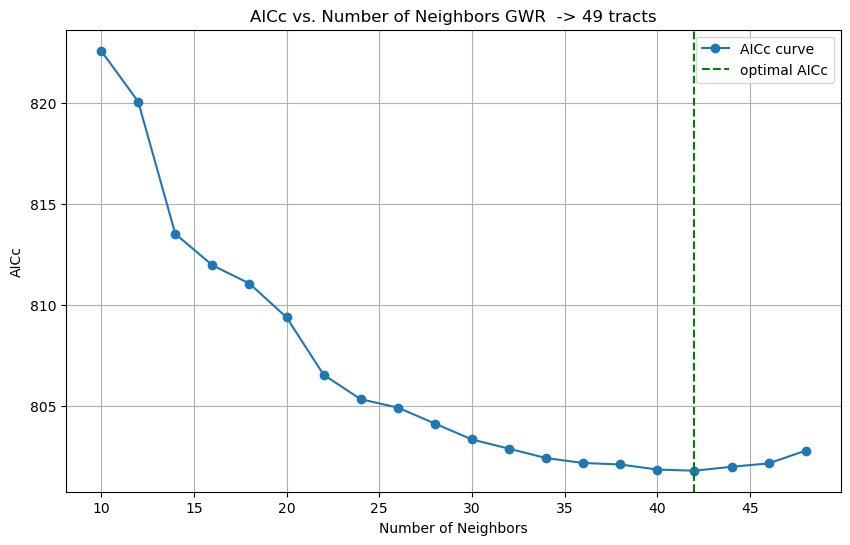

In [176]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(bwvalue, aicc_gwr, marker='o', label='AICc curve')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.legend()
plt.title('AICc vs. Number of Neighbors GWR  -> 49 tracts')
plt.grid(True)
plt.show()

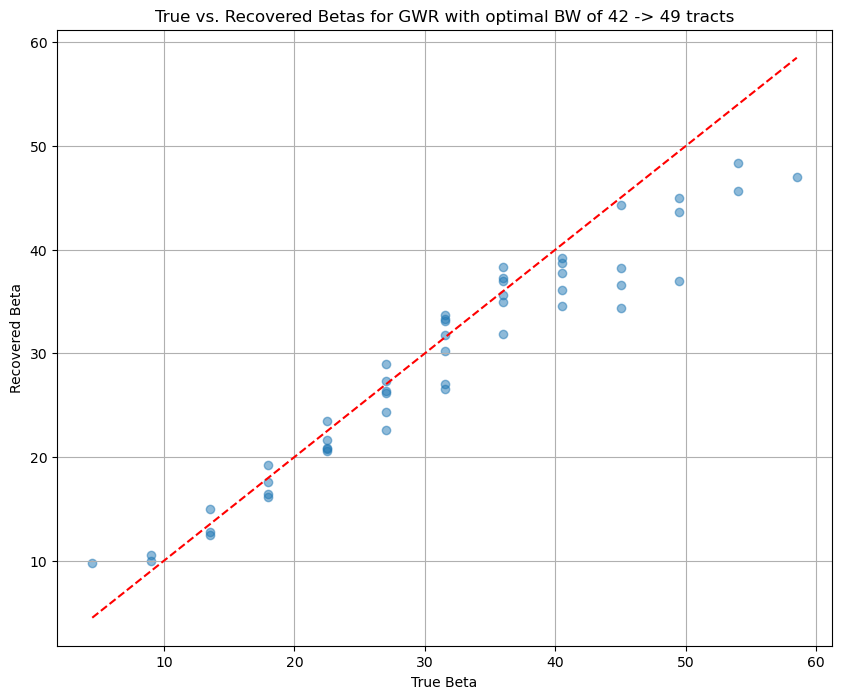

In [177]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, params[0].ravel(), alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f"True vs. Recovered Betas for GWR with optimal BW of {min(dict_aicc, key=dict_aicc.get)} -> 49 tracts")
plt.grid(True)
plt.show()

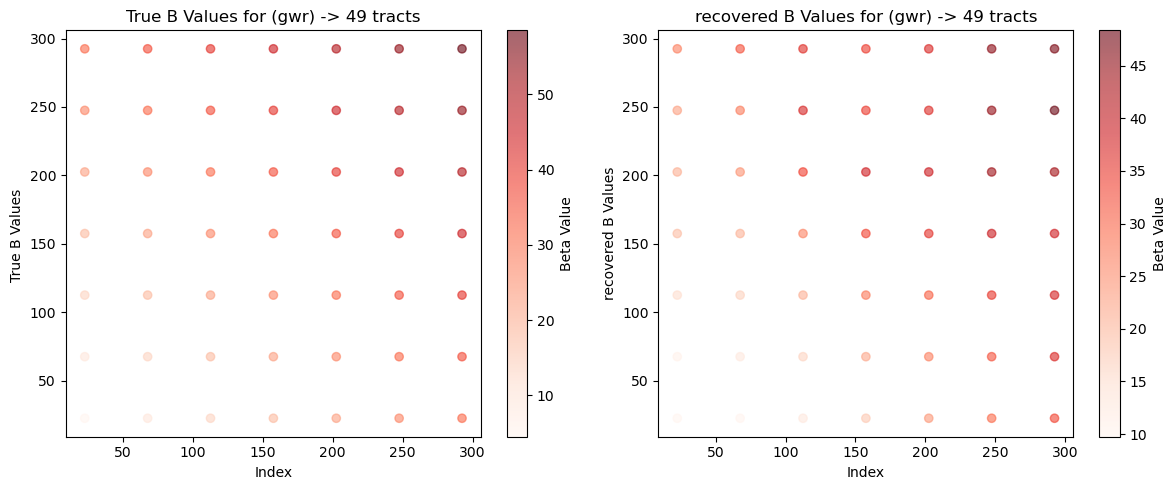

In [178]:
plot_true_and_recovered(B, params[0], loc1, name='(gwr) -> 49 tracts')

In [179]:
B

array([ 4.5,  9. , 13.5, 18. , 22.5, 27. , 31.5,  9. , 13.5, 18. , 22.5,
       27. , 31.5, 36. , 13.5, 18. , 22.5, 27. , 31.5, 36. , 40.5, 18. ,
       22.5, 27. , 31.5, 36. , 40.5, 45. , 22.5, 27. , 31.5, 36. , 40.5,
       45. , 49.5, 27. , 31.5, 36. , 40.5, 45. , 49.5, 54. , 31.5, 36. ,
       40.5, 45. , 49.5, 54. , 58.5])

In [180]:
params[0].flatten()

array([ 9.744, 10.571, 15.021, 19.227, 20.893, 22.594, 26.542,  9.941,
       12.51 , 16.425, 20.565, 24.336, 26.997, 31.864, 12.756, 16.149,
       20.749, 26.134, 33.649, 37.238, 36.102, 17.613, 21.668, 27.33 ,
       33.29 , 38.285, 34.606, 34.352, 23.503, 26.373, 30.224, 35.631,
       38.707, 36.547, 36.962, 28.937, 31.728, 34.96 , 39.149, 44.256,
       44.932, 45.607, 33.095, 36.948, 37.758, 38.259, 43.63 , 48.361,
       46.952])

In [181]:
B.min(), B.max()

(4.5, 58.5)

In [182]:
params[0].min(), params[0].max()

(9.744366567668642, 48.36090817104392)

<br /> 

### Further increasing aggregation by reducing the number of tracts to 36. It was previously 49 

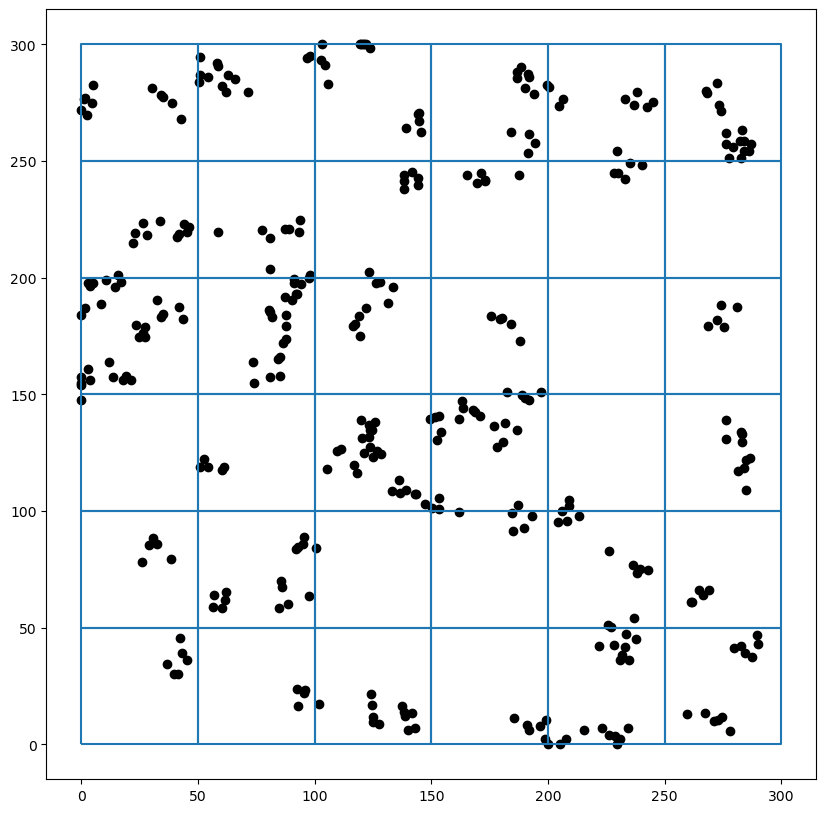

In [183]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 50, 50  # Creates a 50x50 grid, resulting in 36 tracts cell divisions
tracts_gdf = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

# Simulate S2

def simulate_clustered_S2(num_points, num_clusters, cluster_std=5, x_range=(0, 300), y_range=(0, 300), random_state=None):
    """
    Simulates clustered points and returns corresponding S2 values and locations.

    Parameters:
    - num_points: total number of points to generate
    - num_clusters: number of spatial clusters to create
    - cluster_std: standard deviation of clusters (controls spread of points)
    - x_range, y_range: bounds for the spatial area (min, max values for x and y)

    Returns:
    - S2: array of S2 values (normally distributed)
    - locations: array of [x, y] coordinates for each point
    """
    
    if random_state is not None:
        np.random.seed(random_state)
    # Generate clustered points using sklearn's make_blobs function
    centers = np.random.uniform(low=x_range[0], high=x_range[1], size=(num_clusters, 2))
    locations, _ = make_blobs(n_samples=num_points, centers=centers, cluster_std=cluster_std)
    
    # Clip points to fit within the study area bounds (if needed)
    locations[:, 0] = np.clip(locations[:, 0], x_range[0], x_range[1])
    locations[:, 1] = np.clip(locations[:, 1], y_range[0], y_range[1])
    
    # Generate S2 values
    S2 = np.random.normal(50, 30, num_points)
    
    return S2, locations

S2, loc2 = simulate_clustered_S2(350, num_clusters=65, cluster_std=4, random_state=12)

tracts_gdf.boundary.plot(figsize=(10, 10))
# tracts_gdf.geometry.centroid.plot()
plt.scatter(loc2[:,0], loc2[:,1], color='k')

S1 = tracts_gdf
S2 = S2
loc1 = np.array([[point.x, point.y] for point in S1.geometry.centroid])
loc2 = loc2


B = create_beta_surface(loc1, heterogeneity='low')

# B = uniform(loc1)

# Generate y values
nbrs_S2 = NearestNeighbors(n_neighbors=len(S1)).fit(loc2)
smoothed_S2_to_S1 = np.zeros(len(S1))
for i in range(len(S1)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
    smoothed_S2_to_S1[i] = np.mean(S2[indices_S1_to_S2[0]])

y = B * smoothed_S2_to_S1

In [184]:
len(S1), len(y), len(S2)

(36, 36, 350)

In [185]:
# Define range for number of neighbors
neighbors_values = list(range(2, len(S1), 2))
best_aicc = float('inf')
best_neighbors = None
recovered_betas_best = None

aicc_values = []
enp_values = []

# Iterate over neighbor values
for n_neighbors in neighbors_values:
    recovered_betas, aicc, enp = perform_local_regression(n_neighbors, loc1, loc2, S2, y)
    aicc_values.append(aicc)
    enp_values.append(enp)
    if aicc < best_aicc:
        best_aicc = aicc
        best_neighbors = n_neighbors
        recovered_betas_best = recovered_betas

print(f"Optimal number of neighbors: {best_neighbors}")
print(f"Best AICc: {best_aicc:.2f}")

Optimal number of neighbors: 10
Best AICc: 520.83


In [186]:
dict_aicc = dict(zip(neighbors_values, aicc_values))
min(dict_aicc, key=dict_aicc.get)

10

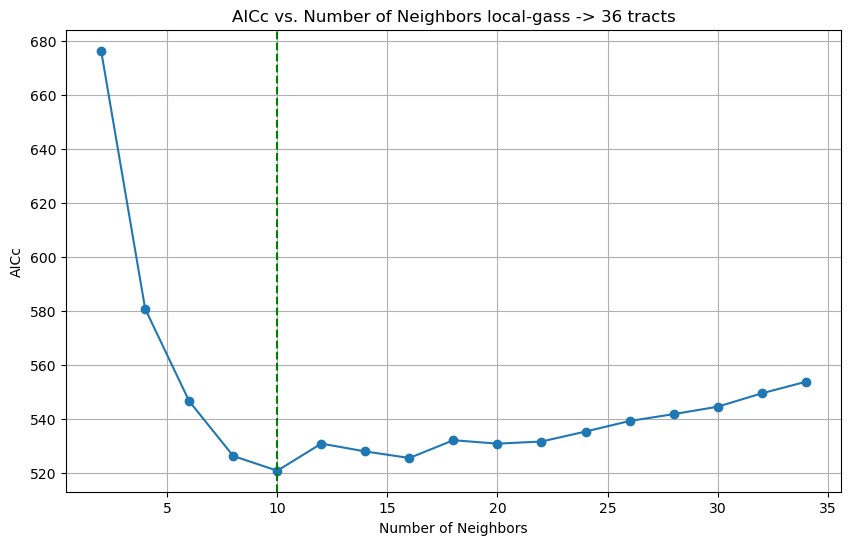

In [187]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, aicc_values, marker='o')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title('AICc vs. Number of Neighbors local-gass -> 36 tracts')
plt.grid(True)
plt.show()

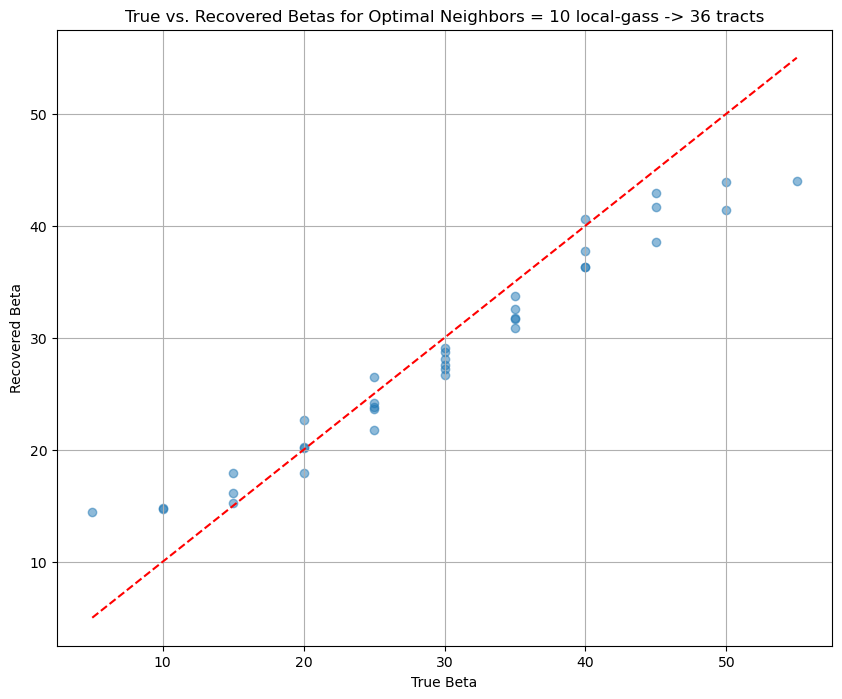

In [188]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, recovered_betas_best, alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors} local-gass -> 36 tracts')
plt.grid(True)
plt.show()

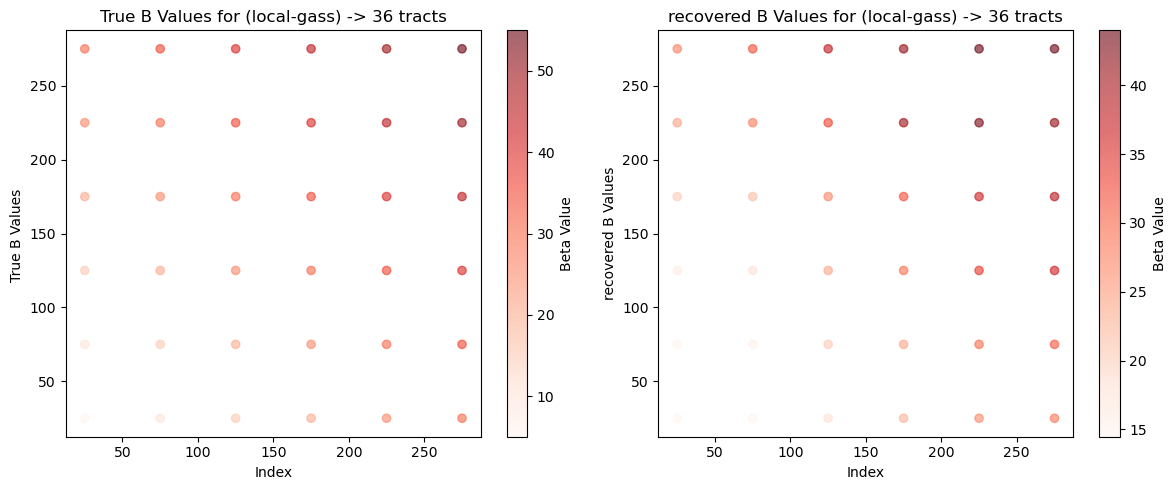

In [189]:
plot_true_and_recovered(B, recovered_betas_best, loc1, name='(local-gass) -> 36 tracts')

In [190]:
B

array([ 5., 10., 15., 20., 25., 30., 10., 15., 20., 25., 30., 35., 15.,
       20., 25., 30., 35., 40., 20., 25., 30., 35., 40., 45., 25., 30.,
       35., 40., 45., 50., 30., 35., 40., 45., 50., 55.])

In [191]:
recovered_betas_best

array([14.461, 14.759, 16.177, 20.115, 24.153, 27.228, 14.676, 15.248,
       17.892, 21.722, 27.525, 31.732, 17.89 , 20.254, 23.651, 26.681,
       32.586, 37.71 , 22.649, 23.841, 28.741, 31.659, 40.605, 41.683,
       26.452, 29.087, 33.715, 36.313, 42.877, 43.886, 28.061, 30.863,
       36.285, 38.582, 41.387, 44.   ])

In [192]:
B.min(), B.max()

(5.0, 55.0)

In [193]:
recovered_betas_best.min(), recovered_betas_best.max()

(14.460601707051557, 44.000356615449334)

#### Aggregating points into census tracts for GWR

For GWR, one has to aggregate points into tracts every time it is increased

In [194]:
df_S2 = gpd.GeoDataFrame({'S2': S2}, geometry=gpd.points_from_xy(loc2[:, 0], loc2[:, 1]))
joined = gpd.sjoin(df_S2, S1, how='inner', predicate='within')
sX = joined.groupby('tract_id').agg({'S2': ['mean']})
sX.columns = ['_'.join(col).strip() for col in sX.columns.values]
sX = sX.reset_index()

# merge back with tracts (S1)
sX1 = S1.merge(sX, on='tract_id', how='left')
sX1.fillna({'S2_mean': 0.000001}, inplace=True)

In [195]:
sX1.head()

tract_id                                           geometry    S2_mean
0         0  POLYGON ((0.000 0.000, 50.000 0.000, 50.000 50...  46.797110
1         1  POLYGON ((0.000 50.000, 50.000 50.000, 50.000 ...  42.445455
2         2  POLYGON ((0.000 100.000, 50.000 100.000, 50.00...   0.000001
3         3  POLYGON ((0.000 150.000, 50.000 150.000, 50.00...  45.947667
4         4  POLYGON ((0.000 200.000, 50.000 200.000, 50.00...  43.776094

##### Specify GWR parameters

In [196]:
gwr_X  = sX1['S2_mean'].values.reshape(-1,1)
gwr_y = y.reshape(-1, 1)
coords = np.array([[point.x, point.y] for point in sX1['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((36, 1), (36, 1))

In [197]:
aicc_gwr = []
params = []
ENP = []
bwvalue = list(range(10, len(loc1), 2))
for i in bwvalue:
    model = GWR(coords, gwr_y, gwr_X, i, constant=False).fit()
    params.append(model.params)
    aicc_gwr.append(model.aicc)
    ENP.append(model.ENP)

In [198]:
dict_aicc = dict(zip(bwvalue, aicc_gwr))

In [199]:
min(dict_aicc, key=dict_aicc.get)

22

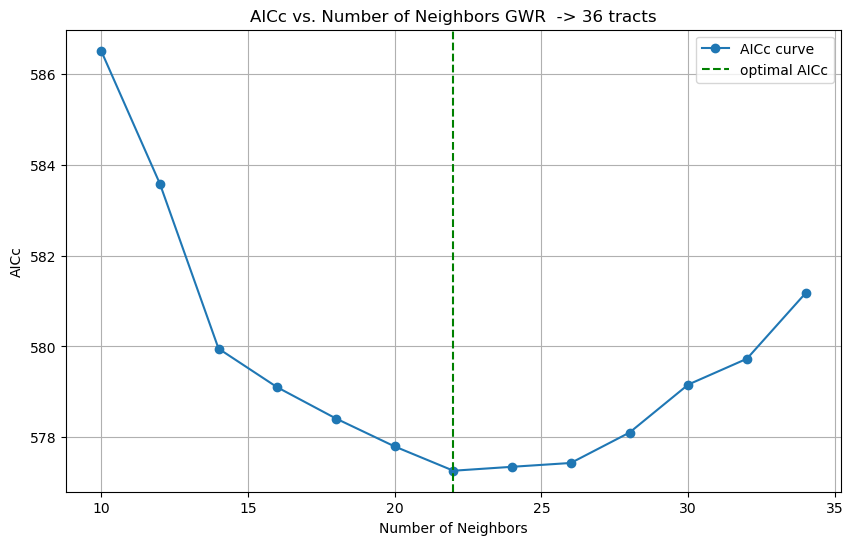

In [200]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(bwvalue, aicc_gwr, marker='o', label='AICc curve')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.legend()
plt.title('AICc vs. Number of Neighbors GWR  -> 36 tracts')
plt.grid(True)
plt.show()

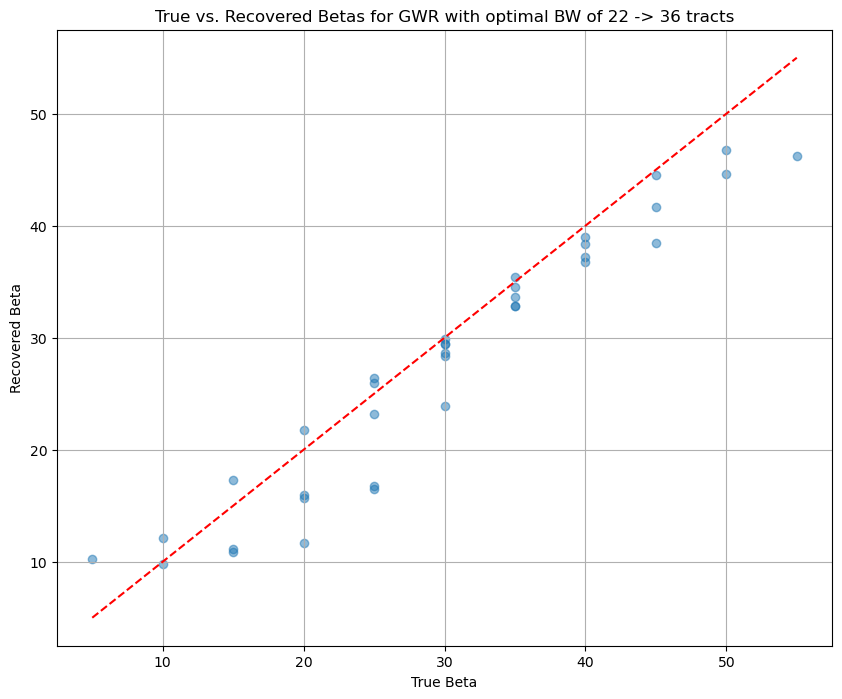

In [201]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, params[0].ravel(), alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f"True vs. Recovered Betas for GWR with optimal BW of {min(dict_aicc, key=dict_aicc.get)} -> 36 tracts")
plt.grid(True)
plt.show()

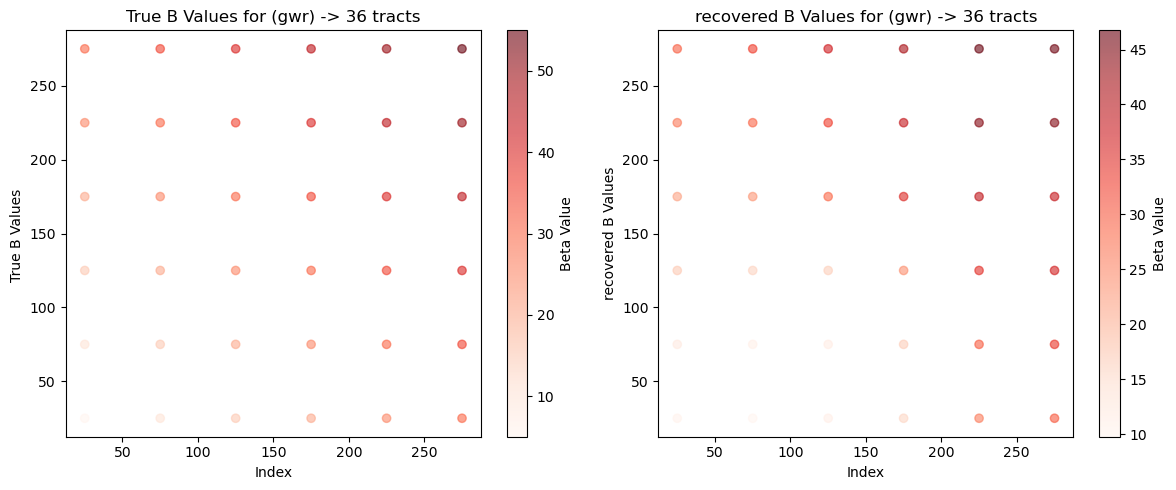

In [202]:
plot_true_and_recovered(B, params[0], loc1, name='(gwr) -> 36 tracts')

In [203]:
B

array([ 5., 10., 15., 20., 25., 30., 10., 15., 20., 25., 30., 35., 15.,
       20., 25., 30., 35., 40., 20., 25., 30., 35., 40., 45., 25., 30.,
       35., 40., 45., 50., 30., 35., 40., 45., 50., 55.])

In [204]:
params[0].flatten()

array([10.212, 12.152, 17.263, 21.717, 26.436, 29.397,  9.775, 10.887,
       15.951, 23.202, 28.637, 32.793, 11.153, 11.638, 16.482, 28.392,
       32.81 , 37.181, 15.682, 16.786, 23.889, 35.418, 38.409, 41.7  ,
       25.974, 29.448, 34.566, 39.036, 44.49 , 46.745, 29.844, 33.675,
       36.756, 38.474, 44.592, 46.233])

In [205]:
B.min(), B.max()

(5.0, 55.0)

In [206]:
params[0].min(), params[0].max()

(9.775478026164343, 46.74522038069335)

<br /> 

### Further increasing aggregation by reducing the number of tracts to 25. It was previously 36 

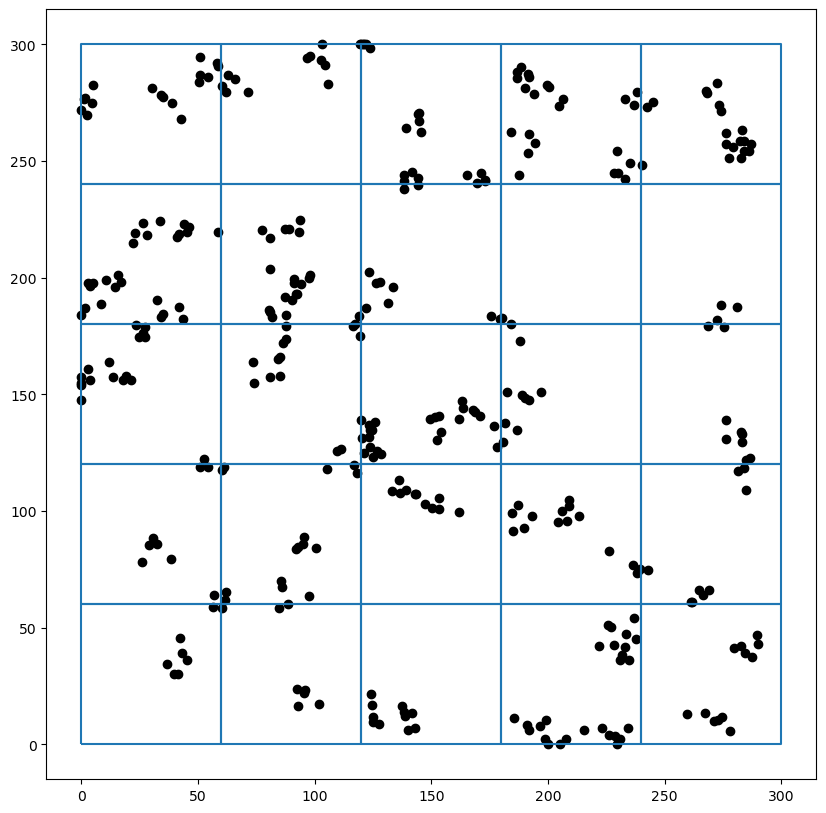

In [207]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 60, 60  # Creates a 5x5 grid, resulting in 25 tracts cell divisions
tracts_gdf = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

# Simulate S2

def simulate_clustered_S2(num_points, num_clusters, cluster_std=5, x_range=(0, 300), y_range=(0, 300), random_state=None):
    """
    Simulates clustered points and returns corresponding S2 values and locations.

    Parameters:
    - num_points: total number of points to generate
    - num_clusters: number of spatial clusters to create
    - cluster_std: standard deviation of clusters (controls spread of points)
    - x_range, y_range: bounds for the spatial area (min, max values for x and y)

    Returns:
    - S2: array of S2 values (normally distributed)
    - locations: array of [x, y] coordinates for each point
    """
    
    if random_state is not None:
        np.random.seed(random_state)
    # Generate clustered points using sklearn's make_blobs function
    centers = np.random.uniform(low=x_range[0], high=x_range[1], size=(num_clusters, 2))
    locations, _ = make_blobs(n_samples=num_points, centers=centers, cluster_std=cluster_std)
    
    # Clip points to fit within the study area bounds (if needed)
    locations[:, 0] = np.clip(locations[:, 0], x_range[0], x_range[1])
    locations[:, 1] = np.clip(locations[:, 1], y_range[0], y_range[1])
    
    # Generate S2 values
    S2 = np.random.normal(50, 30, num_points)
    
    return S2, locations

S2, loc2 = simulate_clustered_S2(350, num_clusters=65, cluster_std=4, random_state=12)

tracts_gdf.boundary.plot(figsize=(10, 10))
# tracts_gdf.geometry.centroid.plot()
plt.scatter(loc2[:,0], loc2[:,1], color='k')

S1 = tracts_gdf
S2 = S2
loc1 = np.array([[point.x, point.y] for point in S1.geometry.centroid])
loc2 = loc2


B = create_beta_surface(loc1, heterogeneity='low')

# B = uniform(loc1)

# Generate y values
nbrs_S2 = NearestNeighbors(n_neighbors=len(S1)).fit(loc2)
smoothed_S2_to_S1 = np.zeros(len(S1))
for i in range(len(S1)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
    smoothed_S2_to_S1[i] = np.mean(S2[indices_S1_to_S2[0]])

y = B * smoothed_S2_to_S1

In [208]:
len(S1), len(y), len(S2)

(25, 25, 350)

In [209]:
# Define range for number of neighbors
neighbors_values = list(range(2, len(S1), 2))
best_aicc = float('inf')
best_neighbors = None
recovered_betas_best = None

aicc_values = []
enp_values = []

# Iterate over neighbor values
for n_neighbors in neighbors_values:
    recovered_betas, aicc, enp = perform_local_regression(n_neighbors, loc1, loc2, S2, y)
    aicc_values.append(aicc)
    enp_values.append(enp)
    if aicc < best_aicc:
        best_aicc = aicc
        best_neighbors = n_neighbors
        recovered_betas_best = recovered_betas

print(f"Optimal number of neighbors: {best_neighbors}")
print(f"Best AICc: {best_aicc:.2f}")

Optimal number of neighbors: 8
Best AICc: 357.35


In [210]:
dict_aicc = dict(zip(neighbors_values, aicc_values))
min(dict_aicc, key=dict_aicc.get)

8

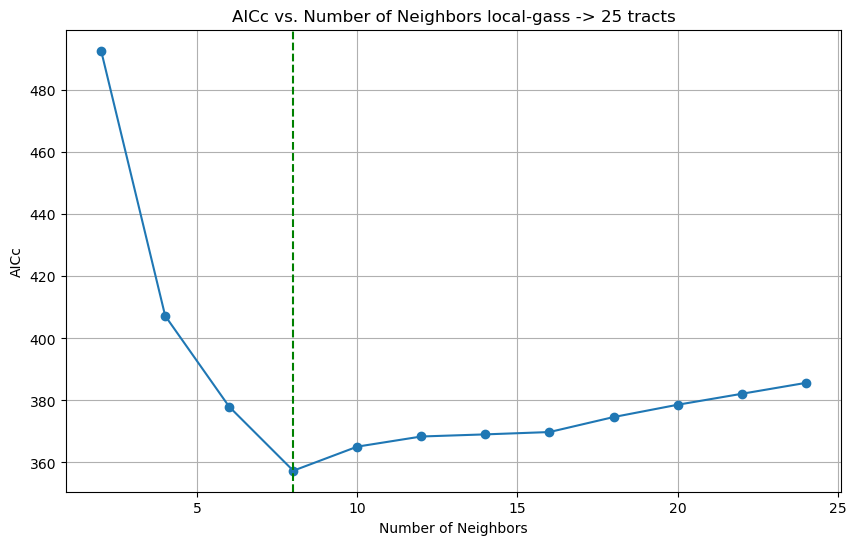

In [211]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, aicc_values, marker='o')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title('AICc vs. Number of Neighbors local-gass -> 25 tracts')
plt.grid(True)
plt.show()

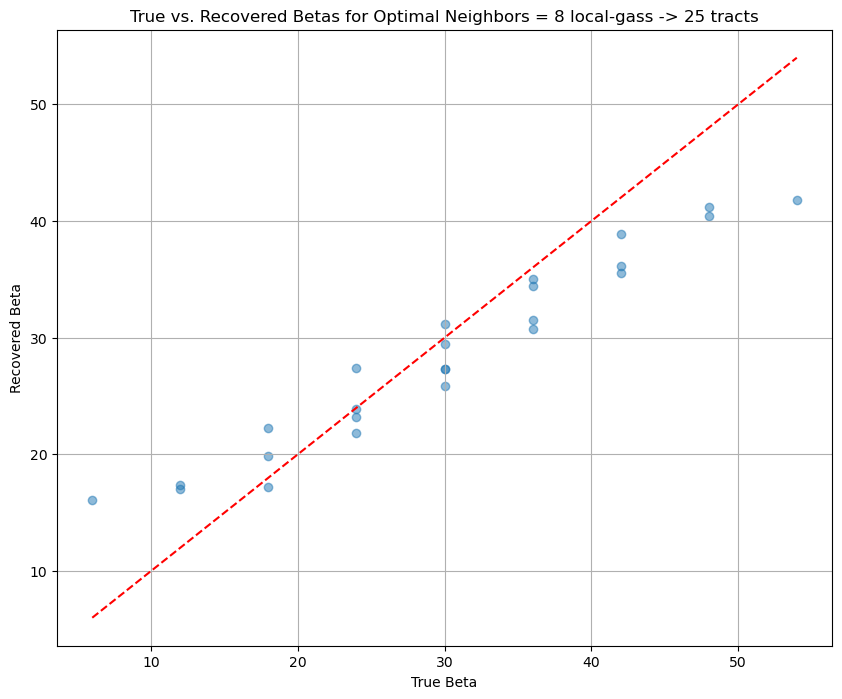

In [212]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, recovered_betas_best, alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors} local-gass -> 25 tracts')
plt.grid(True)
plt.show()

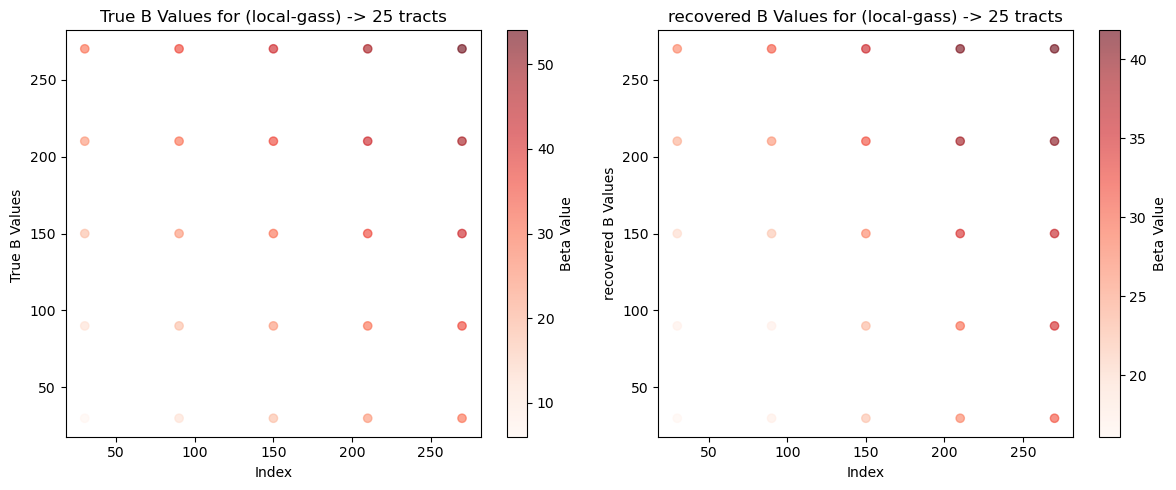

In [213]:
plot_true_and_recovered(B, recovered_betas_best, loc1, name='(local-gass) -> 25 tracts')

In [214]:
B

array([ 6., 12., 18., 24., 30., 12., 18., 24., 30., 36., 18., 24., 30.,
       36., 42., 24., 30., 36., 42., 48., 30., 36., 42., 48., 54.])

In [215]:
recovered_betas_best

array([16.129, 17.062, 19.853, 23.855, 27.338, 17.39 , 17.177, 21.843,
       25.863, 30.746, 22.232, 23.227, 27.296, 31.512, 35.537, 27.372,
       29.438, 34.461, 38.908, 41.192, 31.199, 35.071, 36.132, 40.406,
       41.813])

In [216]:
B.min(), B.max()

(6.0, 54.0)

In [217]:
recovered_betas_best.min(), recovered_betas_best.max()

(16.128995130811088, 41.81279549968121)

#### Aggregating points into census tracts for GWR

For GWR, one has to aggregate points into tracts every time it is increased

In [218]:
df_S2 = gpd.GeoDataFrame({'S2': S2}, geometry=gpd.points_from_xy(loc2[:, 0], loc2[:, 1]))
joined = gpd.sjoin(df_S2, S1, how='inner', predicate='within')
sX = joined.groupby('tract_id').agg({'S2': ['mean']})
sX.columns = ['_'.join(col).strip() for col in sX.columns.values]
sX = sX.reset_index()

# merge back with tracts (S1)
sX1 = S1.merge(sX, on='tract_id', how='left')
sX1.fillna({'S2_mean': 0.000001}, inplace=True)

In [219]:
sX1.head()

tract_id                                           geometry    S2_mean
0         0  POLYGON ((0.000 0.000, 60.000 0.000, 60.000 60...  47.585188
1         1  POLYGON ((0.000 60.000, 60.000 60.000, 60.000 ...  51.626520
2         2  POLYGON ((0.000 120.000, 60.000 120.000, 60.00...  53.035826
3         3  POLYGON ((0.000 180.000, 60.000 180.000, 60.00...  42.569589
4         4  POLYGON ((0.000 240.000, 60.000 240.000, 60.00...  52.188923

##### Specify GWR parameters

In [220]:
gwr_X  = sX1['S2_mean'].values.reshape(-1,1)
gwr_y = y.reshape(-1, 1)
coords = np.array([[point.x, point.y] for point in sX1['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((25, 1), (25, 1))

In [221]:
aicc_gwr = []
params = []
ENP = []
bwvalue = list(range(10, len(loc1), 2))
for i in bwvalue:
    model = GWR(coords, gwr_y, gwr_X, i, constant=False).fit()
    params.append(model.params)
    aicc_gwr.append(model.aicc)
    ENP.append(model.ENP)

In [222]:
dict_aicc = dict(zip(bwvalue, aicc_gwr))

In [223]:
min(dict_aicc, key=dict_aicc.get)

14

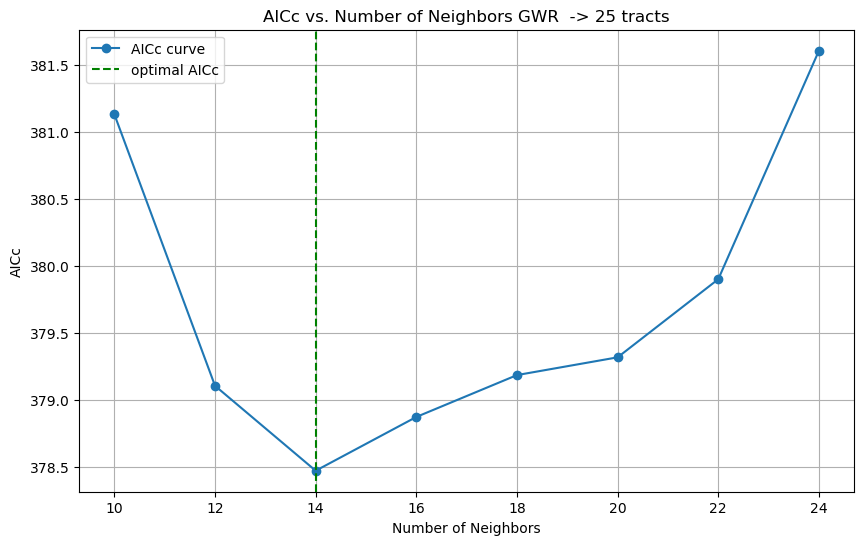

In [224]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(bwvalue, aicc_gwr, marker='o', label='AICc curve')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.legend()
plt.title('AICc vs. Number of Neighbors GWR  -> 25 tracts')
plt.grid(True)
plt.show()

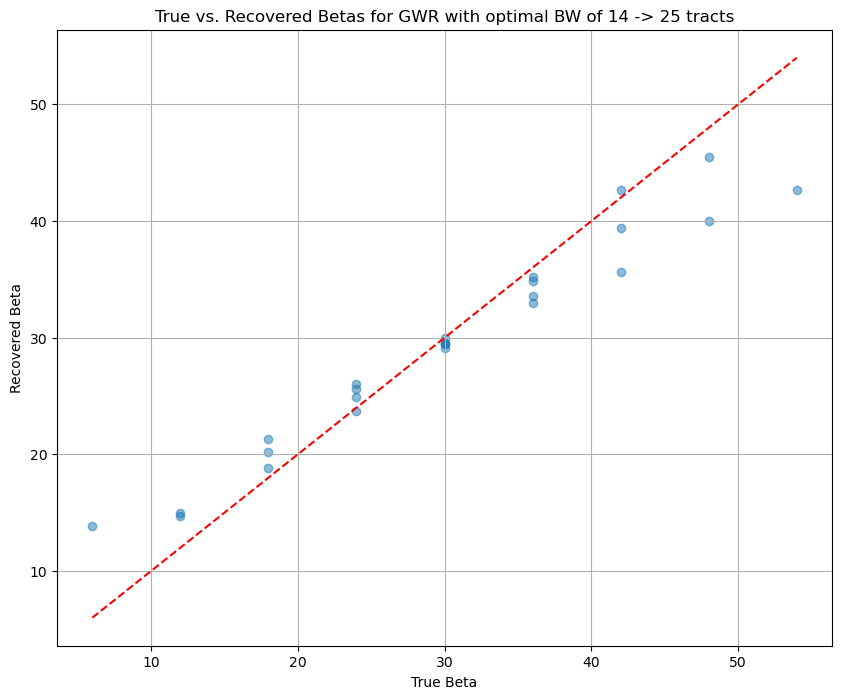

In [225]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, params[0].ravel(), alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f"True vs. Recovered Betas for GWR with optimal BW of {min(dict_aicc, key=dict_aicc.get)} -> 25 tracts")
plt.grid(True)
plt.show()

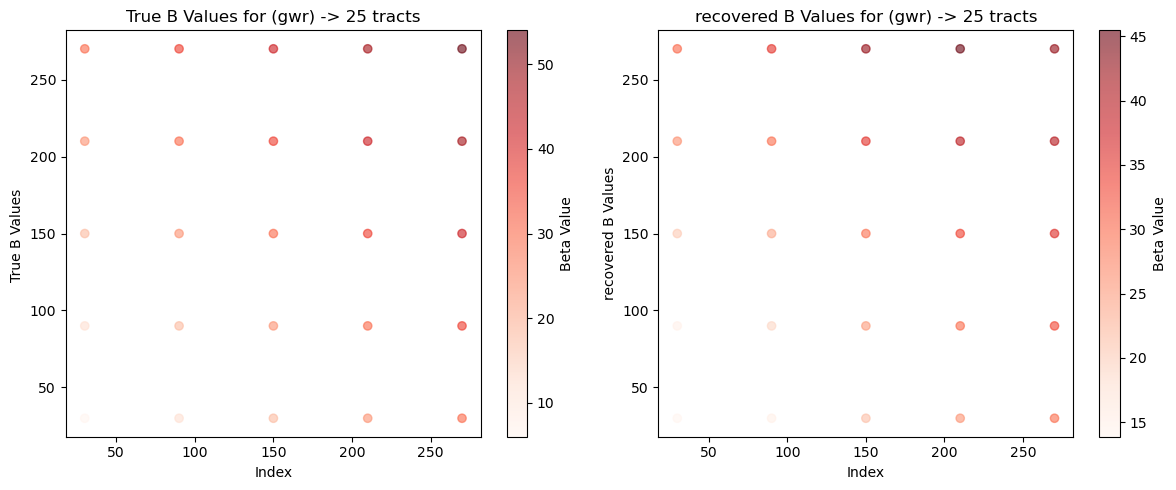

In [226]:
plot_true_and_recovered(B, params[0], loc1, name='(gwr) -> 25 tracts')

In [227]:
B

array([ 6., 12., 18., 24., 30., 12., 18., 24., 30., 36., 18., 24., 30.,
       36., 42., 24., 30., 36., 42., 48., 30., 36., 42., 48., 54.])

In [228]:
params[0].flatten()

array([13.879, 14.731, 20.212, 25.998, 29.958, 14.977, 18.813, 23.744,
       29.484, 34.869, 21.297, 24.902, 29.106, 35.202, 42.675, 25.639,
       29.564, 33.535, 39.379, 45.454, 29.496, 32.962, 35.629, 39.966,
       42.685])

In [229]:
B.min(), B.max()

(6.0, 54.0)

In [230]:
params[0].min(), params[0].max()

(13.879349745048678, 45.45415235468579)

### Being curious. Further increasing aggregation by reducing the number of tracts to 16. It was previously 25 

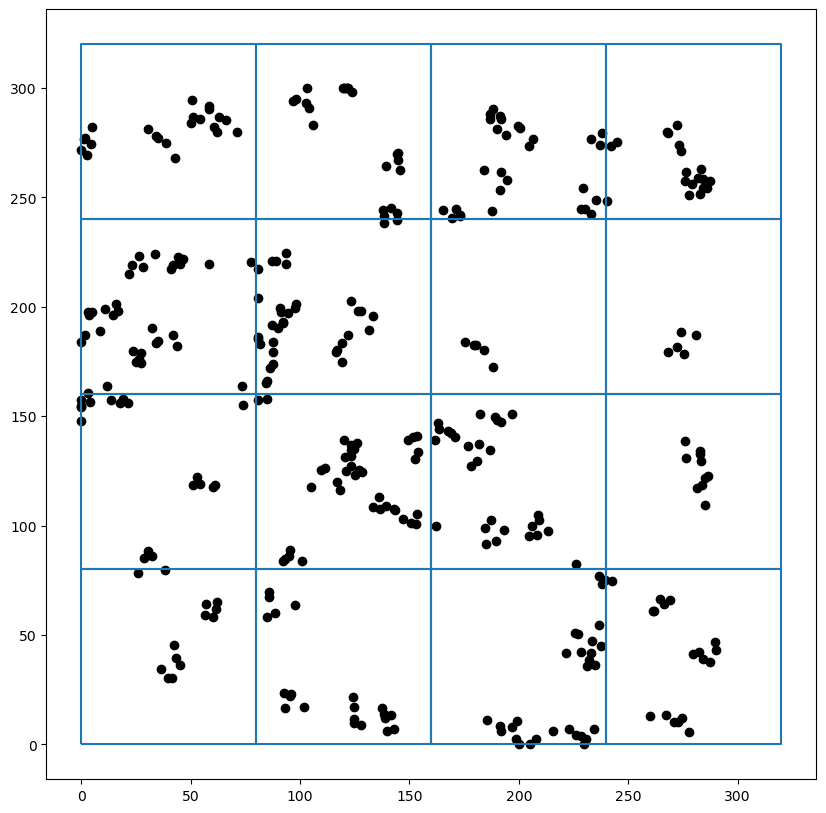

In [231]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 80, 80  # Creates a 4x4 grid, resulting in 16 tracts cell divisions
tracts_gdf = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

# Simulate S2

def simulate_clustered_S2(num_points, num_clusters, cluster_std=5, x_range=(0, 300), y_range=(0, 300), random_state=None):
    """
    Simulates clustered points and returns corresponding S2 values and locations.

    Parameters:
    - num_points: total number of points to generate
    - num_clusters: number of spatial clusters to create
    - cluster_std: standard deviation of clusters (controls spread of points)
    - x_range, y_range: bounds for the spatial area (min, max values for x and y)

    Returns:
    - S2: array of S2 values (normally distributed)
    - locations: array of [x, y] coordinates for each point
    """
    
    if random_state is not None:
        np.random.seed(random_state)
    # Generate clustered points using sklearn's make_blobs function
    centers = np.random.uniform(low=x_range[0], high=x_range[1], size=(num_clusters, 2))
    locations, _ = make_blobs(n_samples=num_points, centers=centers, cluster_std=cluster_std)
    
    # Clip points to fit within the study area bounds (if needed)
    locations[:, 0] = np.clip(locations[:, 0], x_range[0], x_range[1])
    locations[:, 1] = np.clip(locations[:, 1], y_range[0], y_range[1])
    
    # Generate S2 values
    S2 = np.random.normal(50, 30, num_points)
    
    return S2, locations

S2, loc2 = simulate_clustered_S2(350, num_clusters=65, cluster_std=4, random_state=12)

tracts_gdf.boundary.plot(figsize=(10, 10))
# tracts_gdf.geometry.centroid.plot()
plt.scatter(loc2[:,0], loc2[:,1], color='k')

S1 = tracts_gdf
S2 = S2
loc1 = np.array([[point.x, point.y] for point in S1.geometry.centroid])
loc2 = loc2


B = create_beta_surface(loc1, heterogeneity='low')

# B = uniform(loc1)

# Generate y values
nbrs_S2 = NearestNeighbors(n_neighbors=len(S1)).fit(loc2)
smoothed_S2_to_S1 = np.zeros(len(S1))
for i in range(len(S1)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
    smoothed_S2_to_S1[i] = np.mean(S2[indices_S1_to_S2[0]])

y = B * smoothed_S2_to_S1

In [232]:
len(S1), len(y), len(S2)

(16, 16, 350)

In [233]:
# Define range for number of neighbors
neighbors_values = list(range(2, len(S1), 2))
best_aicc = float('inf')
best_neighbors = None
recovered_betas_best = None

aicc_values = []
enp_values = []

# Iterate over neighbor values
for n_neighbors in neighbors_values:
    recovered_betas, aicc, enp = perform_local_regression(n_neighbors, loc1, loc2, S2, y)
    aicc_values.append(aicc)
    enp_values.append(enp)
    if aicc < best_aicc:
        best_aicc = aicc
        best_neighbors = n_neighbors
        recovered_betas_best = recovered_betas

print(f"Optimal number of neighbors: {best_neighbors}")
print(f"Best AICc: {best_aicc:.2f}")

Optimal number of neighbors: 8
Best AICc: 241.60


In [234]:
dict_aicc = dict(zip(neighbors_values, aicc_values))
min(dict_aicc, key=dict_aicc.get)

8

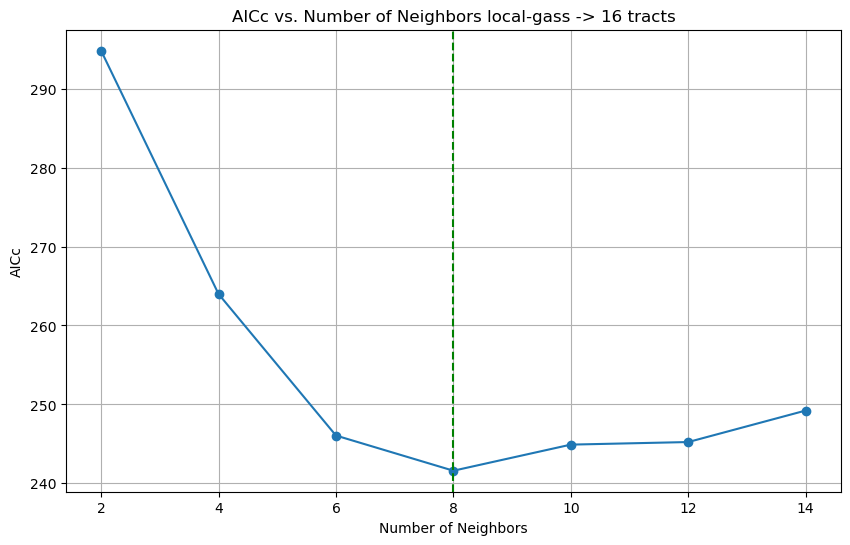

In [235]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, aicc_values, marker='o')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title('AICc vs. Number of Neighbors local-gass -> 16 tracts')
plt.grid(True)
plt.show()

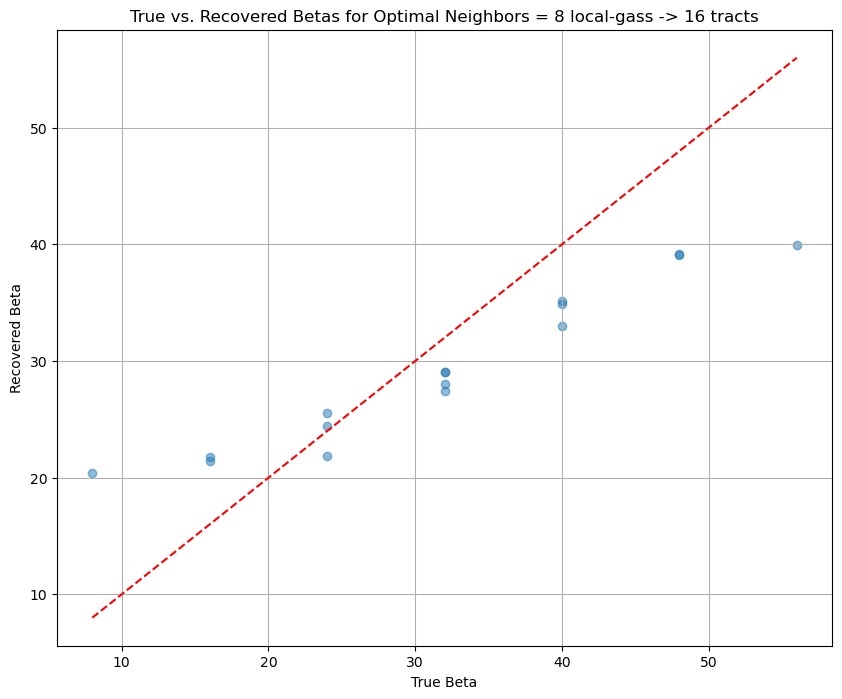

In [236]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, recovered_betas_best, alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors} local-gass -> 16 tracts')
plt.grid(True)
plt.show()

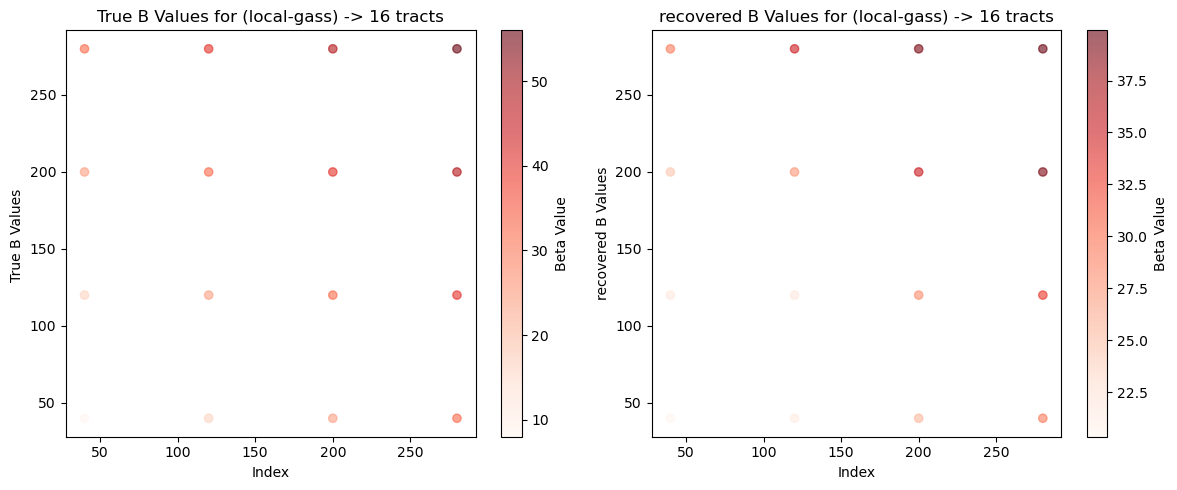

In [237]:
plot_true_and_recovered(B, recovered_betas_best, loc1, name='(local-gass) -> 16 tracts')

In [238]:
B

array([ 8., 16., 24., 32., 16., 24., 32., 40., 24., 32., 40., 48., 32.,
       40., 48., 56.])

In [239]:
recovered_betas_best

array([20.368, 21.793, 24.436, 29.049, 21.444, 21.834, 27.465, 34.9  ,
       25.532, 28.036, 35.162, 39.204, 29.09 , 33.03 , 39.064, 39.914])

In [240]:
B.min(), B.max()

(8.0, 56.0)

In [241]:
recovered_betas_best.min(), recovered_betas_best.max()

(20.36780754265103, 39.91360678650568)

#### Aggregating points into census tracts for GWR

For GWR, one has to aggregate points into tracts every time it is increased

In [242]:
df_S2 = gpd.GeoDataFrame({'S2': S2}, geometry=gpd.points_from_xy(loc2[:, 0], loc2[:, 1]))
joined = gpd.sjoin(df_S2, S1, how='inner', predicate='within')
sX = joined.groupby('tract_id').agg({'S2': ['mean']})
sX.columns = ['_'.join(col).strip() for col in sX.columns.values]
sX = sX.reset_index()

# merge back with tracts (S1)
sX1 = S1.merge(sX, on='tract_id', how='left')
sX1.fillna({'S2_mean': 0.000001}, inplace=True)

In [243]:
sX1.head()

tract_id                                           geometry    S2_mean
0         0  POLYGON ((0.000 0.000, 80.000 0.000, 80.000 80...  46.637033
1         1  POLYGON ((0.000 80.000, 80.000 80.000, 80.000 ...  55.711860
2         2  POLYGON ((0.000 160.000, 80.000 160.000, 80.00...  43.203673
3         3  POLYGON ((0.000 240.000, 80.000 240.000, 80.00...  47.342598
4         4  POLYGON ((80.000 0.000, 160.000 0.000, 160.000...  51.710172

##### Specify GWR parameters

In [244]:
gwr_X  = sX1['S2_mean'].values.reshape(-1,1)
gwr_y = y.reshape(-1, 1)
coords = np.array([[point.x, point.y] for point in sX1['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((16, 1), (16, 1))

In [245]:
aicc_gwr = []
params = []
ENP = []
bwvalue = list(range(10, len(loc1), 2))
for i in bwvalue:
    model = GWR(coords, gwr_y, gwr_X, i, constant=False).fit()
    params.append(model.params)
    aicc_gwr.append(model.aicc)
    ENP.append(model.ENP)

In [246]:
dict_aicc = dict(zip(bwvalue, aicc_gwr))

In [247]:
min(dict_aicc, key=dict_aicc.get)

12

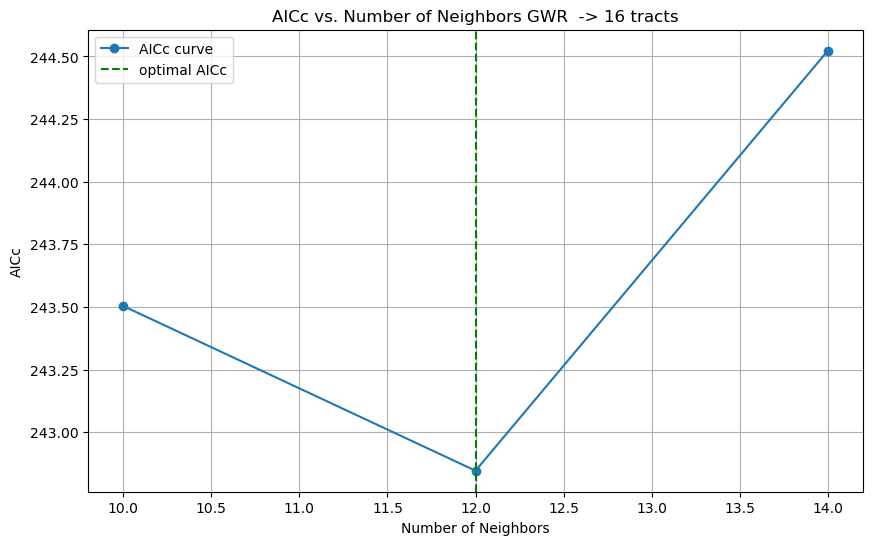

In [248]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(bwvalue, aicc_gwr, marker='o', label='AICc curve')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.legend()
plt.title('AICc vs. Number of Neighbors GWR  -> 16 tracts')
plt.grid(True)
plt.show()

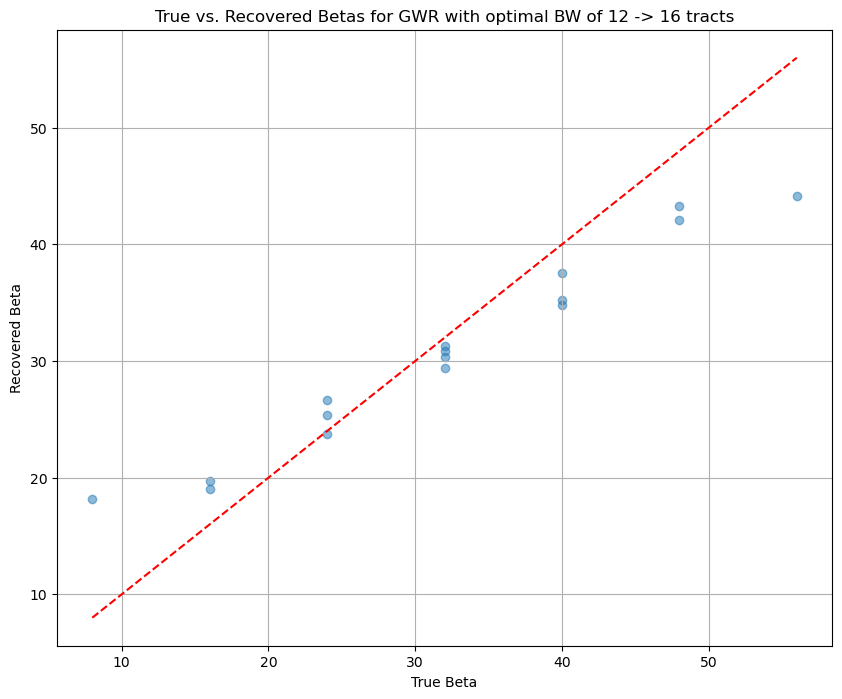

In [249]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, params[0].ravel(), alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f"True vs. Recovered Betas for GWR with optimal BW of {min(dict_aicc, key=dict_aicc.get)} -> 16 tracts")
plt.grid(True)
plt.show()

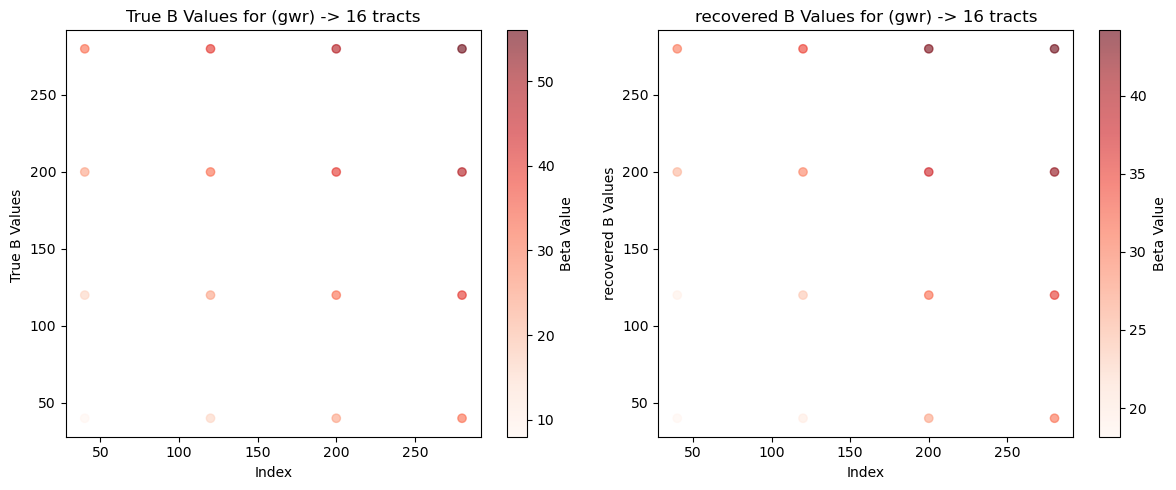

In [250]:
plot_true_and_recovered(B, params[0], loc1, name='(gwr) -> 16 tracts')

In [251]:
B

array([ 8., 16., 24., 32., 16., 24., 32., 40., 24., 32., 40., 48., 32.,
       40., 48., 56.])

In [252]:
params[0].flatten()

array([18.173, 19.005, 25.362, 30.337, 19.74 , 23.744, 29.374, 34.766,
       26.672, 31.29 , 37.558, 43.299, 30.883, 35.246, 42.057, 44.169])

In [253]:
B.min(), B.max()

(8.0, 56.0)

In [254]:
params[0].min(), params[0].max()

(18.17333712724386, 44.168590238875474)

### Being curious. Further increasing aggregation by reducing the number of tracts to 9. It was previously 16 

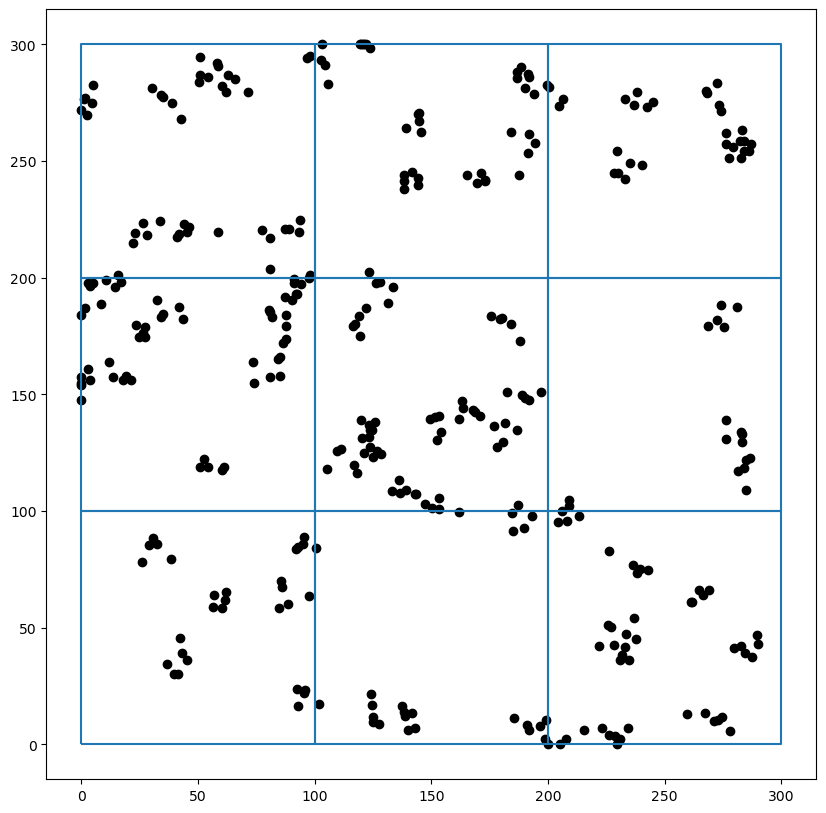

In [255]:
# This is the step where I choose the size of the tracts 
x_step, y_step = 100, 100  # Creates a 3x3 grid, resulting in 16 tracts cell divisions
tracts_gdf = create_tracts(xmin, xmax, ymin, ymax, x_step, y_step)

# Simulate S2

def simulate_clustered_S2(num_points, num_clusters, cluster_std=5, x_range=(0, 300), y_range=(0, 300), random_state=None):
    """
    Simulates clustered points and returns corresponding S2 values and locations.

    Parameters:
    - num_points: total number of points to generate
    - num_clusters: number of spatial clusters to create
    - cluster_std: standard deviation of clusters (controls spread of points)
    - x_range, y_range: bounds for the spatial area (min, max values for x and y)

    Returns:
    - S2: array of S2 values (normally distributed)
    - locations: array of [x, y] coordinates for each point
    """
    
    if random_state is not None:
        np.random.seed(random_state)
    # Generate clustered points using sklearn's make_blobs function
    centers = np.random.uniform(low=x_range[0], high=x_range[1], size=(num_clusters, 2))
    locations, _ = make_blobs(n_samples=num_points, centers=centers, cluster_std=cluster_std)
    
    # Clip points to fit within the study area bounds (if needed)
    locations[:, 0] = np.clip(locations[:, 0], x_range[0], x_range[1])
    locations[:, 1] = np.clip(locations[:, 1], y_range[0], y_range[1])
    
    # Generate S2 values
    S2 = np.random.normal(50, 30, num_points)
    
    return S2, locations

S2, loc2 = simulate_clustered_S2(350, num_clusters=65, cluster_std=4, random_state=12)

tracts_gdf.boundary.plot(figsize=(10, 10))
# tracts_gdf.geometry.centroid.plot()
plt.scatter(loc2[:,0], loc2[:,1], color='k')

S1 = tracts_gdf
S2 = S2
loc1 = np.array([[point.x, point.y] for point in S1.geometry.centroid])
loc2 = loc2


B = create_beta_surface(loc1, heterogeneity='low')

# B = uniform(loc1)

# Generate y values
nbrs_S2 = NearestNeighbors(n_neighbors=len(S1)).fit(loc2)
smoothed_S2_to_S1 = np.zeros(len(S1))
for i in range(len(S1)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
    smoothed_S2_to_S1[i] = np.mean(S2[indices_S1_to_S2[0]])

y = B * smoothed_S2_to_S1

In [256]:
len(S1), len(y), len(S2)

(9, 9, 350)

In [257]:
# Define range for number of neighbors
neighbors_values = list(range(2, len(S1), 2))
best_aicc = float('inf')
best_neighbors = None
recovered_betas_best = None

aicc_values = []
enp_values = []

# Iterate over neighbor values
for n_neighbors in neighbors_values:
    recovered_betas, aicc, enp = perform_local_regression(n_neighbors, loc1, loc2, S2, y)
    aicc_values.append(aicc)
    enp_values.append(enp)
    if aicc < best_aicc:
        best_aicc = aicc
        best_neighbors = n_neighbors
        recovered_betas_best = recovered_betas

print(f"Optimal number of neighbors: {best_neighbors}")
print(f"Best AICc: {best_aicc:.2f}")

Optimal number of neighbors: 6
Best AICc: 141.34


In [258]:
dict_aicc = dict(zip(neighbors_values, aicc_values))
min(dict_aicc, key=dict_aicc.get)

6

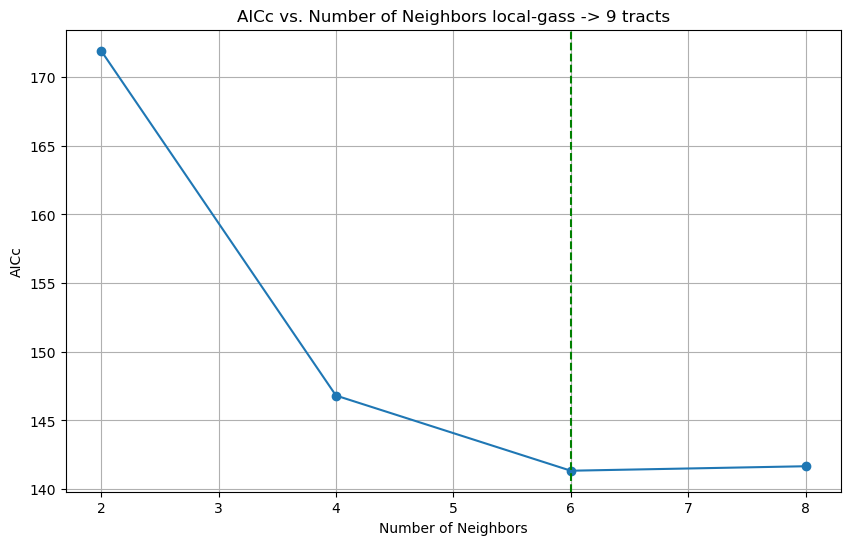

In [259]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(neighbors_values, aicc_values, marker='o')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title('AICc vs. Number of Neighbors local-gass -> 9 tracts')
plt.grid(True)
plt.show()

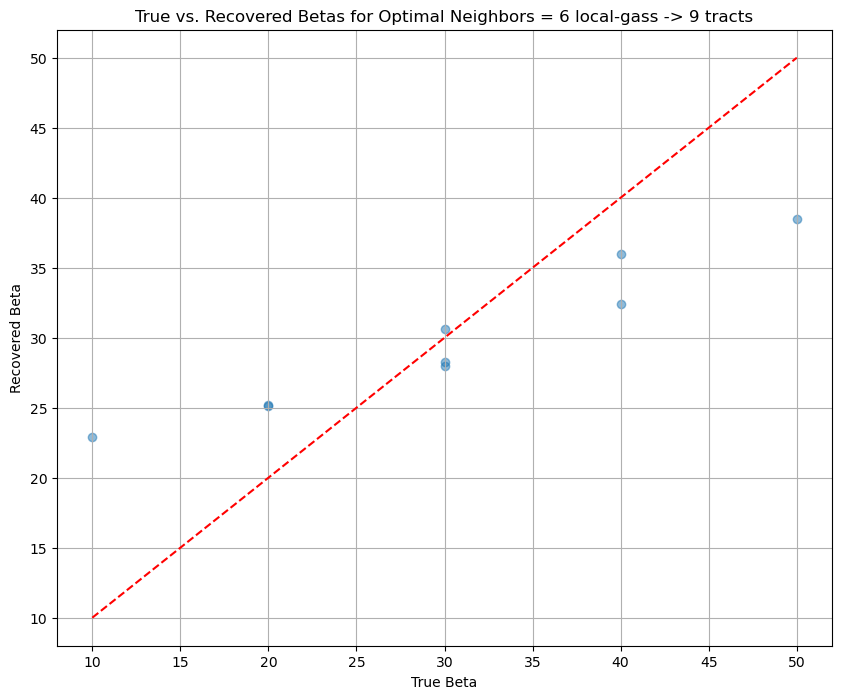

In [260]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, recovered_betas_best, alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors} local-gass -> 9 tracts')
plt.grid(True)
plt.show()

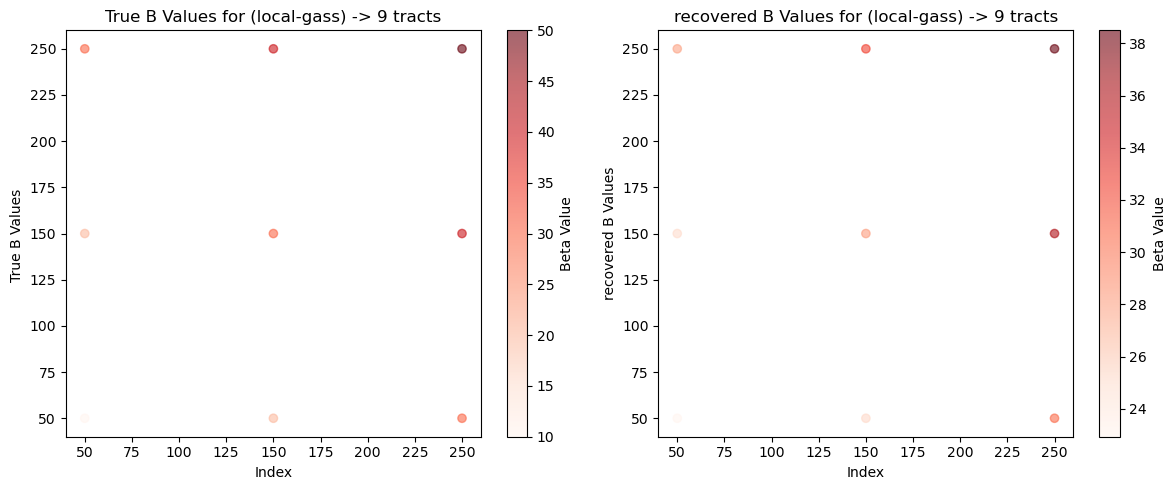

In [261]:
plot_true_and_recovered(B, recovered_betas_best, loc1, name='(local-gass) -> 9 tracts')

In [262]:
B

array([10., 20., 30., 20., 30., 40., 30., 40., 50.])

In [263]:
recovered_betas_best

array([22.936, 25.092, 27.967, 25.207, 28.257, 32.417, 30.608, 36.015,
       38.496])

In [264]:
B.min(), B.max()

(10.0, 50.0)

In [265]:
recovered_betas_best.min(), recovered_betas_best.max()

(22.936123426686198, 38.495818233874864)

#### Aggregating points into census tracts for GWR

For GWR, one has to aggregate points into tracts every time it is increased

In [266]:
df_S2 = gpd.GeoDataFrame({'S2': S2}, geometry=gpd.points_from_xy(loc2[:, 0], loc2[:, 1]))
joined = gpd.sjoin(df_S2, S1, how='inner', predicate='within')
sX = joined.groupby('tract_id').agg({'S2': ['mean']})
sX.columns = ['_'.join(col).strip() for col in sX.columns.values]
sX = sX.reset_index()

# merge back with tracts (S1)
sX1 = S1.merge(sX, on='tract_id', how='left')
sX1.fillna({'S2_mean': 0.000001}, inplace=True)

In [267]:
sX1.head()

tract_id                                           geometry    S2_mean
0         0  POLYGON ((0.000 0.000, 100.000 0.000, 100.000 ...  39.237701
1         1  POLYGON ((0.000 100.000, 100.000 100.000, 100....  56.343616
2         2  POLYGON ((0.000 200.000, 100.000 200.000, 100....  46.109132
3         3  POLYGON ((100.000 0.000, 200.000 0.000, 200.00...  58.303971
4         4  POLYGON ((100.000 100.000, 200.000 100.000, 20...  47.028695

##### Specify GWR parameters

In [268]:
gwr_X  = sX1['S2_mean'].values.reshape(-1,1)
gwr_y = y.reshape(-1, 1)
coords = np.array([[point.x, point.y] for point in sX1['geometry'].centroid])
gwr_X.shape, gwr_y.shape

((9, 1), (9, 1))

In [269]:
aicc_gwr = []
params = []
ENP = []
bwvalue = list(range(2, len(loc1), 2))
for i in bwvalue:
    model = GWR(coords, gwr_y, gwr_X, i, constant=False).fit()
    params.append(model.params)
    aicc_gwr.append(model.aicc)
    ENP.append(model.ENP)

In [270]:
dict_aicc = dict(zip(bwvalue, aicc_gwr))

In [271]:
min(dict_aicc, key=dict_aicc.get)

2

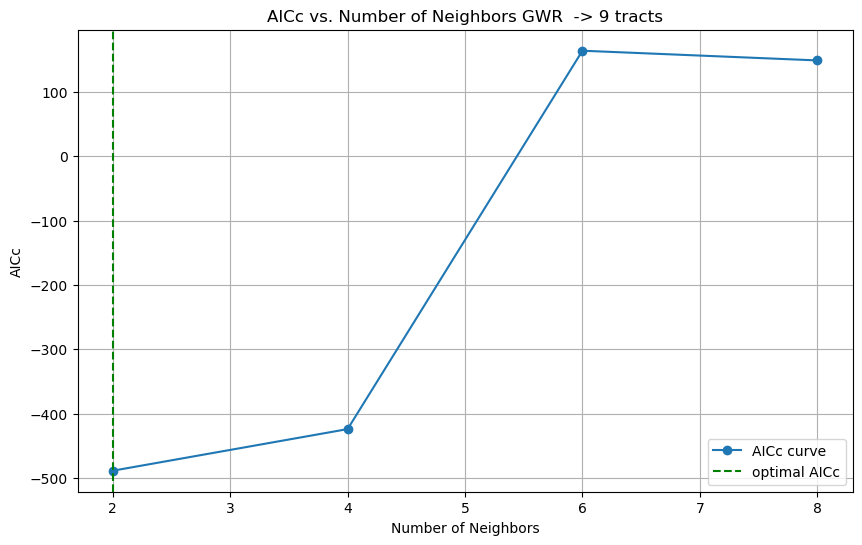

In [272]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(bwvalue, aicc_gwr, marker='o', label='AICc curve')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.legend()
plt.title('AICc vs. Number of Neighbors GWR  -> 9 tracts')
plt.grid(True)
plt.show()

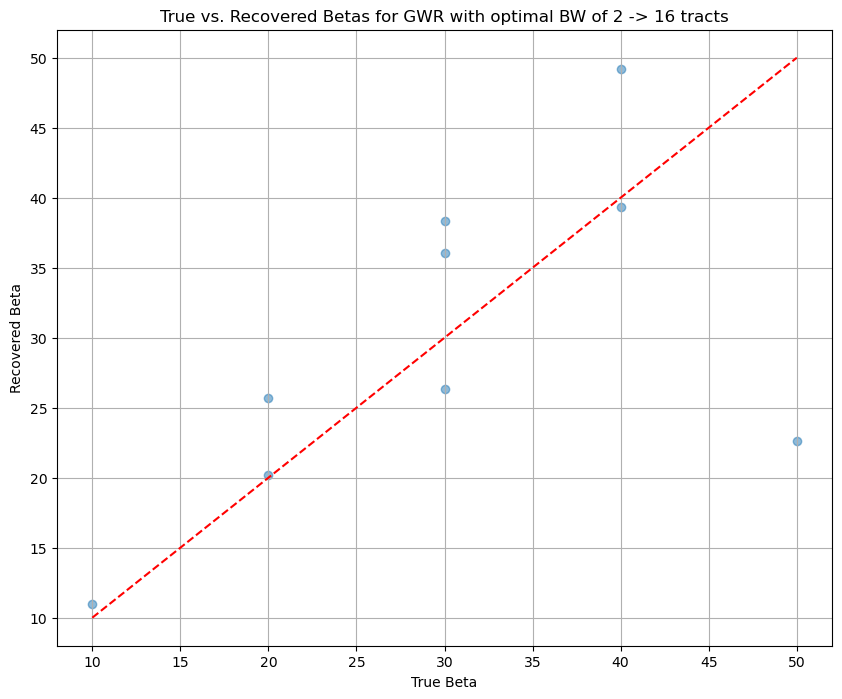

In [273]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(B, params[0].ravel(), alpha=0.5)
plt.plot([B.min(), B.max()], [B.min(), B.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f"True vs. Recovered Betas for GWR with optimal BW of {min(dict_aicc, key=dict_aicc.get)} -> 16 tracts")
plt.grid(True)
plt.show()

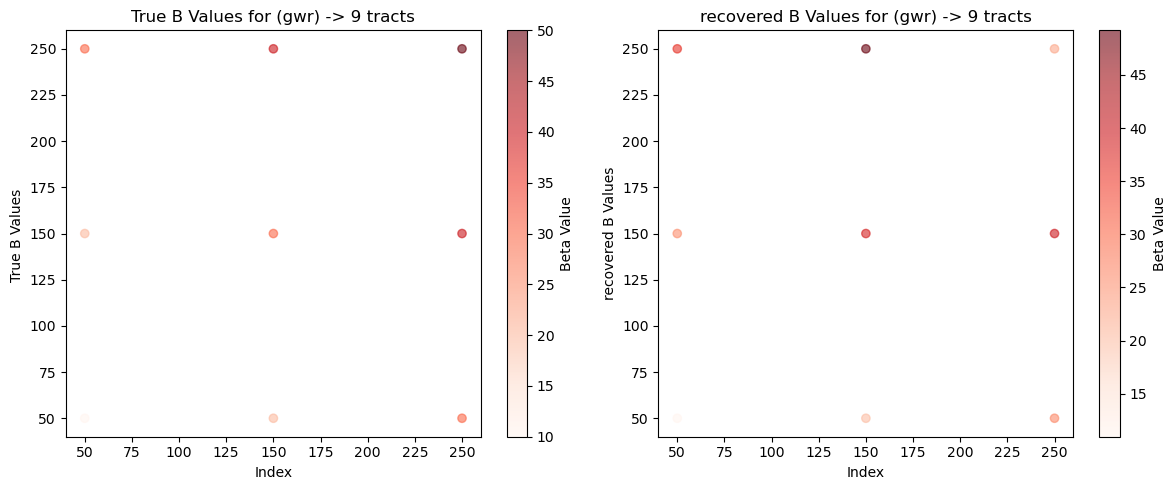

In [274]:
plot_true_and_recovered(B, params[0], loc1, name='(gwr) -> 9 tracts')

In [275]:
B

array([10., 20., 30., 20., 30., 40., 30., 40., 50.])

In [276]:
params[0].flatten()

array([10.953, 25.691, 36.043, 20.213, 38.316, 49.195, 26.325, 39.369,
       22.645])

In [277]:
B.min(), B.max()

(10.0, 50.0)

In [278]:
params[0].min(), params[0].max()

(10.953191761875333, 49.19490110036896)

### Visualize the different aggregation

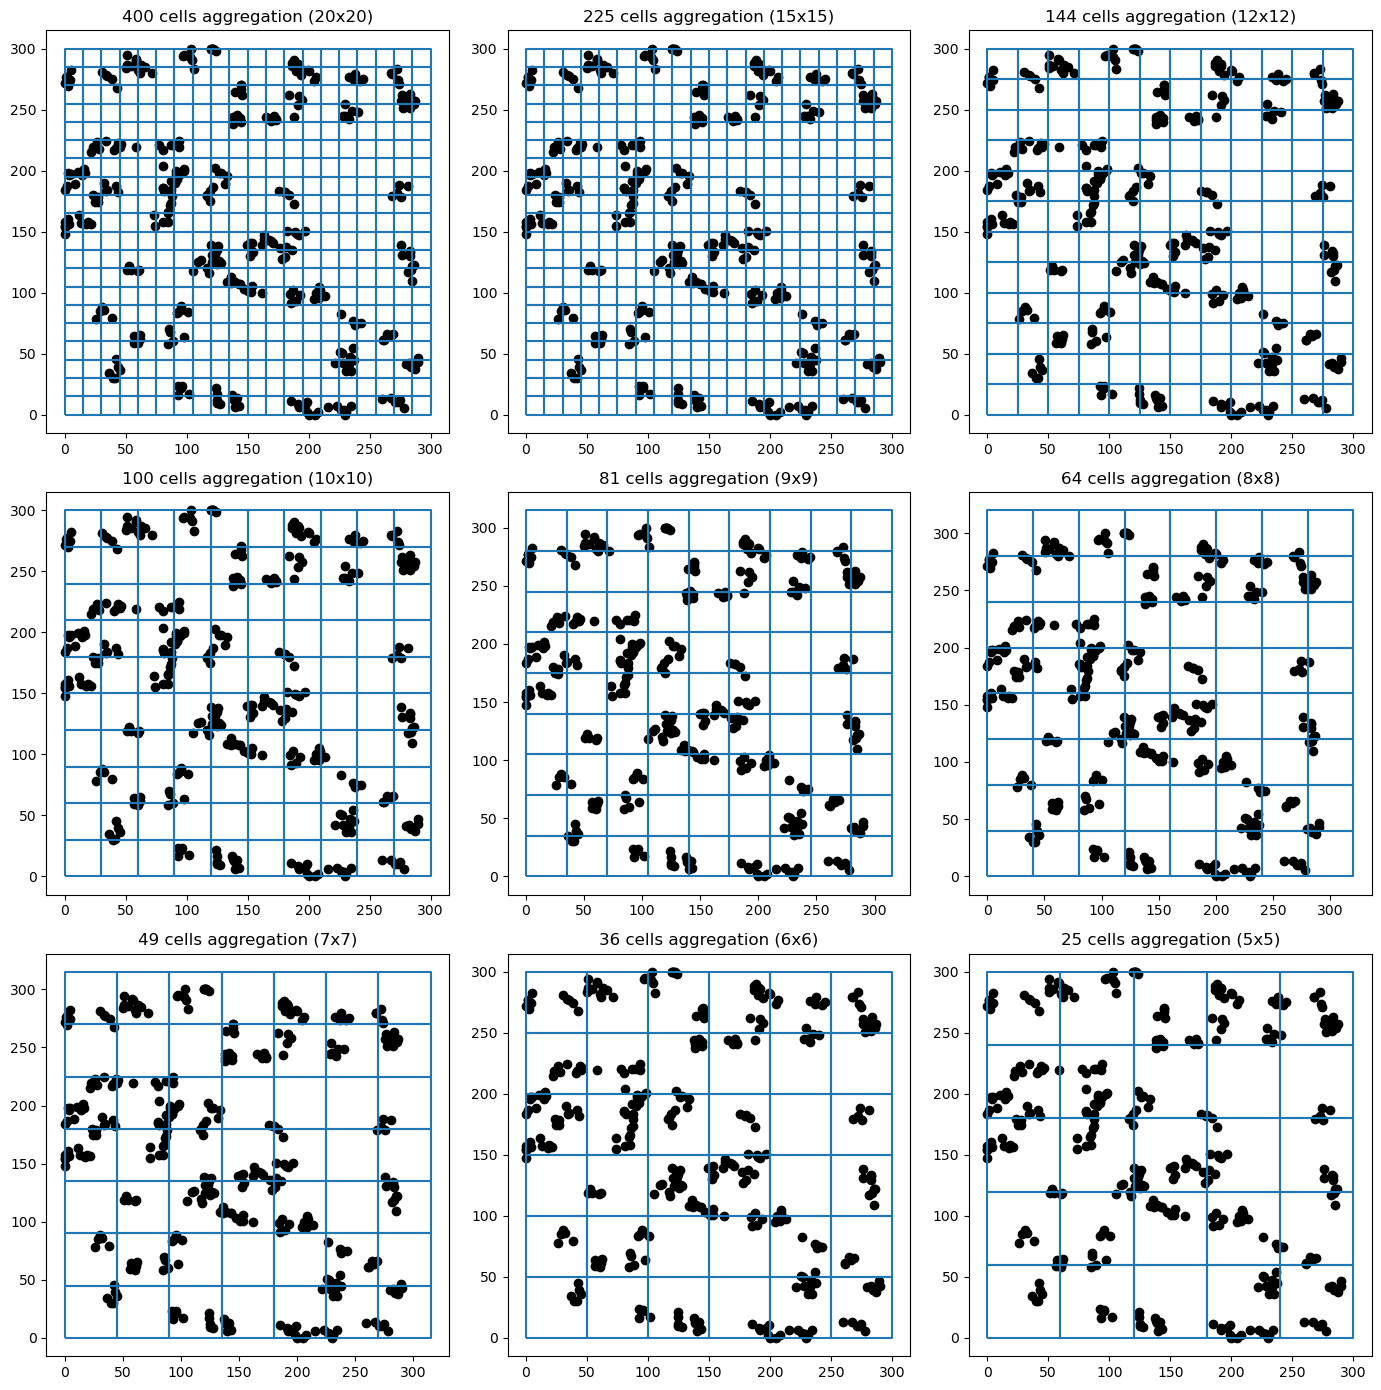

In [279]:
##### Simulate S2
def simulate_S2(num_points):
    np.random.seed(26)
    locations = np.random.rand(num_points, 2) * 300  # Generates random points within a 100x100 space
    s2 = np.random.normal(50, 30, num_points)  # Generates S2 values
    return s2, locations

fig, axs = plt.subplots(3, 3, figsize=(14, 14))  # Create 3x3 grid of subplots

# 20x20 grid
x_step20, y_step20 = 15, 15  # 20x20 tracts (cells)
tracts_gdf20 = create_tracts(xmin, xmax, ymin, ymax, x_step20, y_step20)
S220, loc220 = simulate_clustered_S2(350, num_clusters=65, cluster_std=4, random_state=12)
tracts_gdf20.boundary.plot(ax=axs[0, 0])  # Plot on top-left
axs[0, 0].scatter(loc220[:, 0], loc220[:, 1], color='k')
axs[0, 0].set_title('400 cells aggregation (20x20)')

# 15x15 grid
x_step15, y_step15 = 20, 20  # 15x15 tracts (cells)
tracts_gdf15 = create_tracts(xmin, xmax, ymin, ymax, x_step20, y_step20)
S215, loc215 = simulate_clustered_S2(350, num_clusters=65, cluster_std=4, random_state=12)
tracts_gdf15.boundary.plot(ax=axs[0, 1])  # Plot on top-right
axs[0, 1].scatter(loc215[:, 0], loc215[:, 1], color='k')
axs[0, 1].set_title('225 cells aggregation (15x15)')

# 12x12 grid
x_step12, y_step12 = 25, 25  # 12x12 grid
tracts_gdf12 = create_tracts(xmin, xmax, ymin, ymax, x_step12, y_step12)
S212, loc212 = simulate_clustered_S2(350, num_clusters=65, cluster_std=4, random_state=12)
tracts_gdf12.boundary.plot(ax=axs[0, 2])  # Plot on bottom-left
axs[0, 2].scatter(loc212[:, 0], loc212[:, 1], color='k')
axs[0, 2].set_title('144 cells aggregation (12x12)')

# 10x10 grid
x_step30, y_step30 = 30, 30  # 10x10 grid
tracts_gdf30 = create_tracts(xmin, xmax, ymin, ymax, x_step30, y_step30)
S230, loc230 = simulate_clustered_S2(350, num_clusters=65, cluster_std=4, random_state=12)
tracts_gdf30.boundary.plot(ax=axs[1, 0])  # Plot on bottom-right
axs[1, 0].scatter(loc230[:, 0], loc230[:, 1], color='k')
axs[1, 0].set_title('100 cells aggregation (10x10)')

# 9x9 grid
x_step35, y_step35 = 35, 35  # 9x9 grid
tracts_gdf35 = create_tracts(xmin, xmax, ymin, ymax, x_step35, y_step35)
S235, loc235 = simulate_clustered_S2(350, num_clusters=65, cluster_std=4, random_state=12)
tracts_gdf35.boundary.plot(ax=axs[1, 1])  # Plot on bottom-right
axs[1, 1].scatter(loc235[:, 0], loc235[:, 1], color='k')
axs[1, 1].set_title('81 cells aggregation (9x9)')

# 40x40 grid
x_step40, y_step40 = 40, 40  # 40x40 grid
tracts_gdf40 = create_tracts(xmin, xmax, ymin, ymax, x_step40, y_step40)
S240, loc240 = simulate_clustered_S2(350, num_clusters=65, cluster_std=4, random_state=12)
tracts_gdf40.boundary.plot(ax=axs[1, 2])  # Plot on bottom-right
axs[1, 2].scatter(loc240[:, 0], loc240[:, 1], color='k')
axs[1, 2].set_title('64 cells aggregation (8x8)')


# 45X45 grid
x_step45, y_step45 = 45, 45  # 45X45 grid
tracts_gdf45 = create_tracts(xmin, xmax, ymin, ymax, x_step45, y_step45)
S245, loc245 = simulate_clustered_S2(350, num_clusters=65, cluster_std=4, random_state=12)
tracts_gdf45.boundary.plot(ax=axs[2, 0])  # Plot on bottom-right
axs[2, 0].scatter(loc245[:, 0], loc245[:, 1], color='k')
axs[2, 0].set_title('49 cells aggregation (7x7)')

# 50x50 grid
x_step50, y_step50 = 50, 50  # 50x50 grid
tracts_gdf50 = create_tracts(xmin, xmax, ymin, ymax, x_step50, y_step50)
S250, loc250 = simulate_clustered_S2(350, num_clusters=65, cluster_std=4, random_state=12)
tracts_gdf50.boundary.plot(ax=axs[2, 1])  # Plot on bottom-right
axs[2, 1].scatter(loc250[:, 0], loc250[:, 1], color='k')
axs[2, 1].set_title('36 cells aggregation (6x6)')

# 60x60 grid
x_step60, y_step60 = 60, 60  # 60x60 grid
tracts_gdf60 = create_tracts(xmin, xmax, ymin, ymax, x_step60, y_step60)
S260, loc260 = simulate_clustered_S2(350, num_clusters=65, cluster_std=4, random_state=12)
tracts_gdf60.boundary.plot(ax=axs[2, 2])  # Plot on bottom-right
axs[2, 2].scatter(loc260[:, 0], loc260[:, 1], color='k')
axs[2, 2].set_title('25 cells aggregation (5x5)')


# Adjust layout
plt.tight_layout()
plt.show()
